# AP-1 RNA-seq Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


In [2]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_venn import venn3, venn2
import pickle
from matplotlib import patches as mpatches
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')

## Preprocessing

In [3]:
# file directories
workingDirectory = '/home/jtao/analysis/ap1_rna_analysis/'
binDirectory = '/home/jtao/bin/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'
genomes = ['hg19','mm10', 'hg38']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files/'
tagDirPath = '/home/jtao/analysis/ap1_analysis/tag_directories_rna/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr/'

os.chdir(workingDirectory)

In [251]:
strains = []
treatments = []
owners = []
dates = []
originalNames = []
targets = []
for f in os.listdir('./tag_directories/'):
    if os.path.isdir(tagDirPath+'/'+f):
        originalName = f
        metaDataTokens = f.split('_')

        originalNames.append(originalName)
        # grab metadata from string tokens
        strain = metaDataTokens[0].strip()
        target = metaDataTokens[4].strip()
        treatment = metaDataTokens[3].strip().split('-')
        owner = metaDataTokens[5].strip()
        date = metaDataTokens[6].strip()

        # append to overall lists
        strains.append(strain)
        treatments.append(treatment)
        owners.append(owner)
        dates.append(date)
        targets.append(target)
metadata_frame = pd.DataFrame([strains, 
                                  targets,
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  ]).transpose()
metadata_frame.columns = ['strain', 
                          'target',
                         'treatment',
                         'owner', 
                         'sampleName']

# ### read in log files ###

# create data frame summarizing mapping quality logs

# # from tagInfo.txt
_originalNames =[]
_totalReads = []
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []


for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        _totalReads.append(float(data[1].split()[2]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 

                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values),
                                                  list(summary_frame['target'].values),
                                                  list(summary_frame['treatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics_rna.tsv', sep='\t', index=False)
summary_frame_rna = summary_frame.copy()

TypeError: unhashable type: 'list'

## Mapping Quality Control

### Plot Distributions of Mapping Statistics

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


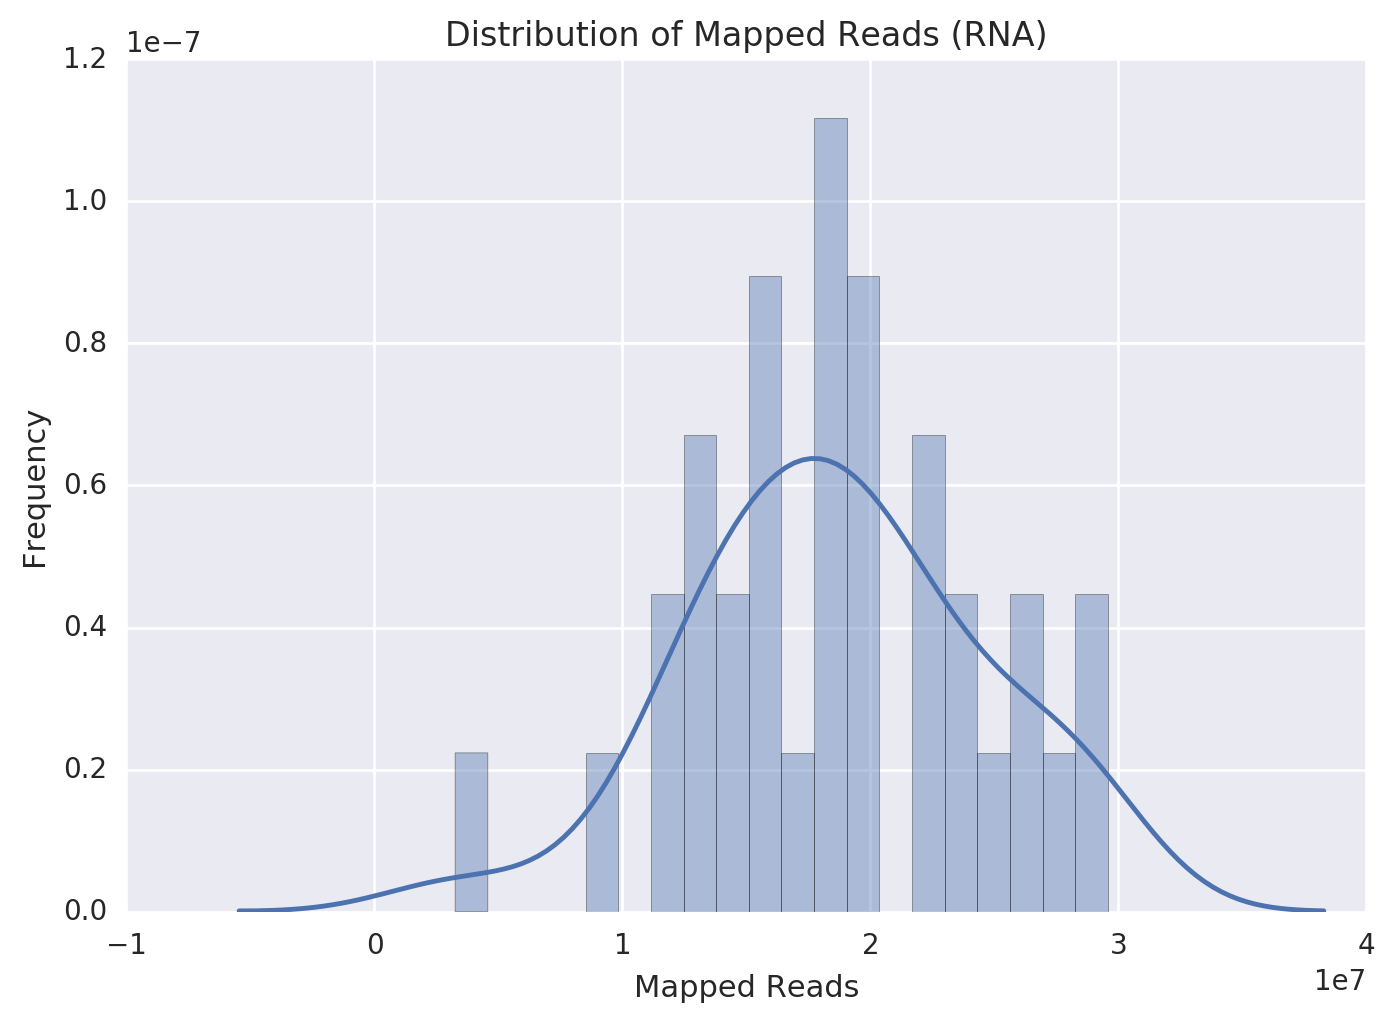

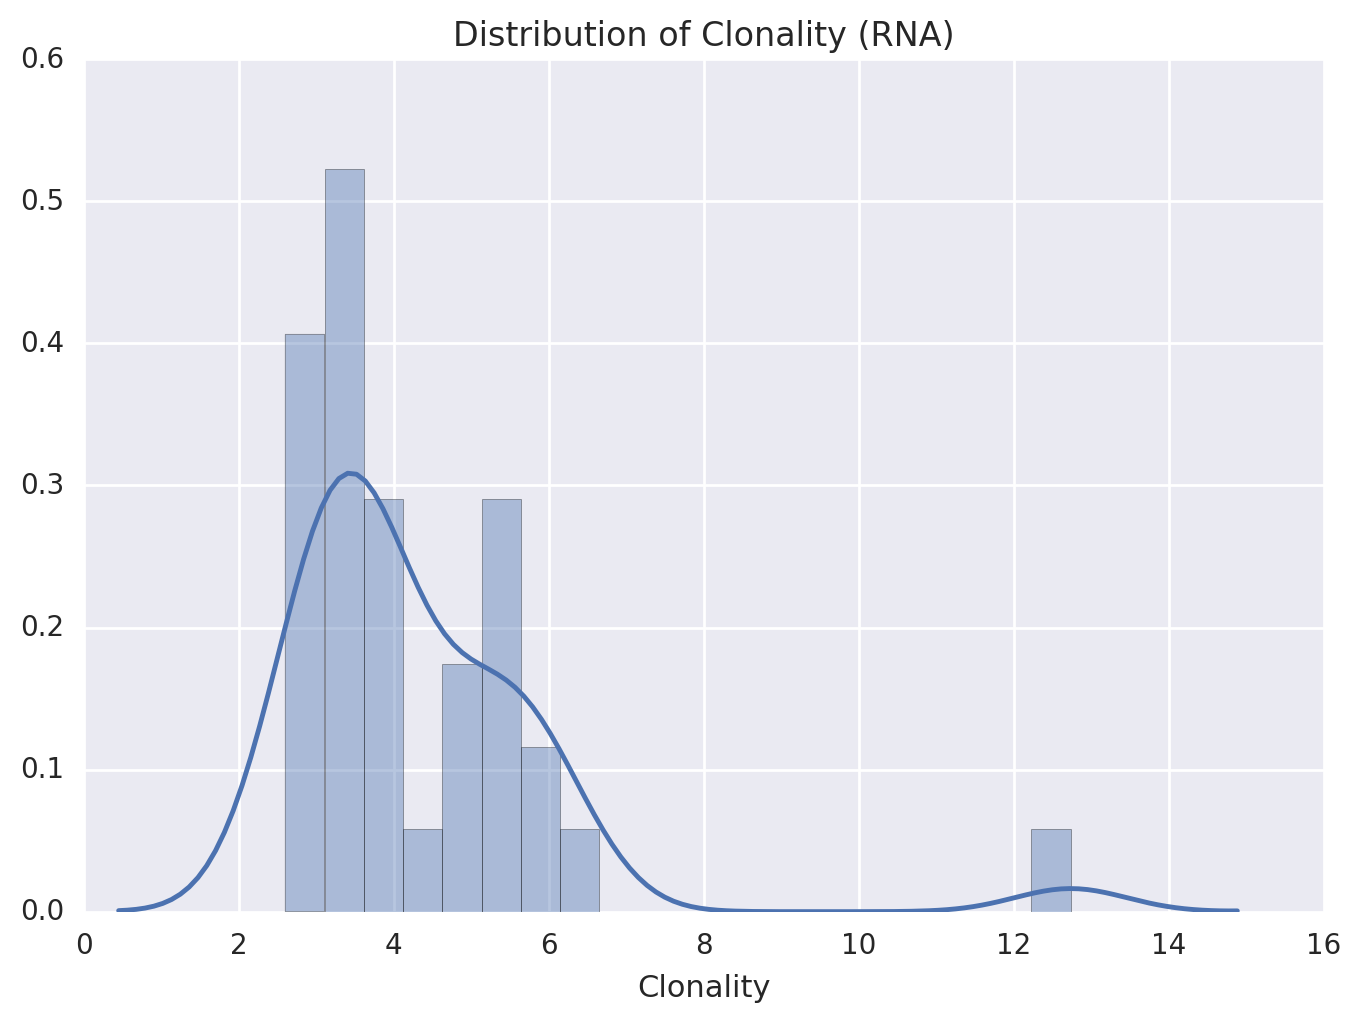

In [8]:
sns.distplot(summary_frame_rna['totalReads'], bins=20, kde=True)
plt.title('Distribution of Mapped Reads (RNA)')
plt.xlabel('Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_frame_rna['averageTagsPerPosition'], bins=20)
plt.title('Distribution of Clonality (RNA)')
plt.xlabel('Clonality')
plt.show()


### Filter Samples According to Mapping Quality

In [9]:
# # filter samples according to threshold for the fraction of uniquely mapped reads
# readsThreshold = 1000000
# # pbcThreshold=0.0
# # gcThreshold=0.10
# clonalityThreshold = 10
# # spotThreshold = 0.005

filtered_summary_frame_rna = summary_frame_rna.copy()

# filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['totalReads'] >= readsThreshold]

# filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['averageTagsPerPosition'] <= clonalityThreshold]


## Calculate Tag Counts and RPKM

In [ ]:
filteredTagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in filtered_summary_frame_rna['sampleName']])

!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $filteredTagDirectories > rpkm.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw.tsv

In [11]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]
rpkm_frame.index = rpkm_frame['gene'].values

raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "tag_directories" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0].upper() for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))
refseq_gene_mapping.update(dict(zip(raw_frame['refseq'].values, [x.split("|")[0].upper() for x in raw_frame['Annotation/Divergence']])))
gene_refseq_mapping.update(dict(zip([x.split("|")[0].upper() for x in raw_frame['Annotation/Divergence']], raw_frame['refseq'].values)))

# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame_rna['sampleName'].values]]
# columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
# filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 1.0]

## Run IDR

In [12]:
# %%capture
idrDirectory = '/home/jtao/analysis/ap1_rna_analysis/idr_rna_raw/'
sampleColumns = raw_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                             filtered_summary_frame_rna['target'] +
                                             '_' + filtered_summary_frame_rna['treatment']))

conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo "python /home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv $idrDirectory $conditions &"
!python /home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv $idrDirectory $conditions


python /home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv /home/jtao/analysis/ap1_rna_analysis/idr_rna_raw/ UT_KLA UT_KLA UT_KLA UT_KLA UT_Veh UT_Veh siATF3_KLA siATF3_KLA siATF3_Veh siATF3_Veh siCtrl1-1_KLA siCtrl1-1_Veh siCtrl1-2_KLA siCtrl1-2_Veh siCtrl2-1_KLA siCtrl2-1_Veh siCtrl2-2_KLA siCtrl2-2_Veh siFos_KLA siFos_KLA siFos_Veh siFos_Veh siJunB_KLA siJunB_KLA siJunB_Veh siJunB_Veh siJunD_KLA siJunD_KLA siJunD_Veh siJunD_Veh sicJun_KLA sicJun_KLA sicJun_Veh sicJun_Veh &
Output files will be written to: /home/jtao/analysis/ap1_rna_analysis/idr_rna_raw/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09 (28745335.0 total) 	 UT_KLA
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15 (12909232.0 total) 	 UT_KLA
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-

In [100]:
# %%capture
idrDirectory = '/home/jtao/analysis/ap1_rna_analysis/idr_rna/'
sampleColumns = raw_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                             filtered_summary_frame_rna['target'] +
                                             '_' + filtered_summary_frame_rna['treatment']))

conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])

!python /home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions -p



Output files will be written to: /home/jtao/analysis/ap1_rna_analysis/idr_rna/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09 FPKM 	 UT_KLA
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15 FPKM 	 UT_KLA
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_15-04-06 FPKM 	 UT_KLA
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_VML_15-02-26 FPKM 	 UT_KLA
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15 FPKM 	 UT_Veh
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06 FPKM 	 UT_Veh
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siATF3_GJF_16-06-14 FPKM 	 siATF3_KLA
/home/jtao/analysis/ap1_analysis/tag_directories_

In [101]:
%%bash
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//siATF3_KLA_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//siATF3_KLA_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//siATF3_KLA_1_siATF3_KLA_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//siATF3_KLA_2.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//sicJun_KLA_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//sicJun_KLA_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//sicJun_KLA_1_sicJun_KLA_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//sicJun_KLA_2.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_Veh_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_Veh_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_Veh_1_UT_Veh_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_Veh_2.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunB_Veh_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunB_Veh_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunB_Veh_1_siJunB_Veh_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunB_Veh_2.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunB_KLA_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunB_KLA_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunB_KLA_1_siJunB_KLA_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunB_KLA_2.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//siFos_Veh_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//siFos_Veh_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//siFos_Veh_1_siFos_Veh_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//siFos_Veh_2.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunD_KLA_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunD_KLA_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunD_KLA_1_siJunD_KLA_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunD_KLA_2.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_1_UT_KLA_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_2.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_3.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_1_UT_KLA_3_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_3.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_4.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_1_UT_KLA_4_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_4.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_2.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_3.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_2_UT_KLA_3_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_3.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_2.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_4.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_2_UT_KLA_4_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_4.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_3.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_4.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_3_UT_KLA_4_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//UT_KLA_4.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//siFos_KLA_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//siFos_KLA_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//siFos_KLA_1_siFos_KLA_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//siFos_KLA_2.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//sicJun_Veh_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//sicJun_Veh_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//sicJun_Veh_1_sicJun_Veh_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//sicJun_Veh_2.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunD_Veh_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunD_Veh_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunD_Veh_1_siJunD_Veh_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//siJunD_Veh_2.narrowPeak &
idr --samples /home/jtao/analysis/ap1_rna_analysis/idr_rna//siATF3_Veh_1.narrowPeak /home/jtao/analysis/ap1_rna_analysis/idr_rna//siATF3_Veh_2.narrowPeak --output-file /home/jtao/analysis/ap1_rna_analysis/idr_rna//siATF3_Veh_1_siATF3_Veh_2_idr.out --plot --idr-threshold 0.05 --peak-list /home/jtao/analysis/ap1_rna_analysis/idr_rna//siATF3_Veh_2.narrowPeak &

Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [2.42 0.52 0.85 0.49]
Final parameter values: [2.43 0.51 0.86 0.49]
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/idr-2.0.2-py3

In [ ]:
!python /home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

In [116]:
idr_rpkm_frame = pd.read_csv('idr_rna/idr_union.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

idr_rpkm_mean_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    tokens = col.split('_')
    target = tokens[4]
    if 'Ctrl'in target:
        target = target[:-3]
    treatment =  tokens[3] + '_' + target

    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_mean_frame = idr_rpkm_mean_frame.sort()

idr_rpkm_mean_frame = idr_rpkm_mean_frame[sorted(idr_rpkm_mean_frame.columns.values)]


idr_rpkm_frame.to_pickle('idr_rpkm_frame.pickle')
idr_rpkm_mean_frame.to_pickle('idr_rpkm_mean_frame.pickle')


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(....) is deprecated, use sort_index(.....)


## Calculate Correlations Between Samples

In [44]:
def calcCorrelation(raw_frame,samples, annot=False):

    numSamples = len(samples)
    matrix = np.ones((numSamples, numSamples))

    for i in range(numSamples - 1):
        vals_1 = raw_frame[samples[i]]
        for j in range(i + 1, numSamples):
            vals_2 = raw_frame[samples[j]]
            pearson, pearson_p = scipy.stats.pearsonr(vals_1, vals_2)

            matrix[i][j] = pearson
            matrix[j][i] = pearson

    sample_names = [x.replace('C57Bl6_Thiomac_RNA_','') for x in samples]
    matrix_frame = pd.DataFrame(matrix, index=sample_names, columns=sample_names)


    cg = sns.clustermap(matrix_frame, metric = 'correlation', figsize=(16,16), annot=annot, fmt='0.2g')
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
    plt.show()
#     return matrix_frame

In [45]:
def calcSpearmanCorrelation(raw_frame,samples, annot=False):

    numSamples = len(samples)
    matrix = np.ones((numSamples, numSamples))

    for i in range(numSamples - 1):
        vals_1 = raw_frame[samples[i]]
        for j in range(i + 1, numSamples):
            vals_2 = raw_frame[samples[j]]
            pearson, pearson_p = scipy.stats.spearmanr(vals_1, vals_2)

            matrix[i][j] = pearson
            matrix[j][i] = pearson

    sample_names = [x.replace('C57Bl6_Thiomac_RNA_','') for x in samples]
    matrix_frame = pd.DataFrame(matrix, index=sample_names, columns=sample_names)


    cg = sns.clustermap(matrix_frame, metric = 'correlation', figsize=(16,16), annot=annot, fmt='0.2g')
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
    plt.show()
#     return matrix_frame

### All Samples

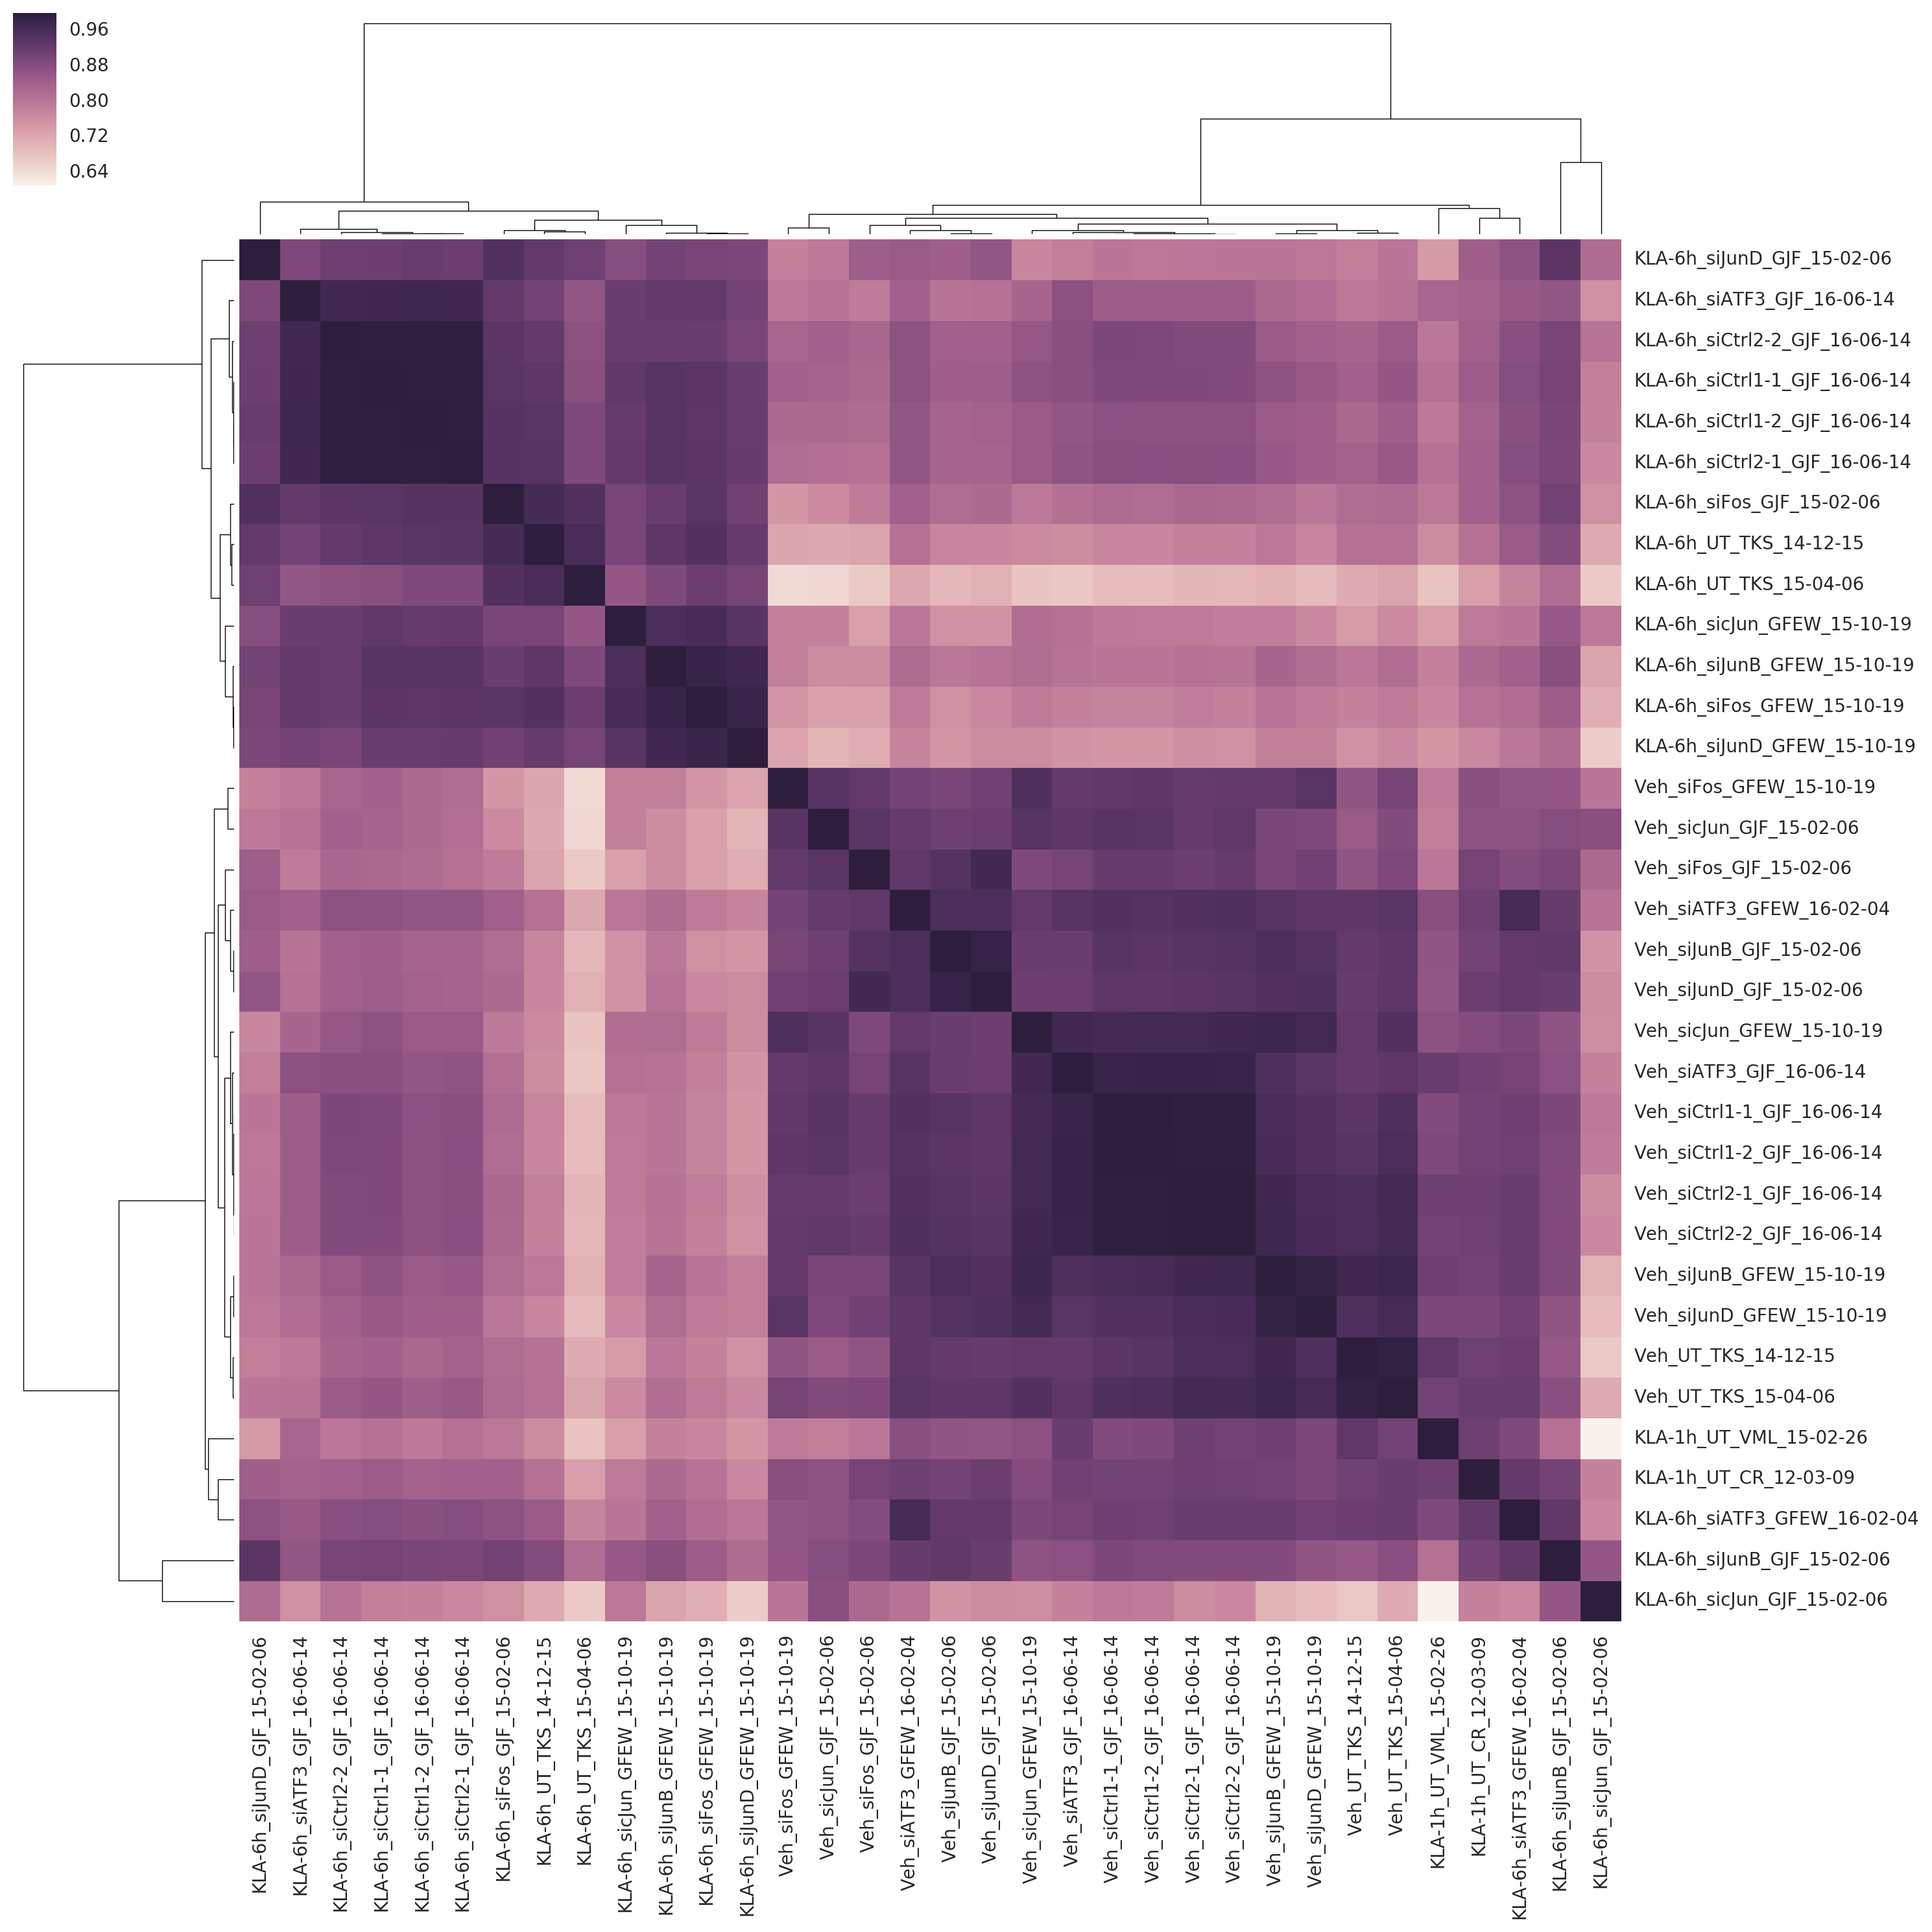

In [46]:
calcCorrelation(raw_frame, raw_frame.columns[9:].values)

### Veh Samples

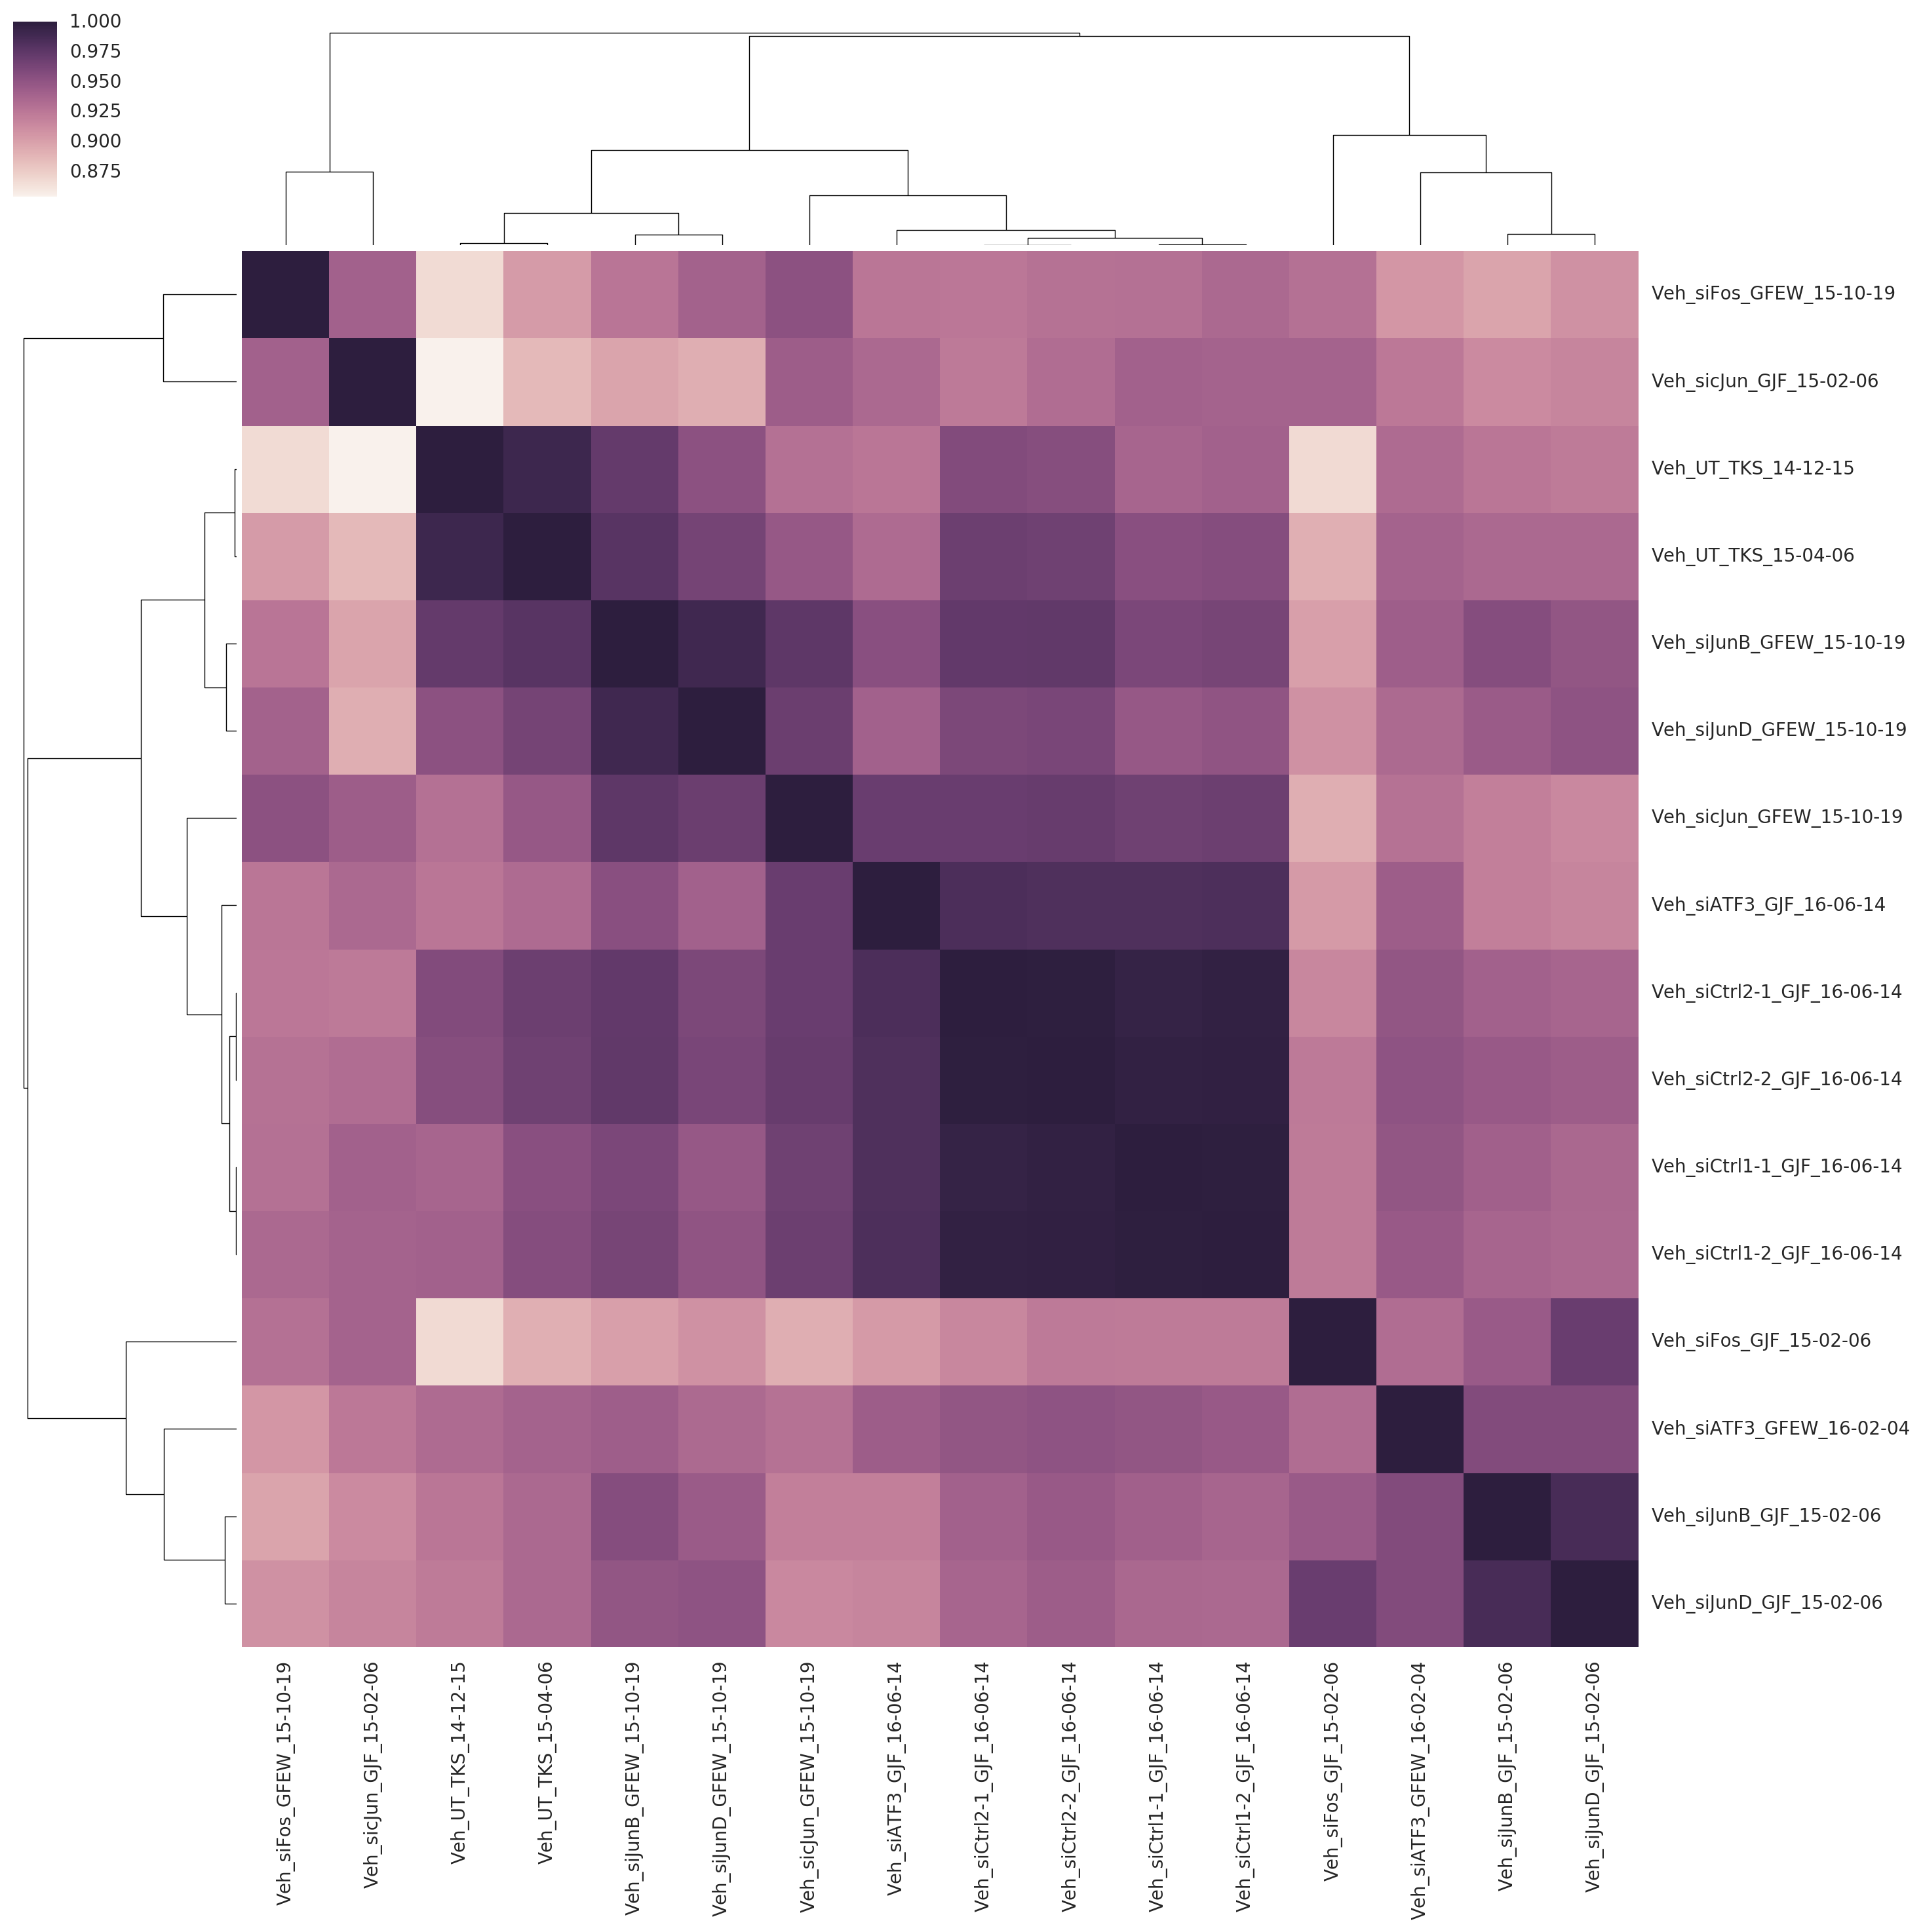

In [47]:
calcCorrelation(raw_frame, [x for x in raw_frame.columns[9:].values if 'Veh' in x])

### KLA Samples

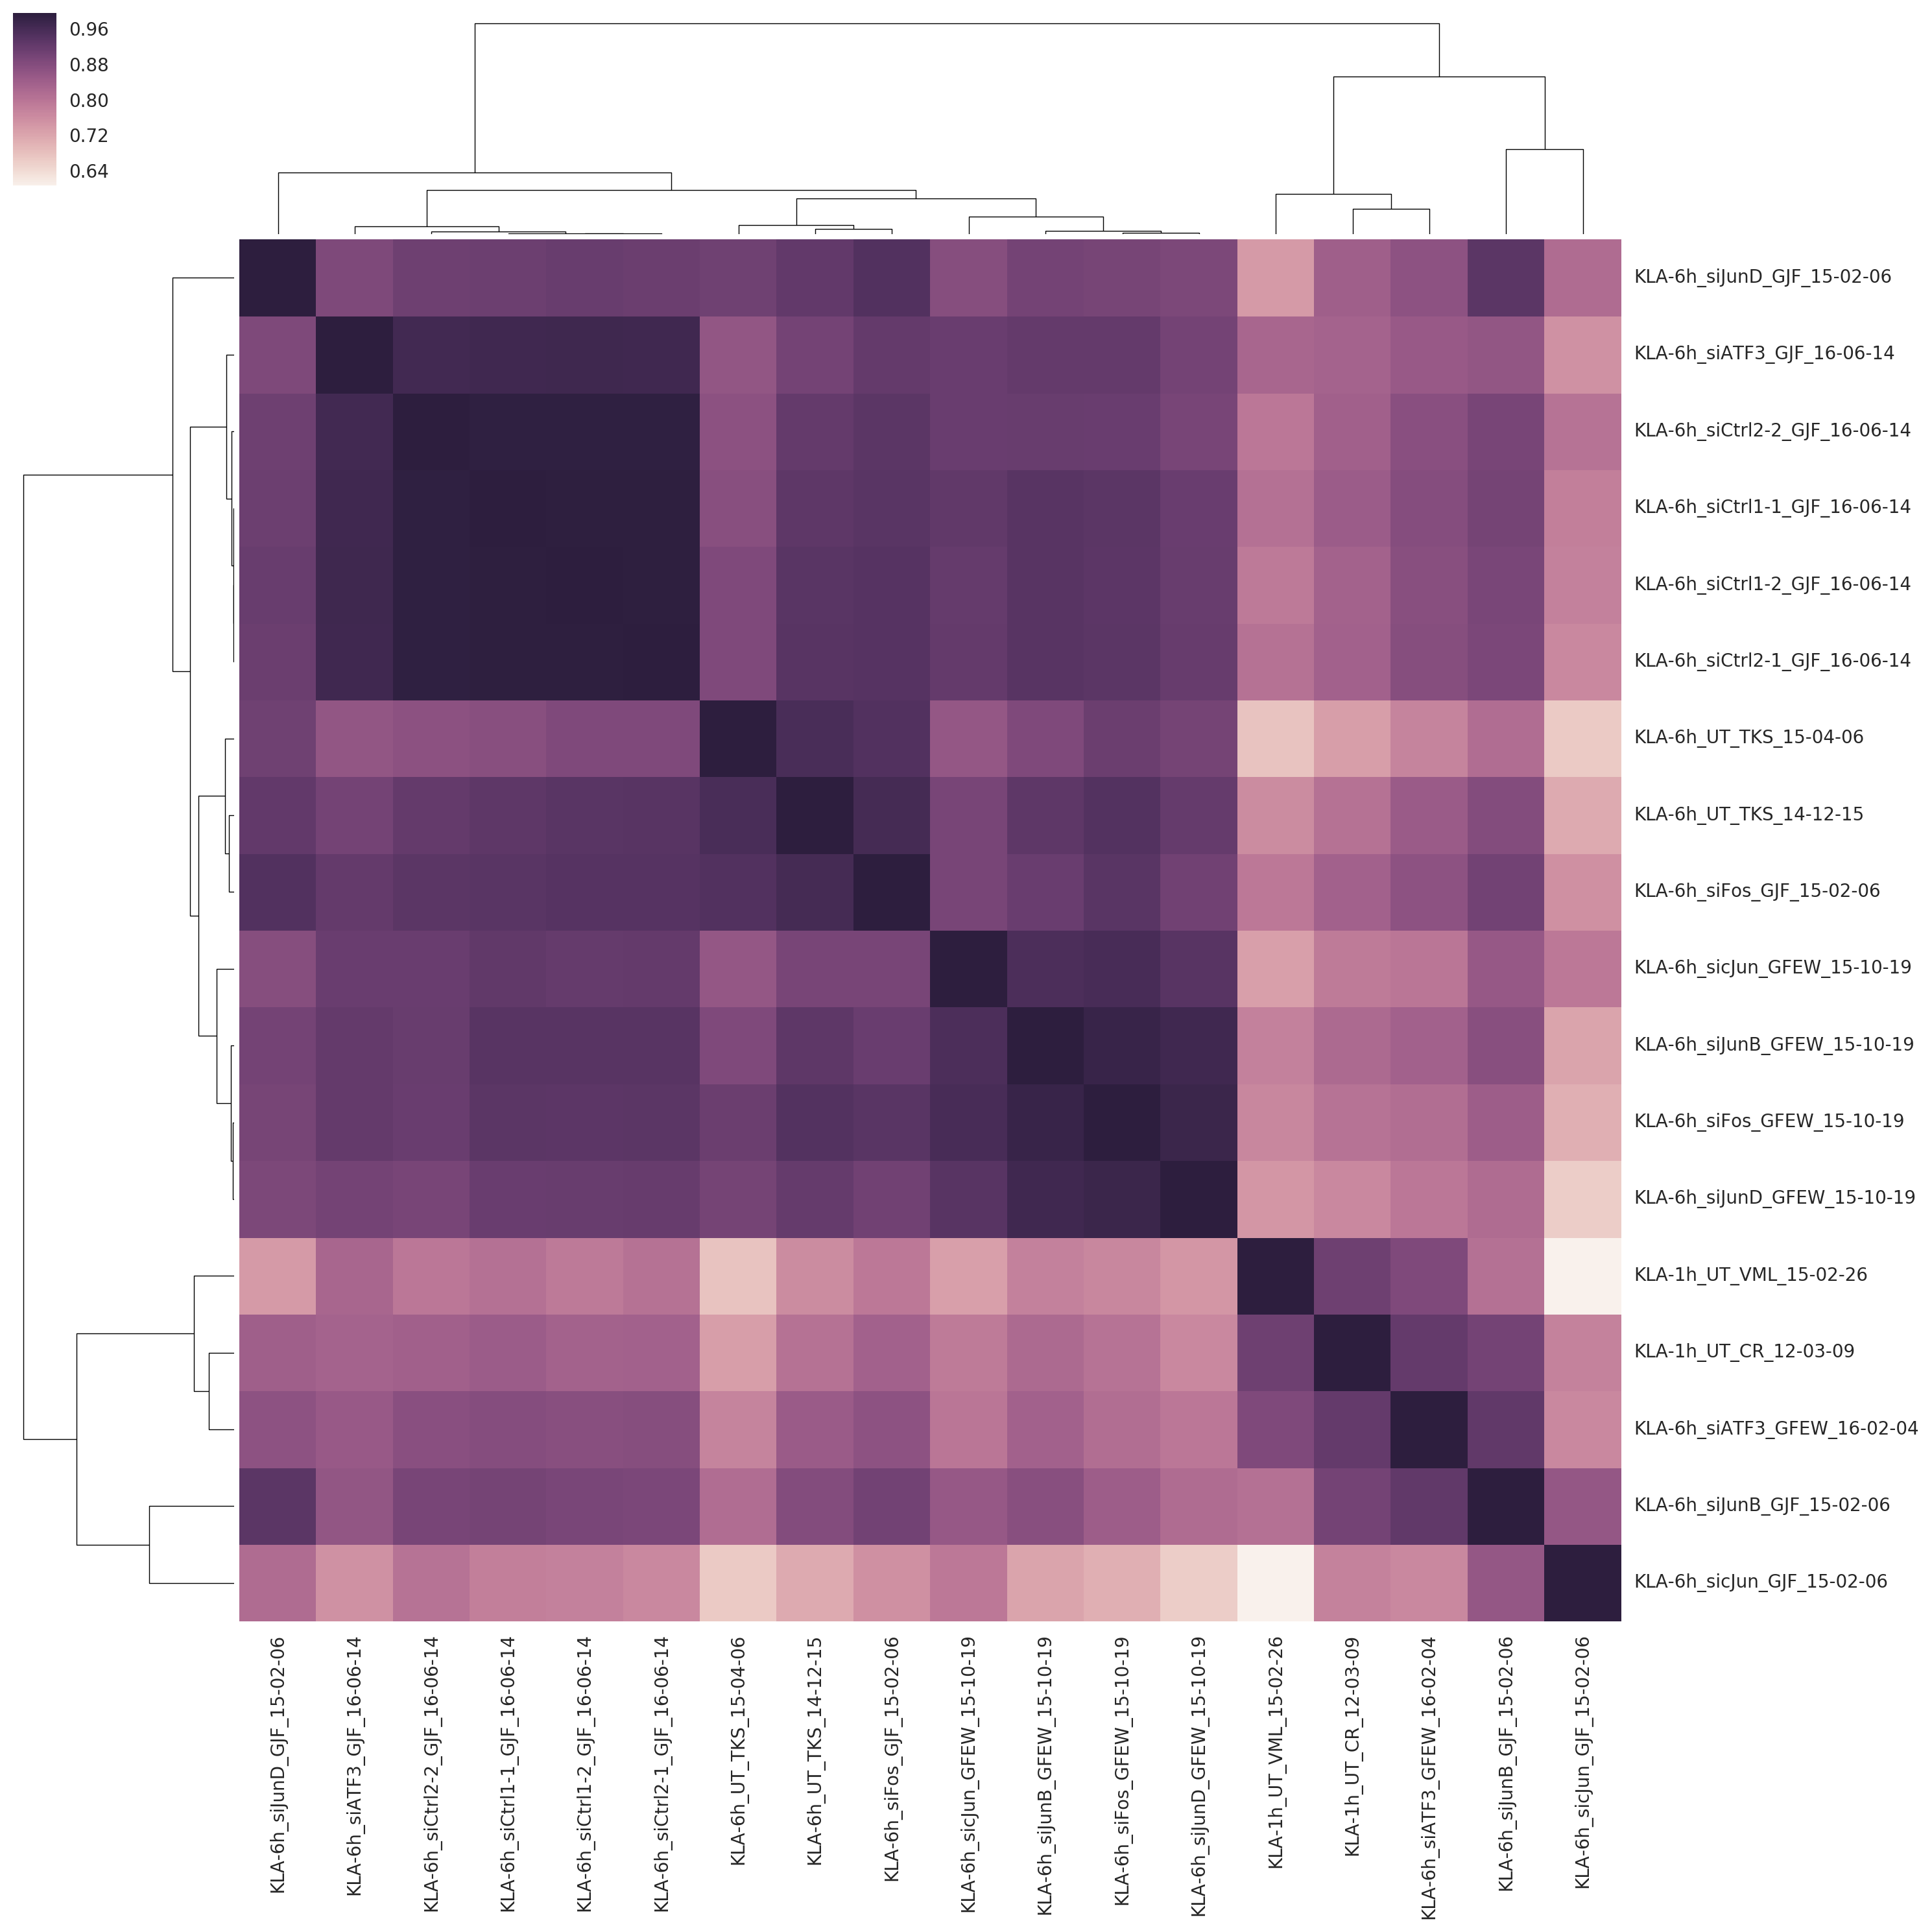

In [48]:
calcCorrelation(raw_frame, [x for x in raw_frame.columns[9:].values if 'KLA' in x])

### Control Samples

#### All

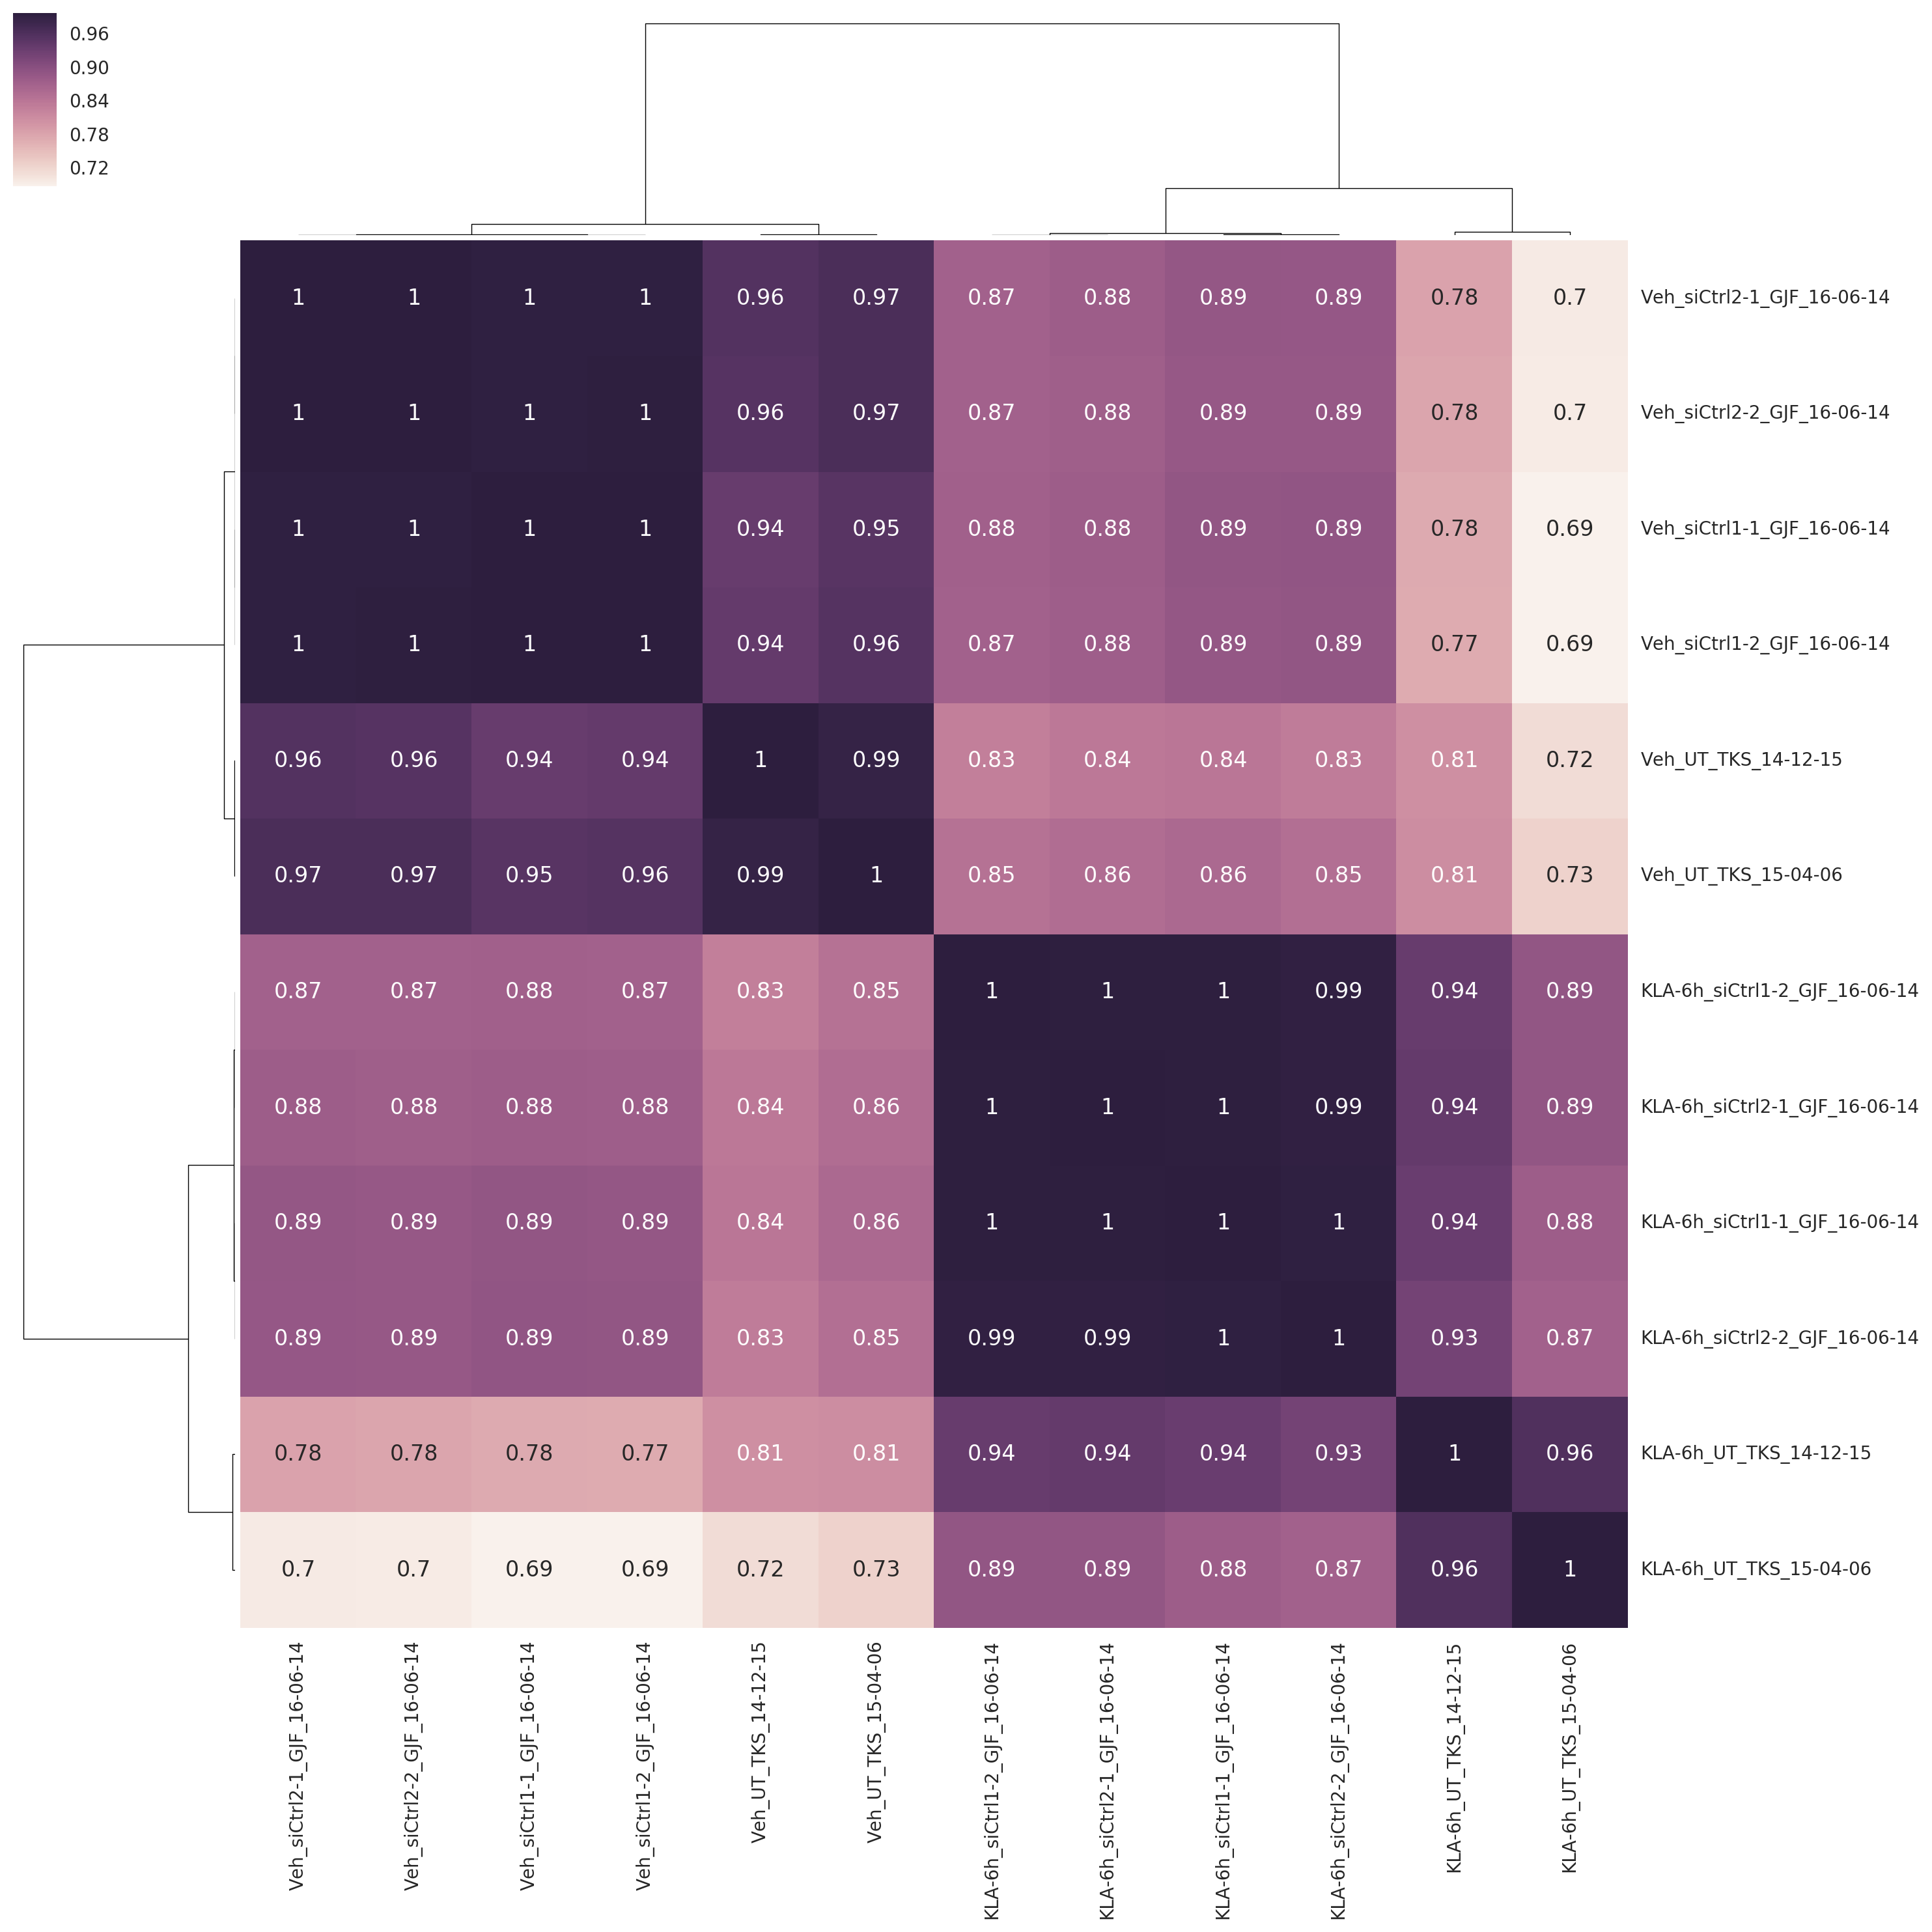

In [49]:
calcCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and not '-1h' in x], 
                True)

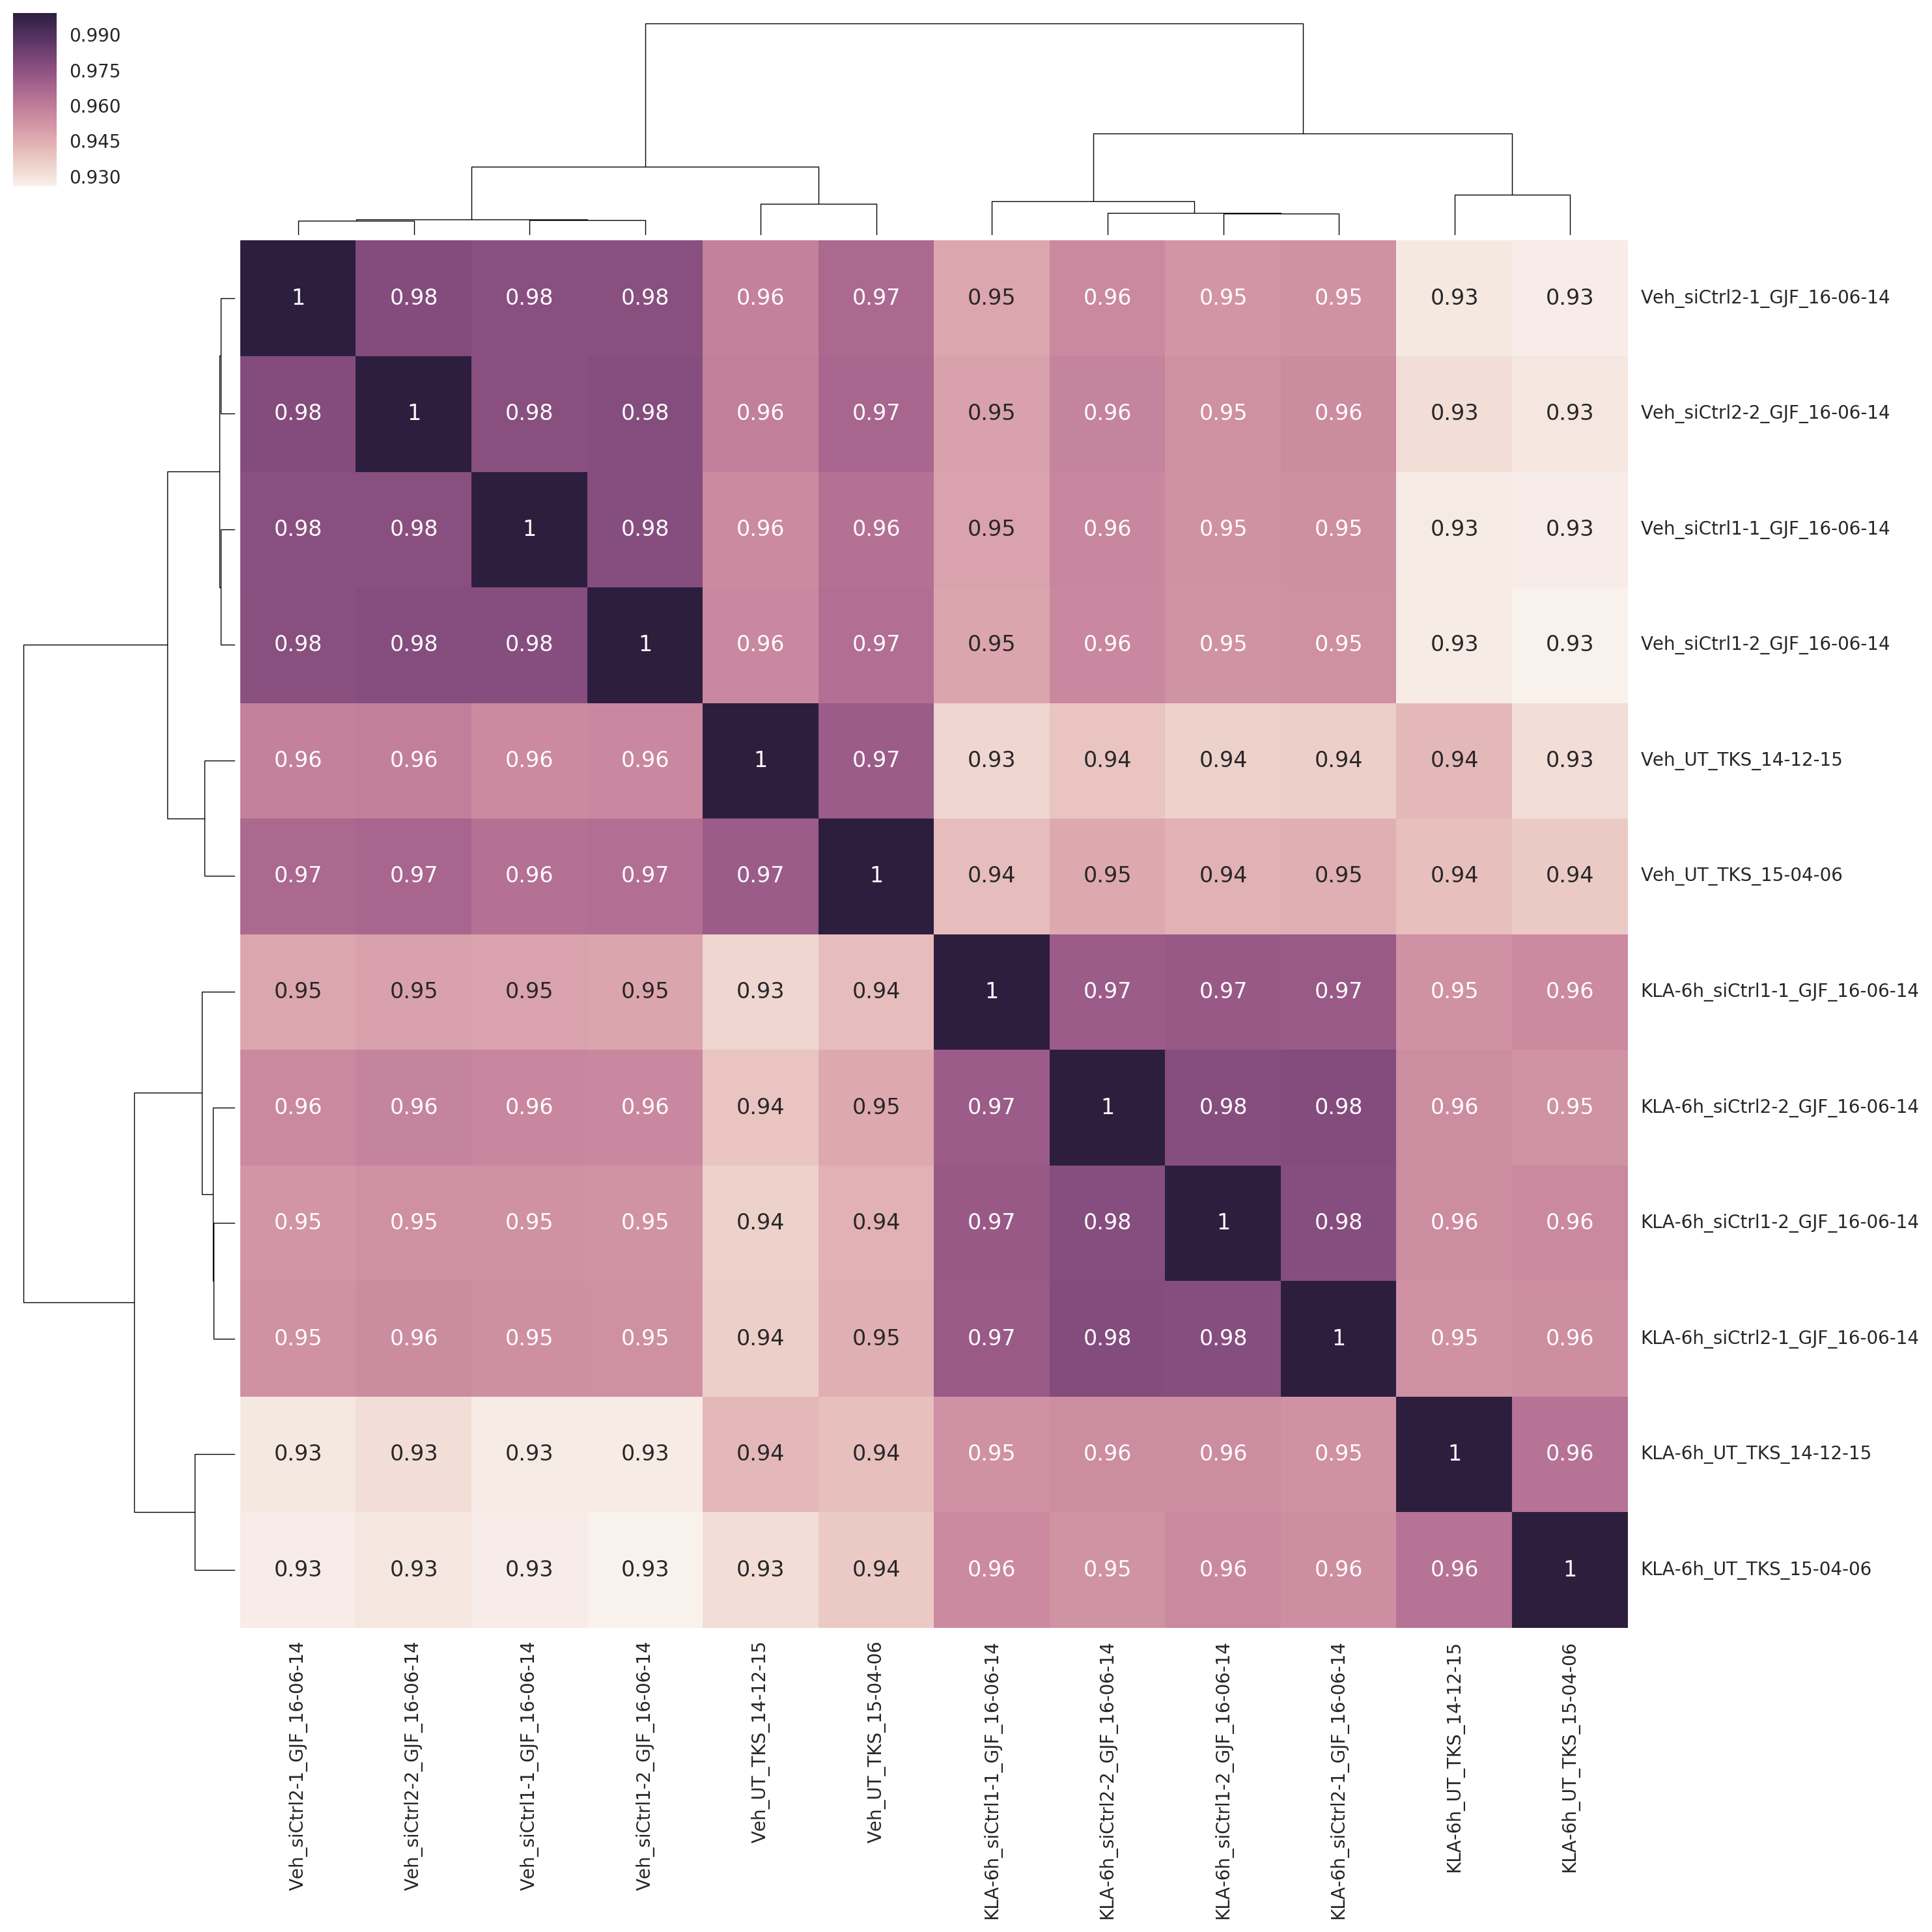

In [50]:
calcSpearmanCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and not '-1h' in x], 
                True)

#### Vehicle

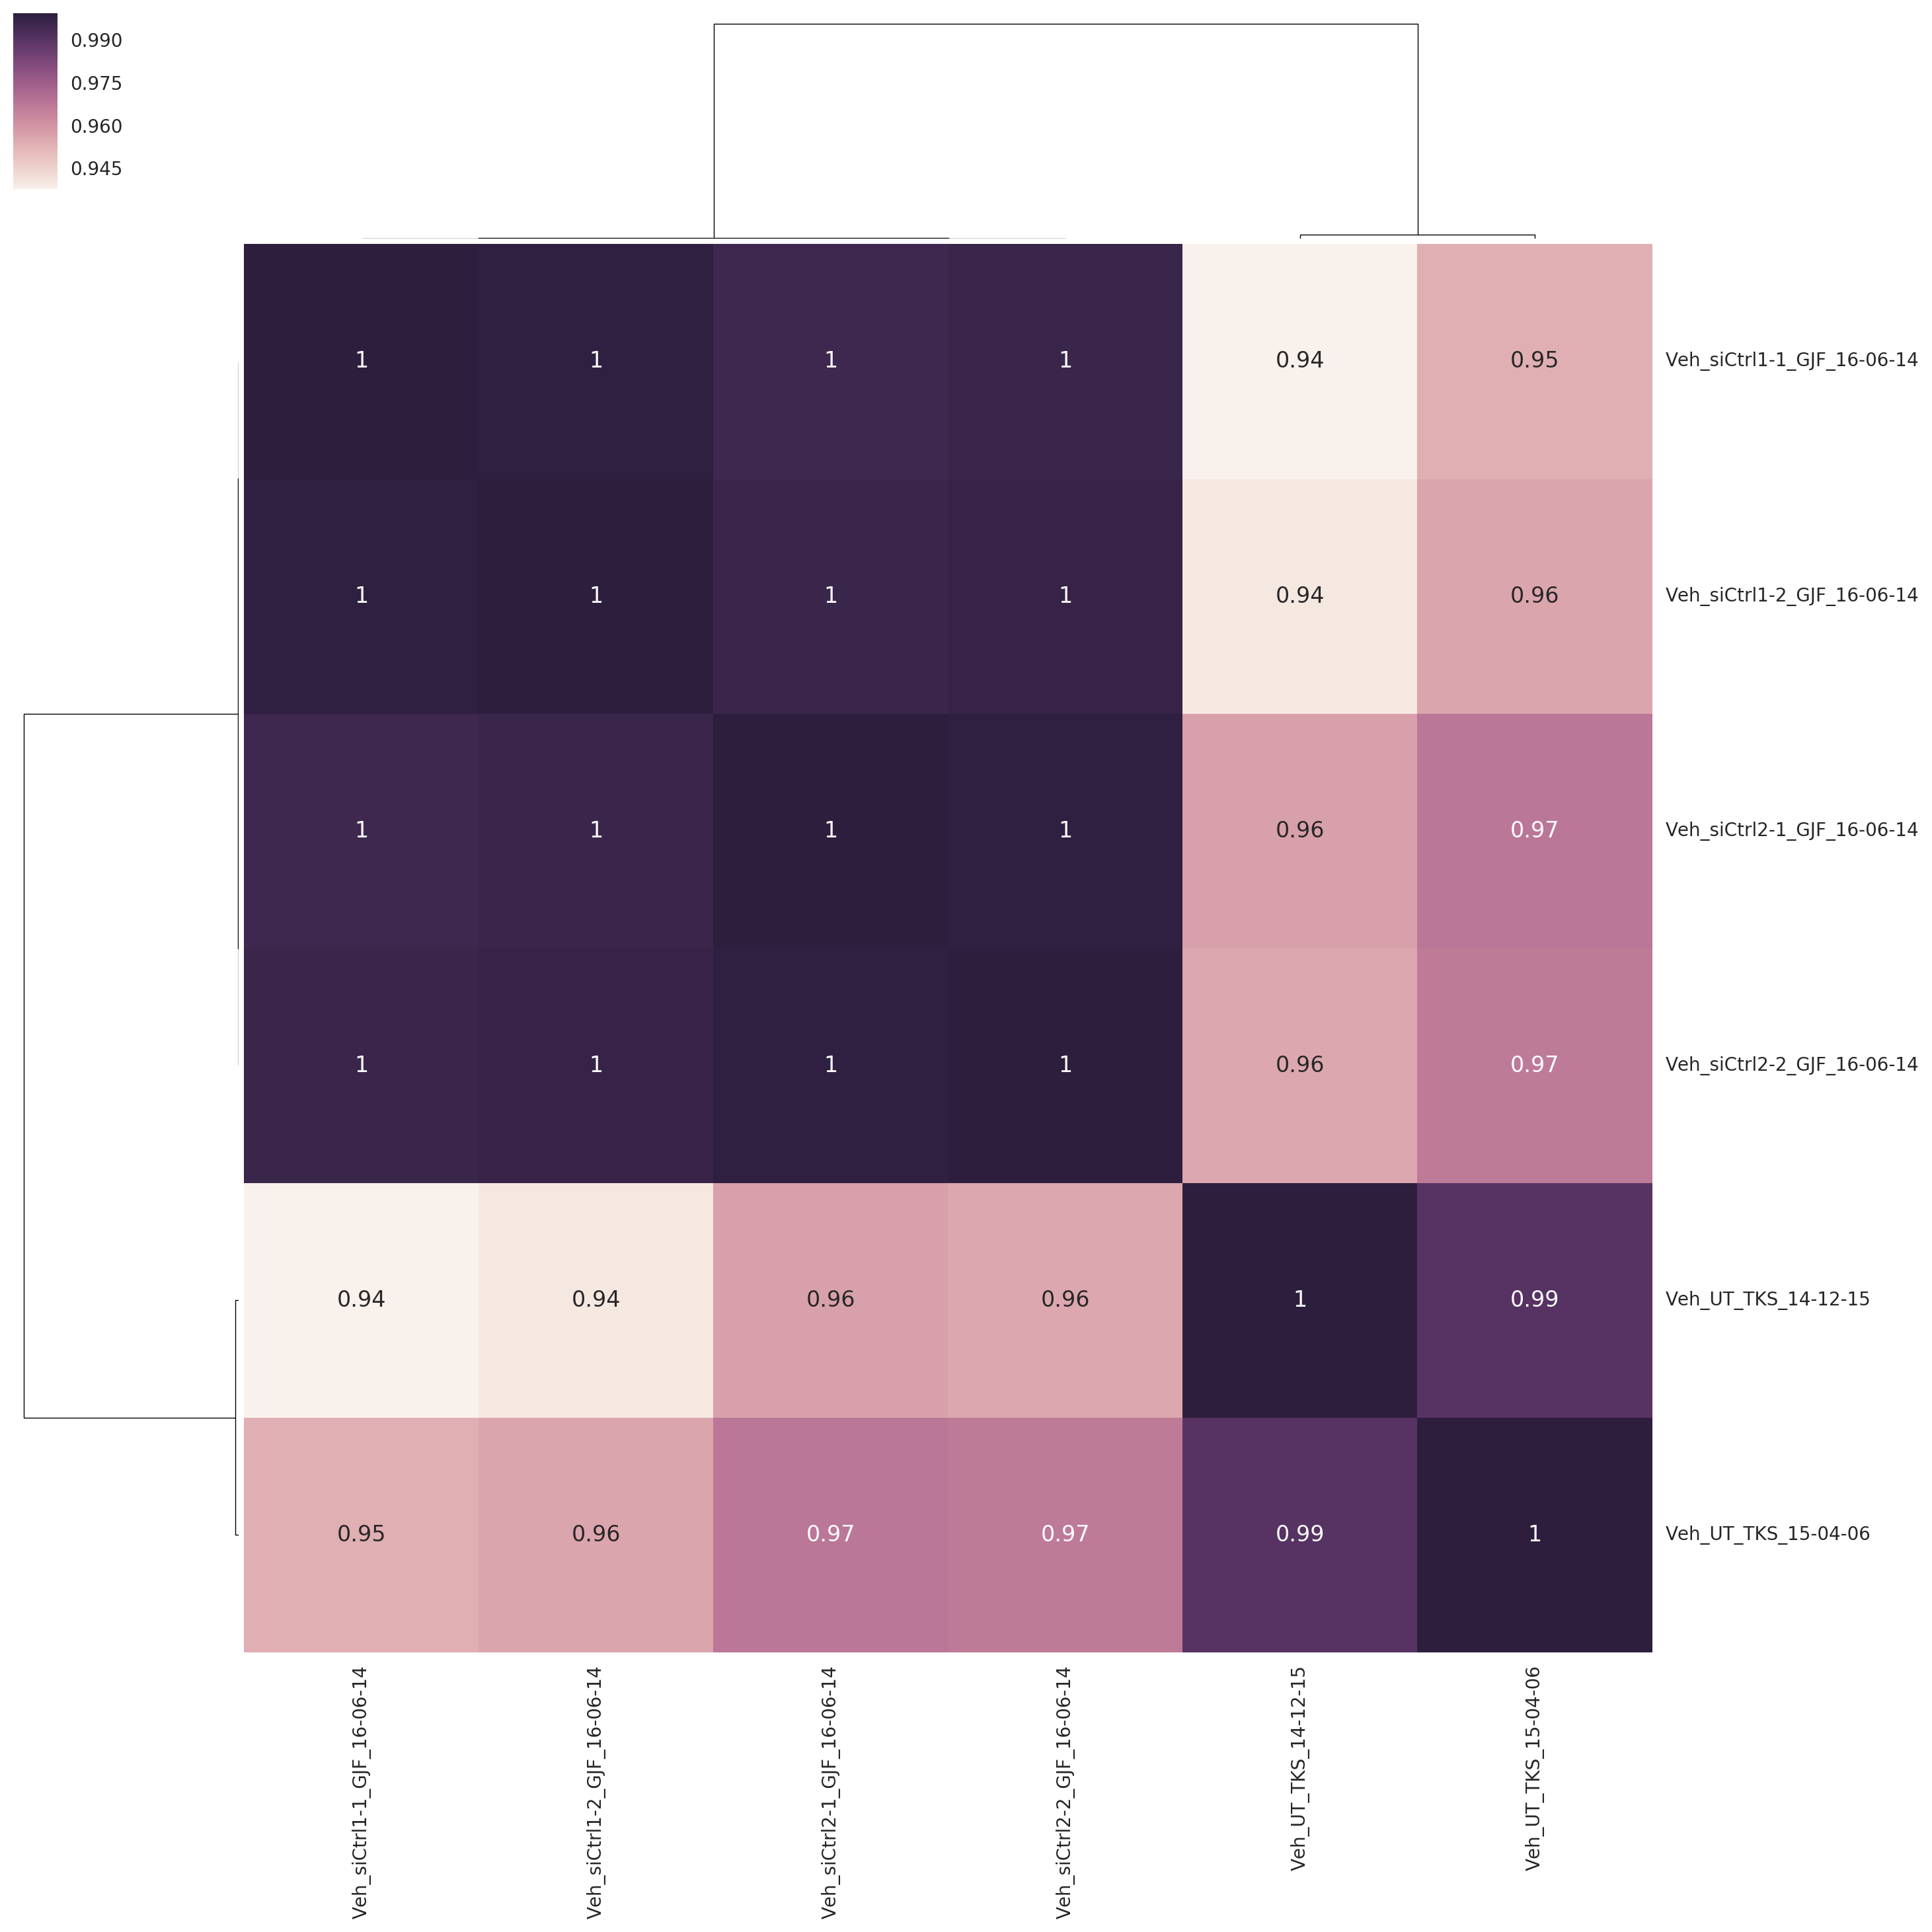

In [51]:
calcCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and (not '-1h' in x and 'Veh' in x)], 
                True)

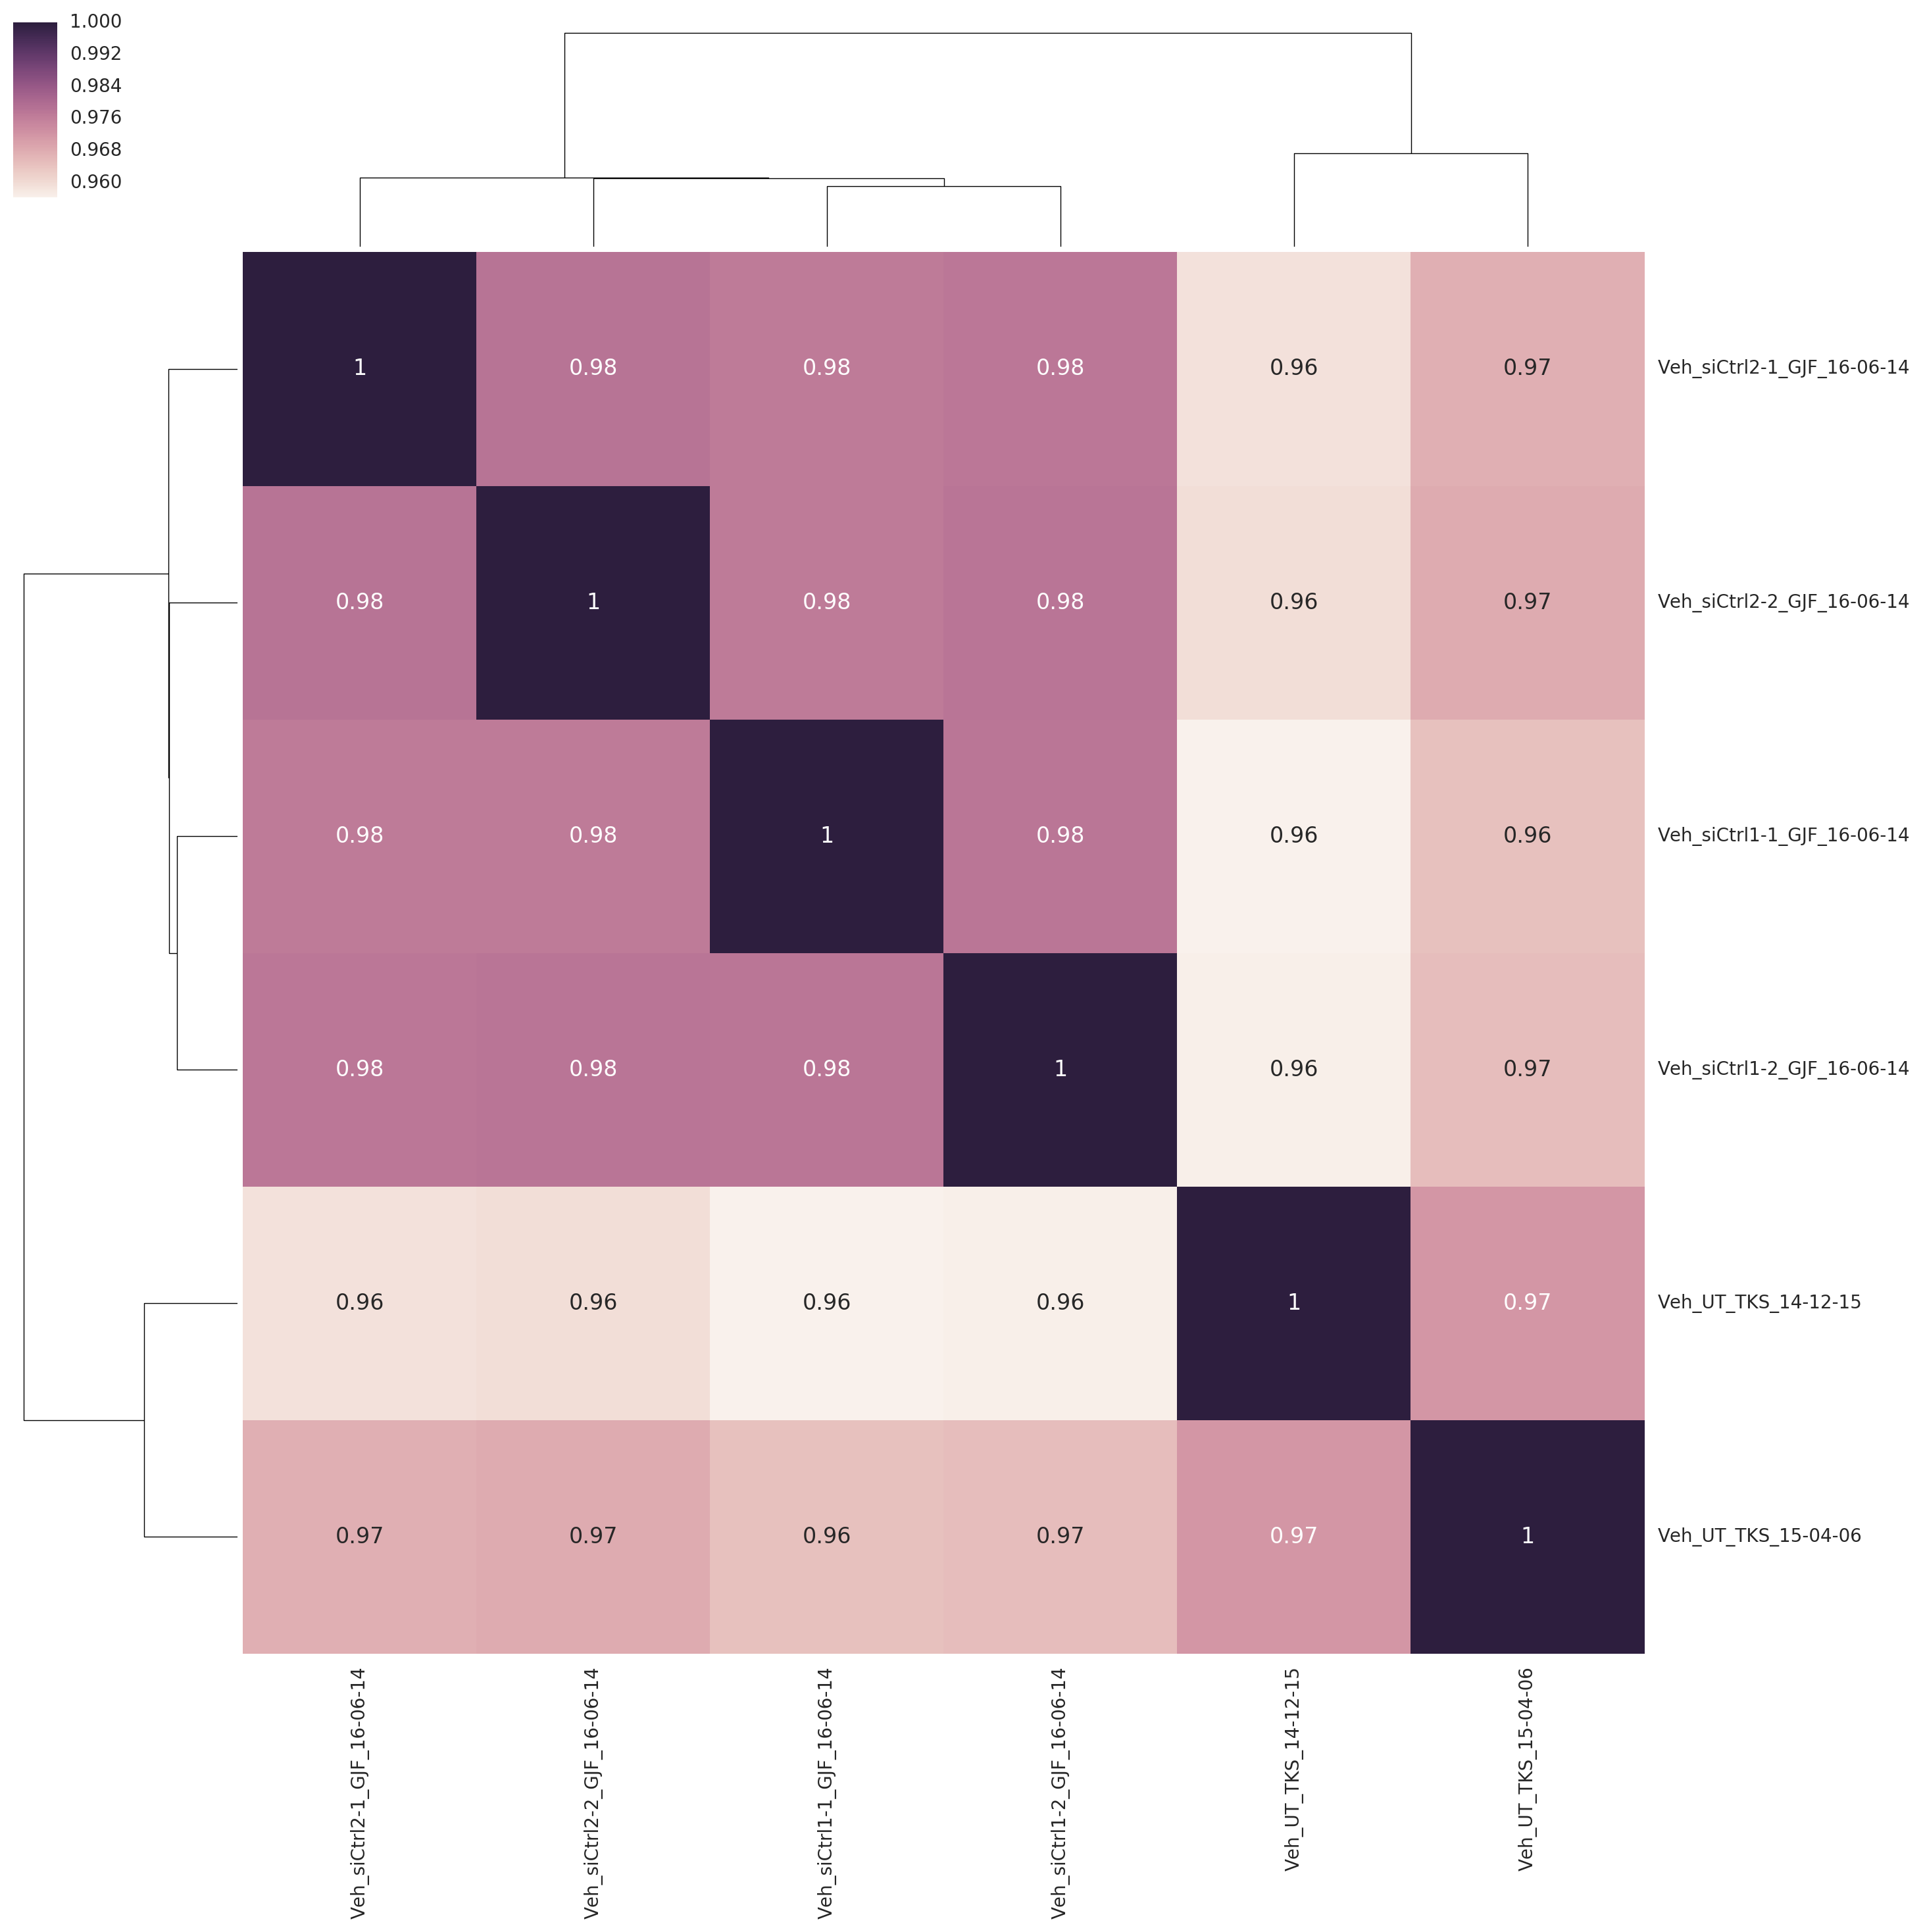

In [52]:
calcSpearmanCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and (not '-1h' in x and 'Veh' in x)], 
                True)

#### KLA

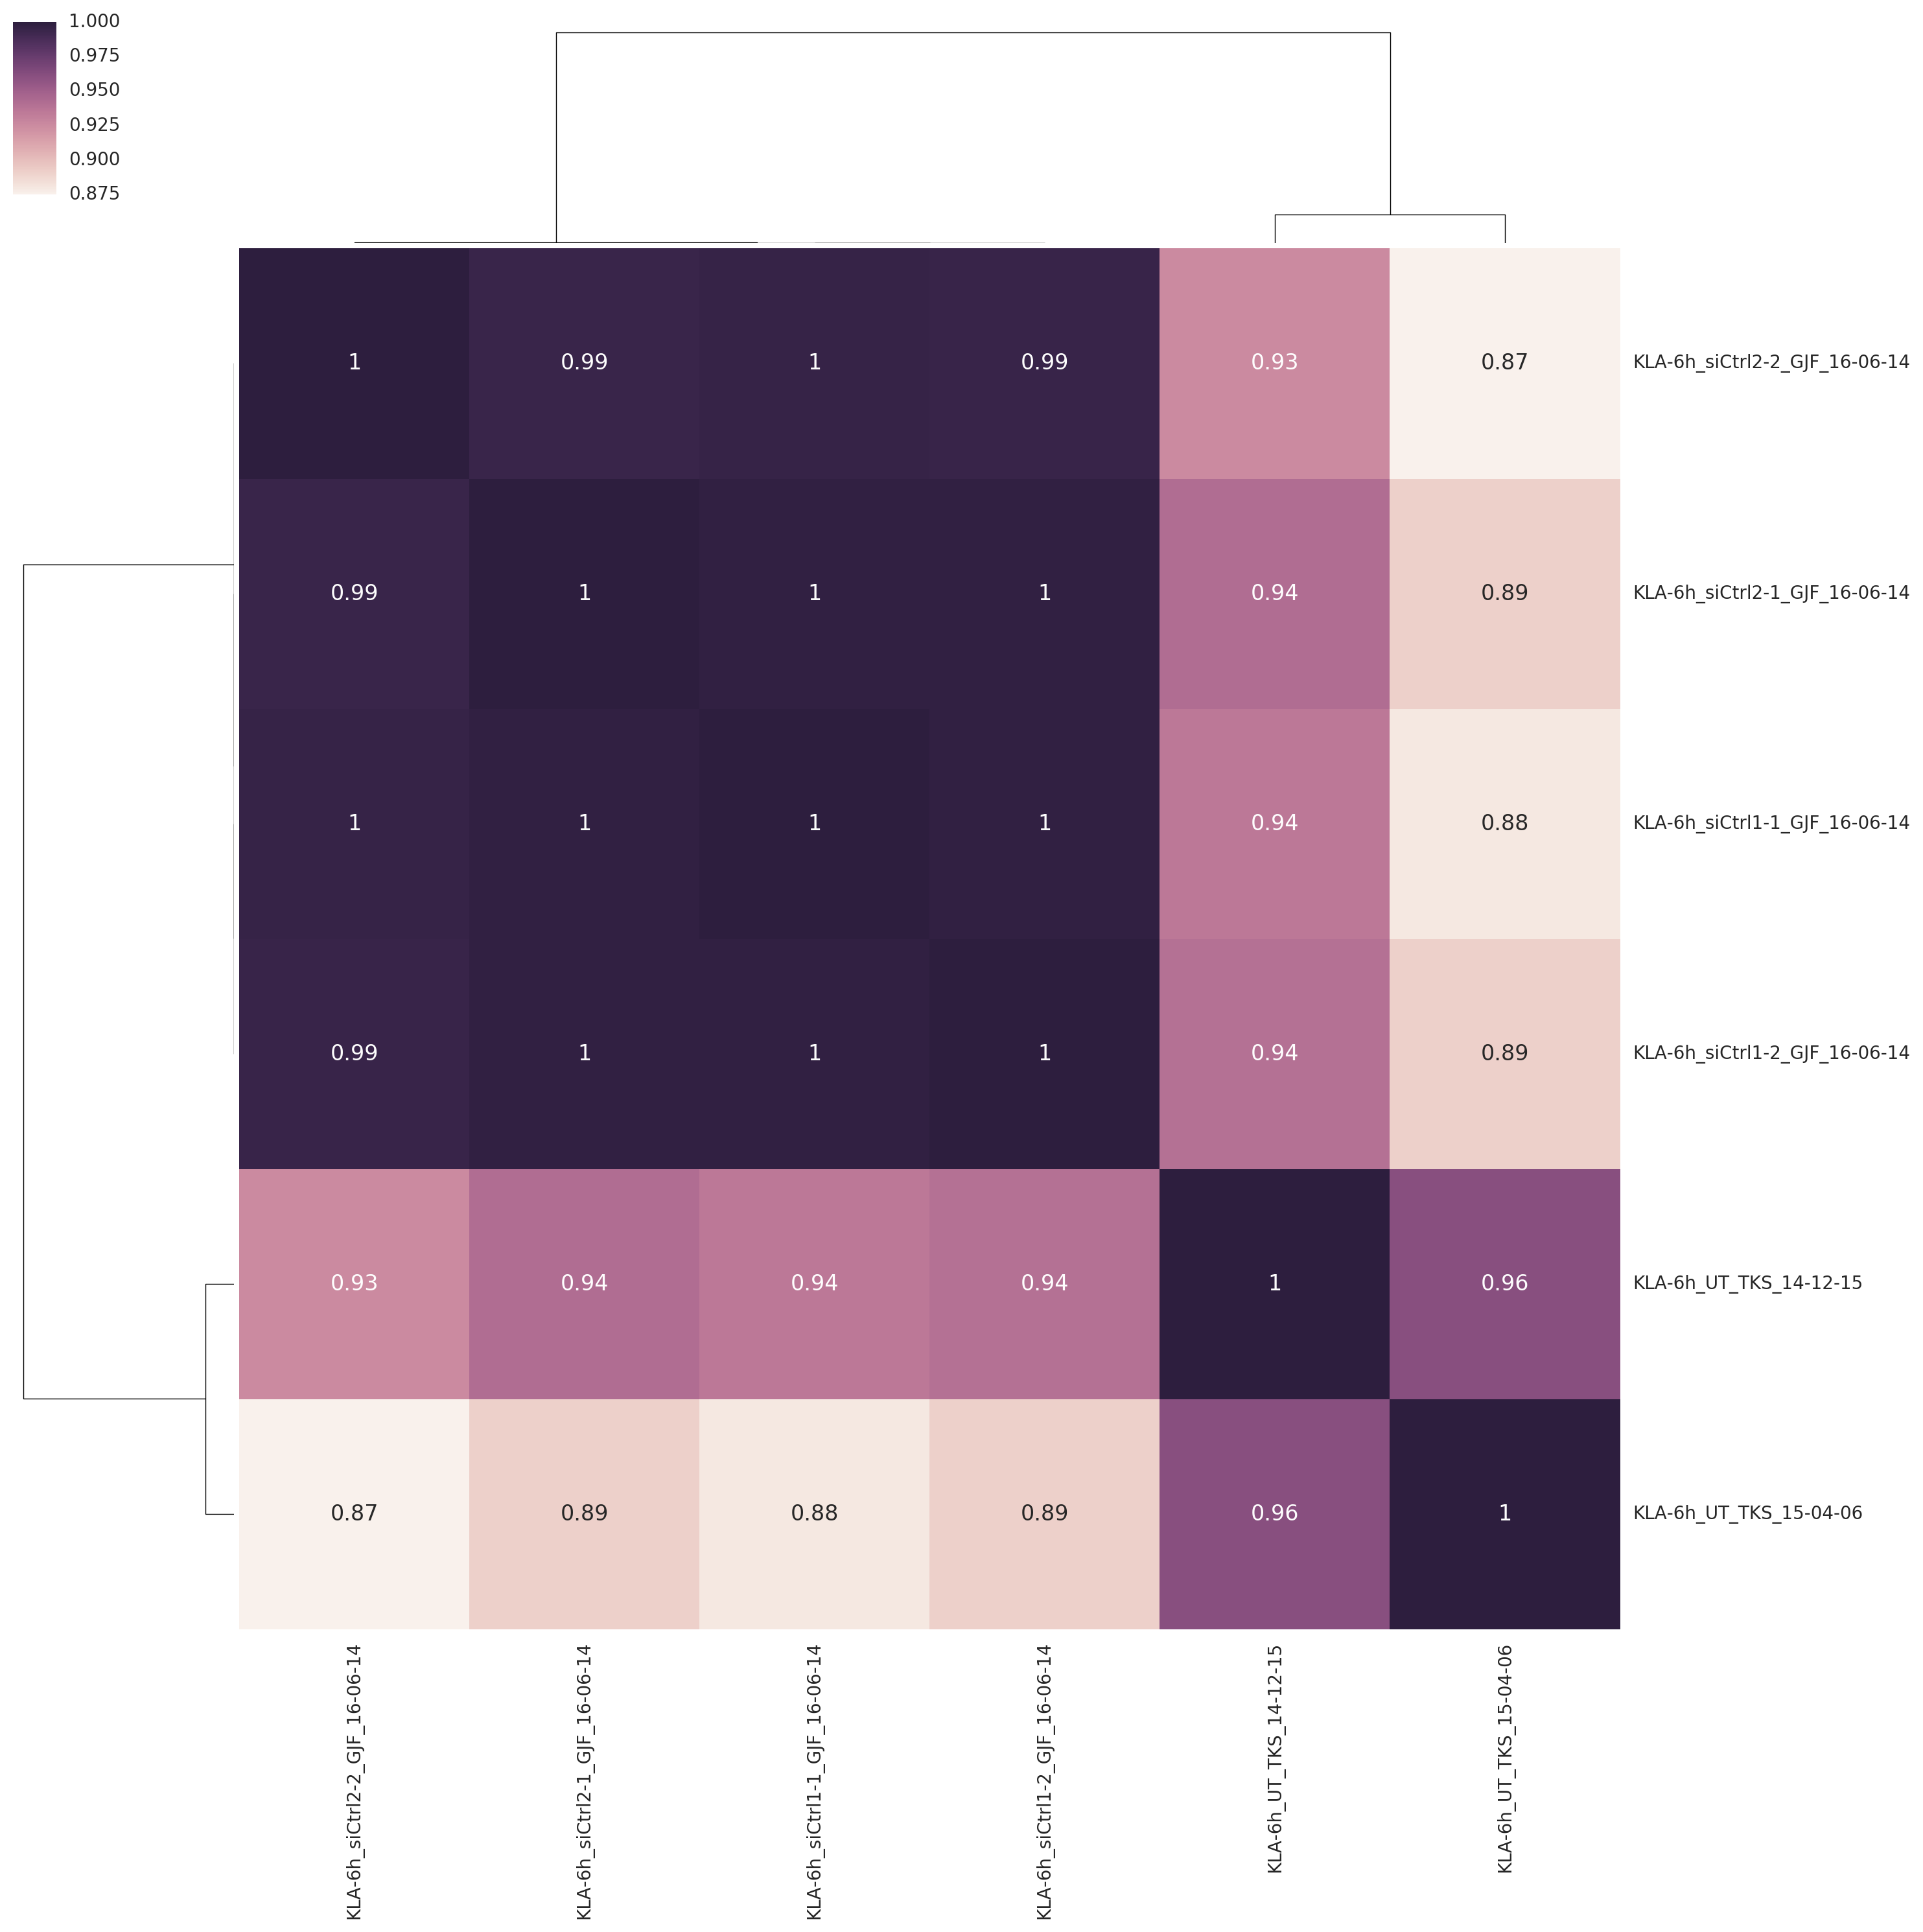

In [53]:
calcCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and (not '-1h' in x and 'KLA' in x)], 
                True)

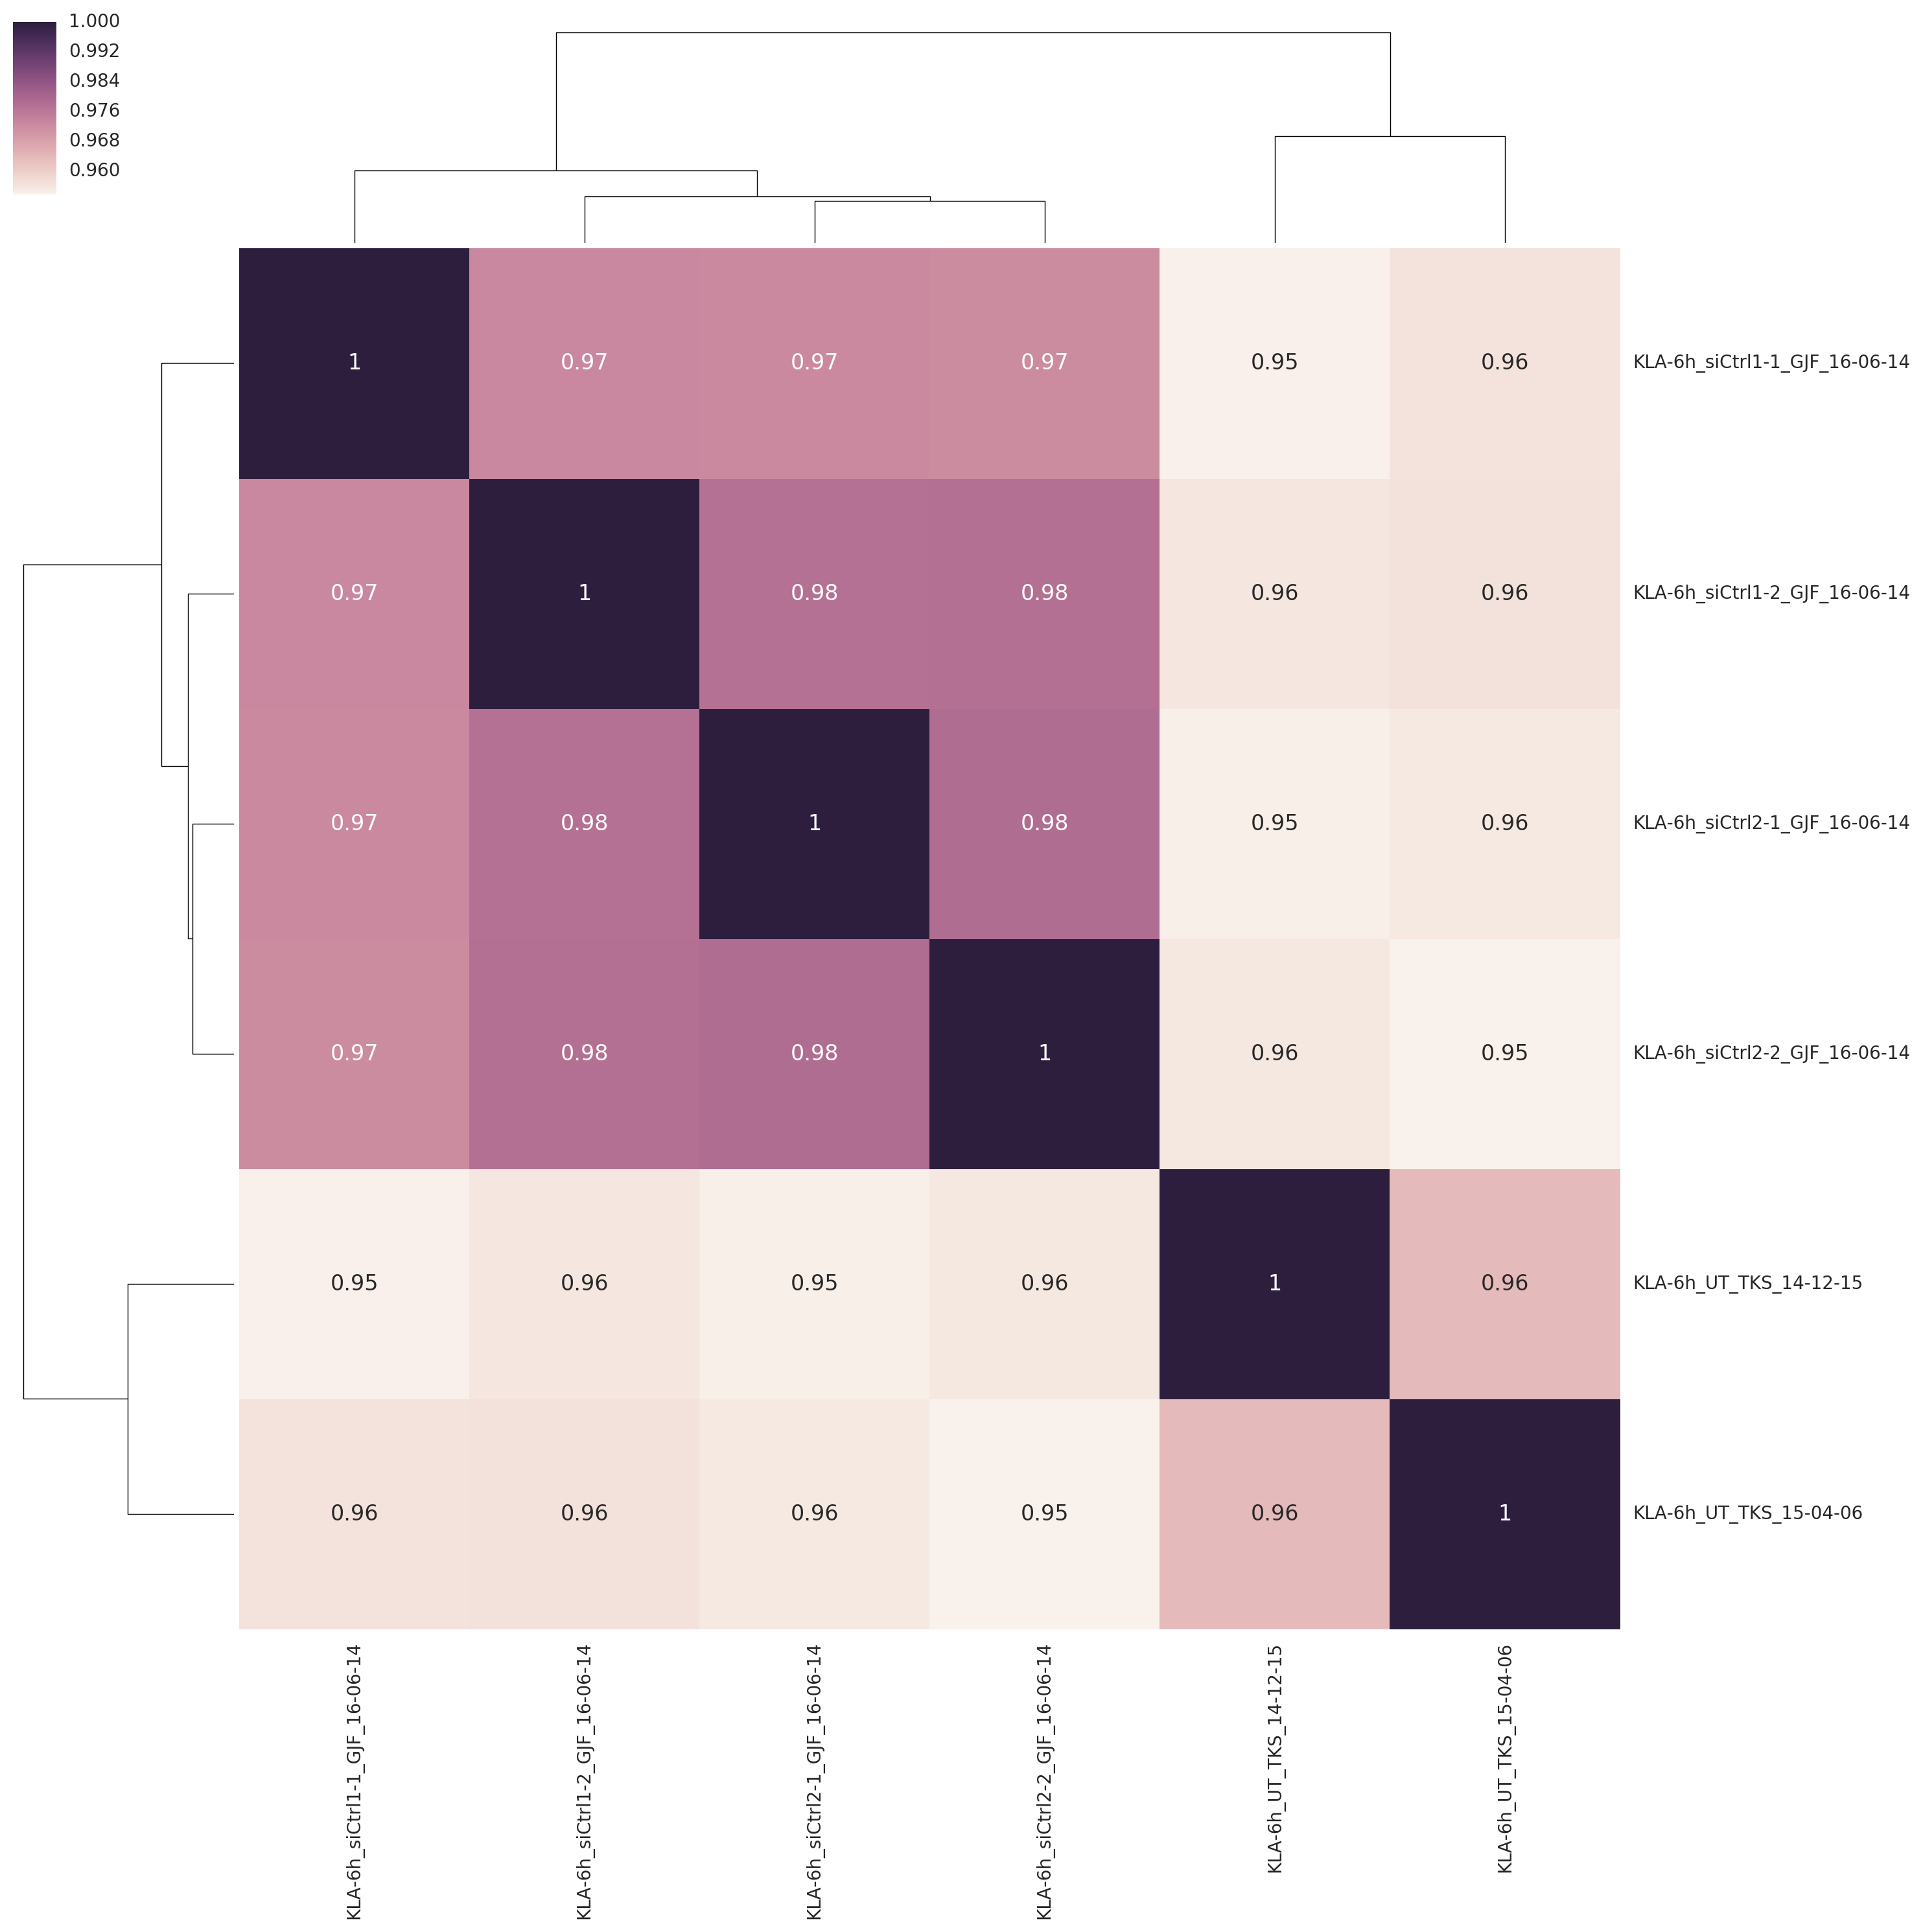

In [54]:
calcSpearmanCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and (not '-1h' in x and 'KLA' in x)], 
                True)

## Differential Expression between Untreated and siCtrl

In [27]:
samples = raw_frame.columns[9:].values
samples = [x for x in samples if 'UT' in x or 'siCtrl' in x]
# samples = [x for x in samples if 'TKS' in x or '16-06-14' in x]
samples = [x for x in samples if 'TKS' in x or 'siCtrl1' in x]
samples = [x for x in samples if 'Veh' in x]

filteredTagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in samples])

!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw_veh_control.tsv

conditions = ['_'.join(x.split('_')[3:5]) for x in samples]
conditions = [x[:-3] if 'Ctrl' in x else x for x in conditions]
conditions = ' '.join(conditions)
! getDiffExpression.pl raw_veh_control.tsv -AvsA $conditions > homer_diffExpresion_veh_control.tsv



	Tag Directories:
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_siCtrl1-1_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_siCtrl1-2_GJF_16-06-14
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_siCtrl1-1_GJF_16-06-14
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_siCtrl1-2_GJF_16-06-

In [28]:
samples = raw_frame.columns[9:].values
samples = [x for x in samples if 'UT' in x or 'siCtrl' in x]
# samples = [x for x in samples if 'TKS' in x or '16-06-14' in x]
samples = [x for x in samples if 'TKS' in x or 'siCtrl1' in x]
samples = [x for x in samples if 'KLA' in x]

filteredTagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in samples])

!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw_kla_control.tsv

conditions = ['_'.join(x.split('_')[3:5]) for x in samples]
conditions = [x[:-3] if 'Ctrl' in x else x for x in conditions]
conditions = ' '.join(conditions)
! getDiffExpression.pl raw_kla_control.tsv -AvsA $conditions > homer_diffExpresion_kla_control.tsv




	Tag Directories:
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl1-1_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl1-2_GJF_16-06-14
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_15-04-06
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl1-1_GJF_16-06-14
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA

In [61]:
samples = raw_frame.columns[9:].values
samples = [x for x in samples if 'UT' in x or 'siCtrl' in x]
# samples = [x for x in samples if 'TKS' in x or '16-06-14' in x]
samples = [x for x in samples if 'TKS' in x or 'siCtrl1' in x]

filteredTagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in samples])

!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw_control.tsv


conditions = ['_'.join(x.split('_')[3:5]) for x in samples]
conditions = [x[:-3] if 'Ctrl' in x else x for x in conditions]
conditions = ' '.join(conditions)
!getDiffExpression.pl raw_control.tsv -AvsA $conditions > homer_diffExpresion_control.tsv

	Tag Directories:
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl1-1_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_siCtrl1-1_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl1-2_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_siCtrl1-2_GJF_16-06-14
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RN

In [30]:
control_raw_frame = pd.read_csv("raw_control.tsv",sep="\t")

columns = control_raw_frame.columns.values

columns = [columns[0]] + [x.strip().split('/')[-1].split()[0] if 'tag_directories' in x else x for x in columns[1:]]
columns = [x.replace('C57Bl6_Thiomac_RNA_','') for x in columns]
control_raw_frame.columns = columns
control_raw_frame.index = [x.split('|')[0].upper() for x in control_raw_frame['Annotation/Divergence'].values]
control_raw_frame = control_raw_frame.ix[:,8:]

In [31]:
control_diff_veh_frame = pd.read_csv('homer_diffExpresion_veh_control.tsv', sep='\t')
columns = control_diff_veh_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
control_diff_veh_frame.columns=columns
control_diff_veh_frame['gene'] = [x.split('|')[0].upper() for x in control_diff_veh_frame['Divergence']]
control_diff_veh_frame.index = control_diff_veh_frame.gene.values
columns = ['refseq', 'gene'] + [x for x in control_diff_veh_frame.columns if 'vs.' in x]
control_diff_veh_frame = control_diff_veh_frame[columns]

In [32]:
control_diff_kla_frame = pd.read_csv('homer_diffExpresion_kla_control.tsv', sep='\t')
columns = control_diff_kla_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
control_diff_kla_frame.columns=columns
control_diff_kla_frame['gene'] = [x.split('|')[0].upper() for x in control_diff_kla_frame['Divergence']]
control_diff_kla_frame.index = control_diff_kla_frame.gene.values
columns = ['refseq', 'gene'] + [x for x in control_diff_kla_frame.columns if 'vs.' in x]
control_diff_kla_frame = control_diff_kla_frame[columns]

In [33]:
control_diff_frame = pd.read_csv('homer_diffExpresion_control.tsv', sep='\t')
columns = control_diff_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
control_diff_frame.columns=columns
control_diff_frame['gene'] = [x.split('|')[0].upper() for x in control_diff_frame['Divergence']]
control_diff_frame.index = control_diff_frame.gene.values
columns = ['refseq', 'gene'] + [x for x in control_diff_frame.columns if 'vs.' in x]
control_diff_frame = control_diff_frame[columns]

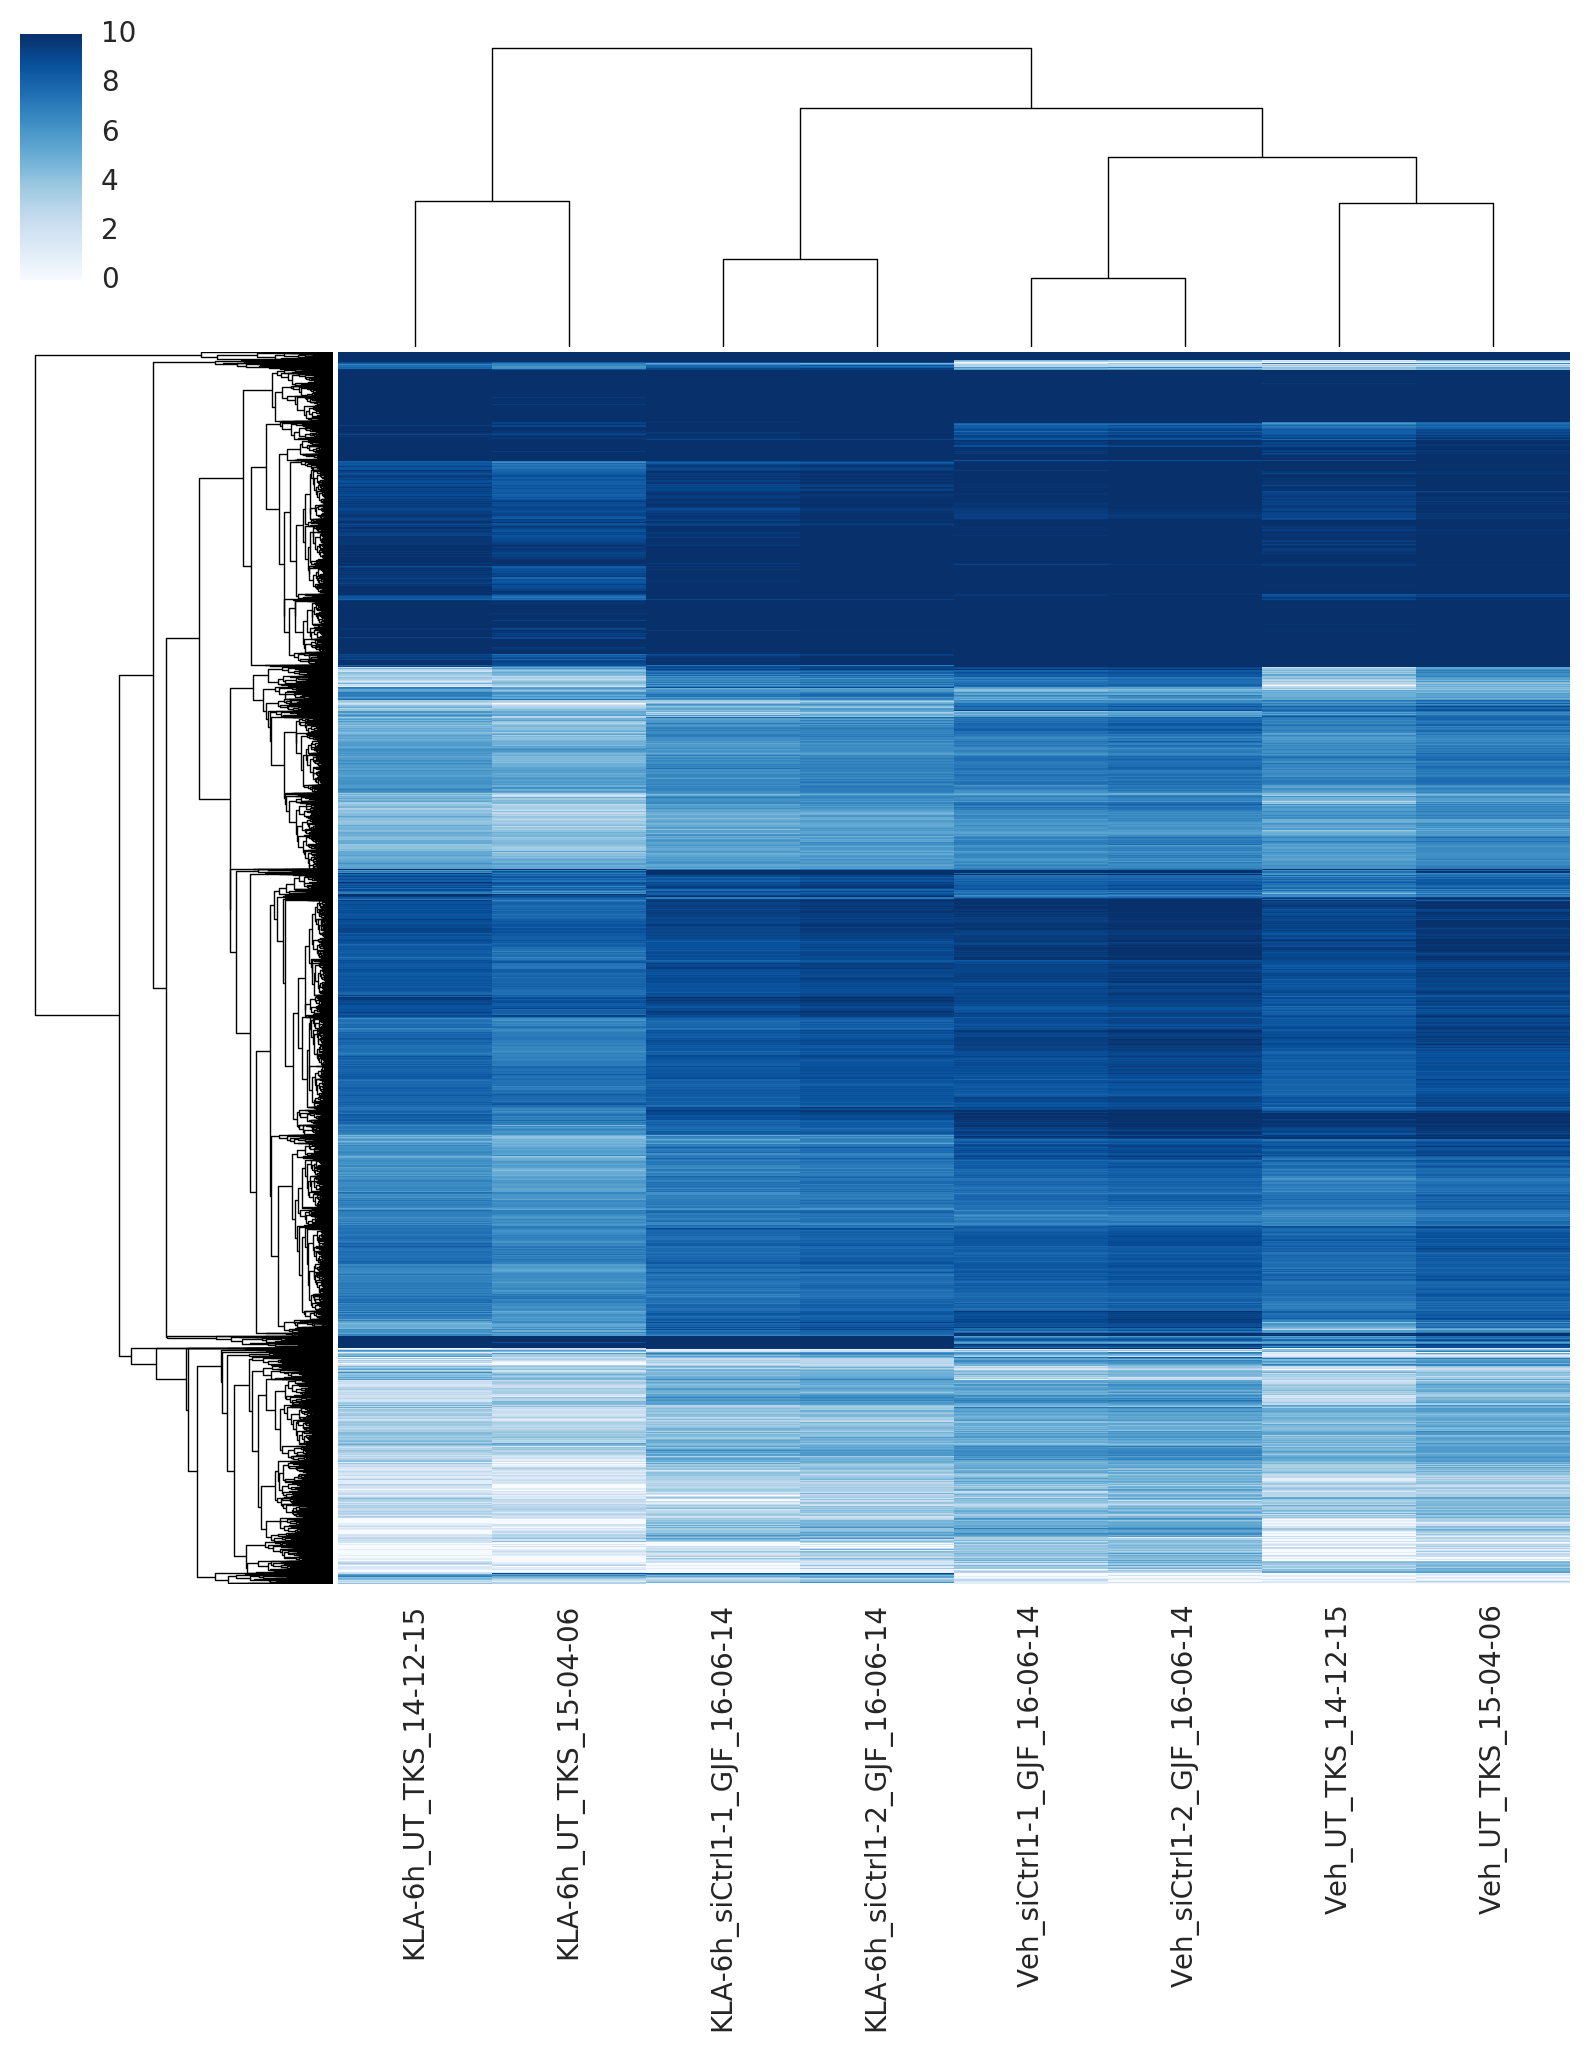

In [34]:
sns.clustermap(np.log2(control_raw_frame[(control_raw_frame.max(axis=1) > 16)]+1),
               vmax = 10,
               cmap='Blues',
               yticklabels=False)

In [35]:
p_threshold = 0.05
fold_threshold = 1
veh_genes = set(control_diff_veh_frame[(control_diff_veh_frame['Veh_UT vs. Veh_siCtrl adj. p-value'] < p_threshold) &
                                       (control_diff_veh_frame['Veh_UT vs. Veh_siCtrl Log2 Fold Change'].abs() > fold_threshold)]['gene'].values)

kla_genes = set(control_diff_kla_frame[(control_diff_kla_frame['KLA-6h_UT vs. KLA-6h_siCtrl adj. p-value'] < p_threshold) &
                                       (control_diff_kla_frame['KLA-6h_UT vs. KLA-6h_siCtrl Log2 Fold Change'].abs() > fold_threshold)]['gene'].values)

response_genes = set(control_diff_frame[(control_diff_frame['KLA-6h_UT vs. Veh_UT adj. p-value'] < p_threshold) &
                                       (control_diff_frame['KLA-6h_UT vs. Veh_UT Log2 Fold Change'].abs() > fold_threshold)]['gene'].values)

response_genes_ctrl = set(control_diff_frame[(control_diff_frame['KLA-6h_siCtrl vs. Veh_siCtrl adj. p-value'] < p_threshold) &
                                             (control_diff_frame['KLA-6h_siCtrl vs. Veh_siCtrl Log2 Fold Change'].abs() > fold_threshold)]['gene'].values)

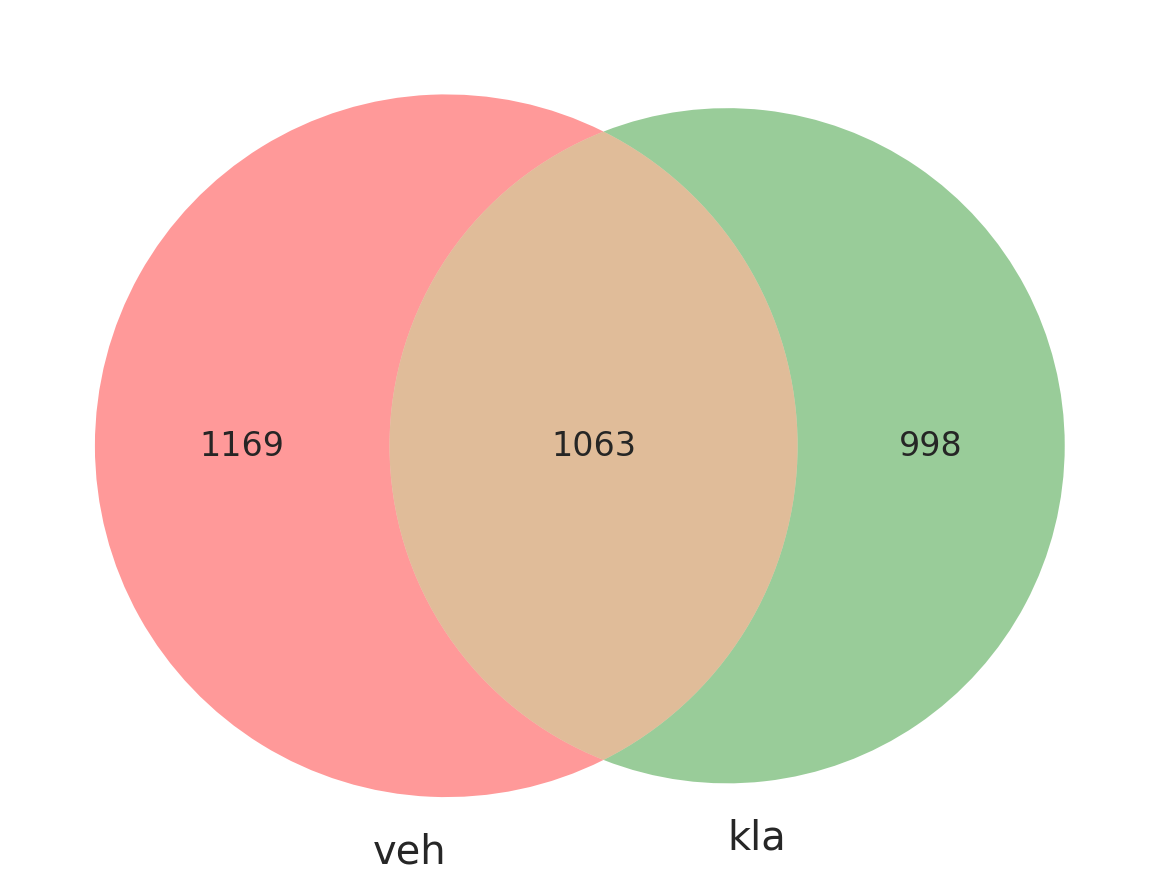

In [36]:
venn2([veh_genes,kla_genes], ['veh', 'kla'])

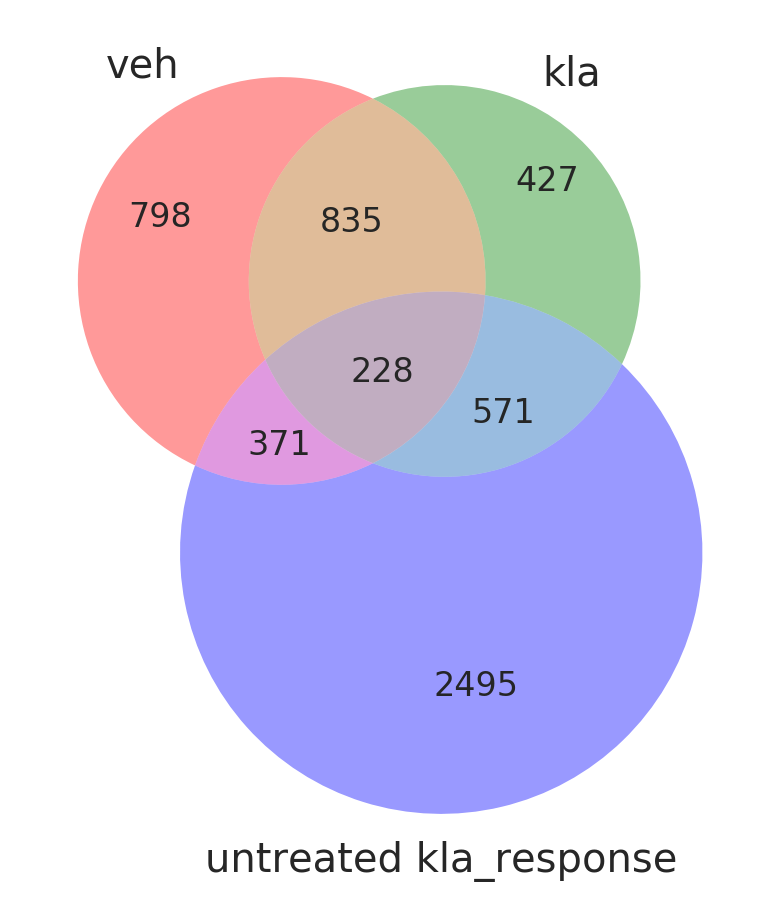

In [37]:
venn3([veh_genes,kla_genes, response_genes], ['veh', 'kla', 'untreated kla_response'])

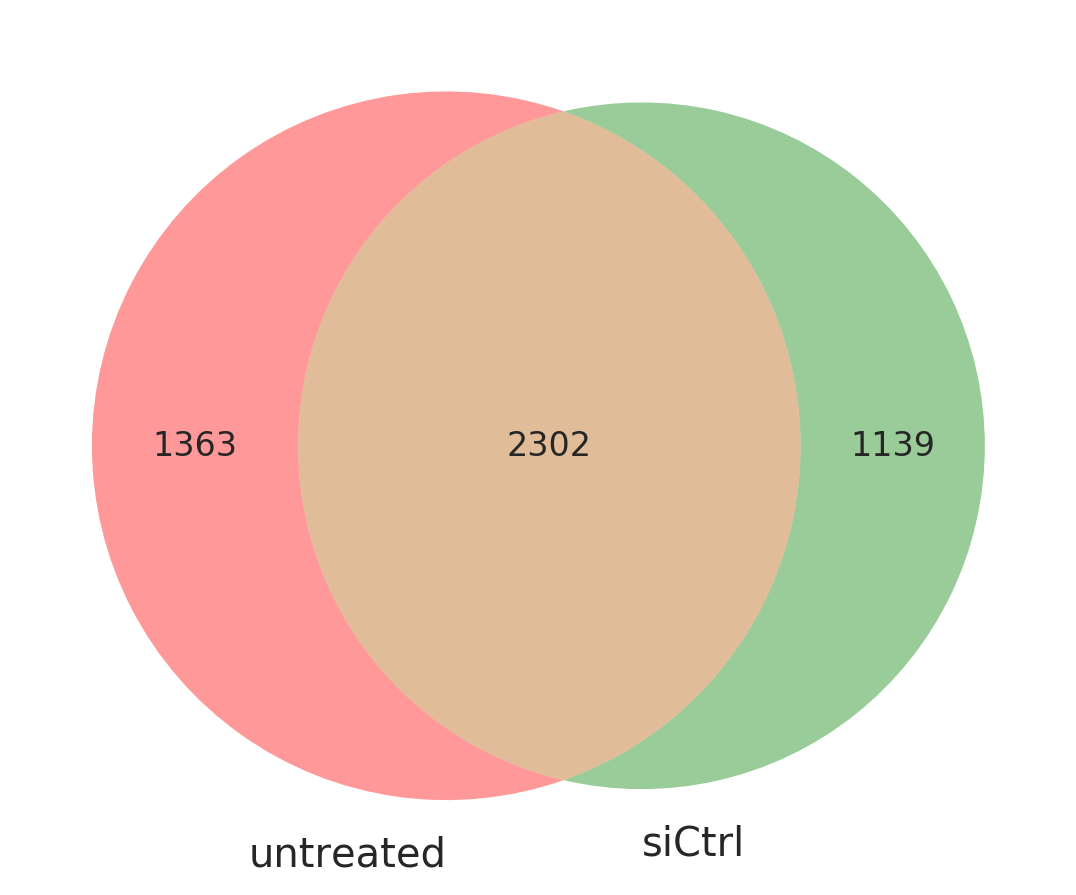

In [38]:
venn2([response_genes, response_genes_ctrl], ['untreated', 'siCtrl'])

## Calcuate Differential Expression with EdgeR

In [39]:
sample_condition_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                 filtered_summary_frame_rna['target']
                                 + '_'+ filtered_summary_frame_rna['treatment']))

In [40]:
factor_gene_dict = {'atf3':'ATF3',
                    'cjun':'JUN',
                    'fos':'FOS',
                    'junb':'JUNB',
                    'jund':'JUND'}

In [41]:
# pick replicates to use
# visualize expression of knockdown target
factors = []
treatments = []
rpkms = []

targets = [x for x in sorted(set(filtered_summary_frame_rna['target'])) if not 'UT' in x and not 'Ctrl' in x]
control_veh_samples = filtered_summary_frame_rna[filtered_summary_frame_rna['target'].str.contains('Ctrl1') &
                                                 (filtered_summary_frame_rna['treatment'] == 'Veh')]['sampleName'].values
control_kla_samples = filtered_summary_frame_rna[filtered_summary_frame_rna['target'].str.contains('Ctrl1') &
                                                 (filtered_summary_frame_rna['treatment'] == 'KLA')]['sampleName'].values
untreated_veh_samples = filtered_summary_frame_rna[filtered_summary_frame_rna['target'].str.contains('UT') &
                                                 (filtered_summary_frame_rna['treatment'] == 'Veh') &
                                                 (filtered_summary_frame_rna['owner'] == 'TKS')]['sampleName'].values
untreated_kla_samples = filtered_summary_frame_rna[filtered_summary_frame_rna['target'].str.contains('UT') &
                                                 (filtered_summary_frame_rna['treatment'] == 'KLA') &
                                                 (filtered_summary_frame_rna['owner'] == 'TKS')]['sampleName'].values
for treatment in ['Veh', 'KLA']:

    for target in targets:
        factor = target[2:].lower()
        if factor in factor_gene_dict:
            samples = filtered_summary_frame_rna[(filtered_summary_frame_rna['treatment'] == treatment) &
                                                 (filtered_summary_frame_rna['target'] == target)]['sampleName'].values
    #         tagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in samples])
            if treatment == 'Veh':
                control_samples = control_veh_samples
                untreated_samples = untreated_veh_samples
            else:
                control_samples = control_kla_samples
                untreated_samples = untreated_kla_samples
        
            if len(samples) >= 2:
                # values for knockdown experiements
                current_frame = rpkm_frame[samples]
                current_rpkms = list(current_frame.ix[factor_gene_dict[factor]].values)
                
                rpkms = rpkms + current_rpkms
                treatments = treatments + len(samples) * [treatment + ' Knockdown']
                factors = factors + len(samples) * [factor]
                
                # values for untreated samples
                current_frame = rpkm_frame[untreated_samples]
                current_rpkms = list(current_frame.ix[factor_gene_dict[factor]].values)
                rpkms = rpkms + current_rpkms
                treatments = treatments + len(untreated_samples) * [treatment + ' Untreated']
                factors = factors + len(untreated_samples) * [factor]
                
                # values for scramble control
                current_frame = rpkm_frame[control_samples]
                current_rpkms = list(current_frame.ix[factor_gene_dict[factor]].values)
                rpkms = rpkms + current_rpkms
                treatments = treatments + len(control_samples) * [treatment + ' siCtrl']
                factors = factors + len(control_samples) * [factor]
plotting_frame = pd.DataFrame({'RPKM':rpkms,
                               'Log2 RPKM': np.log2(np.array(rpkms)+1),
                               'Treatment':treatments,
                               'Factor':factors})

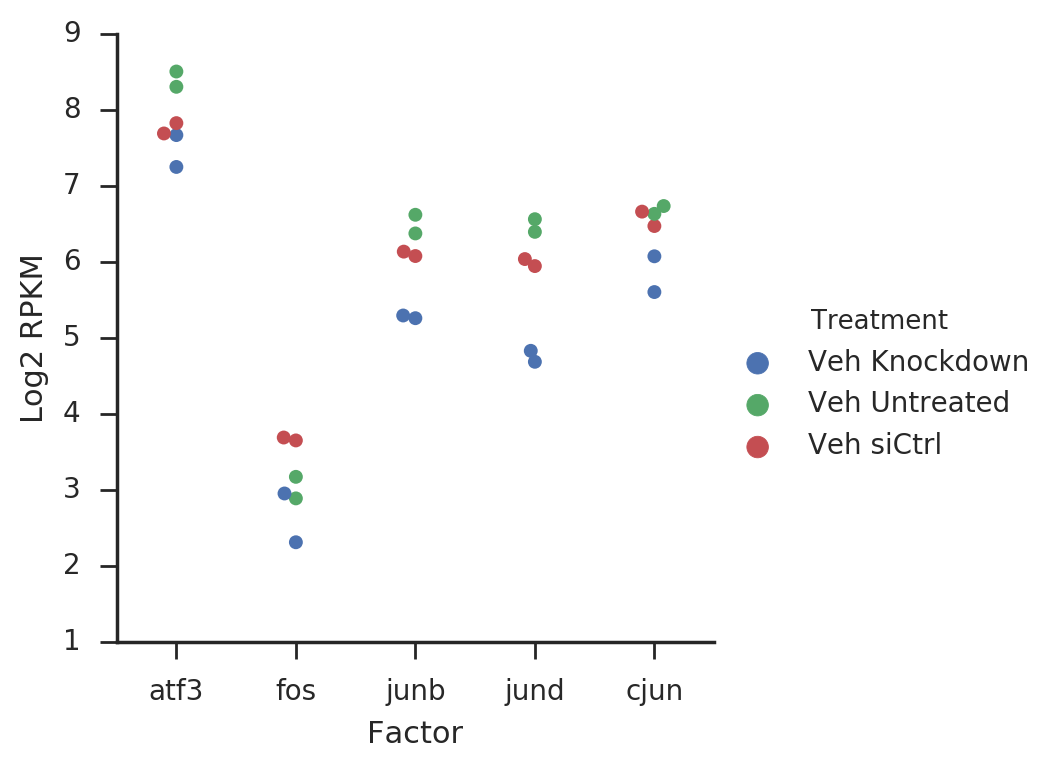

In [42]:
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame[plotting_frame['Treatment'].str.contains('Veh')],
                   kind = 'swarm',
                   x = 'Factor',
                   y = 'Log2 RPKM',
                   hue = 'Treatment')

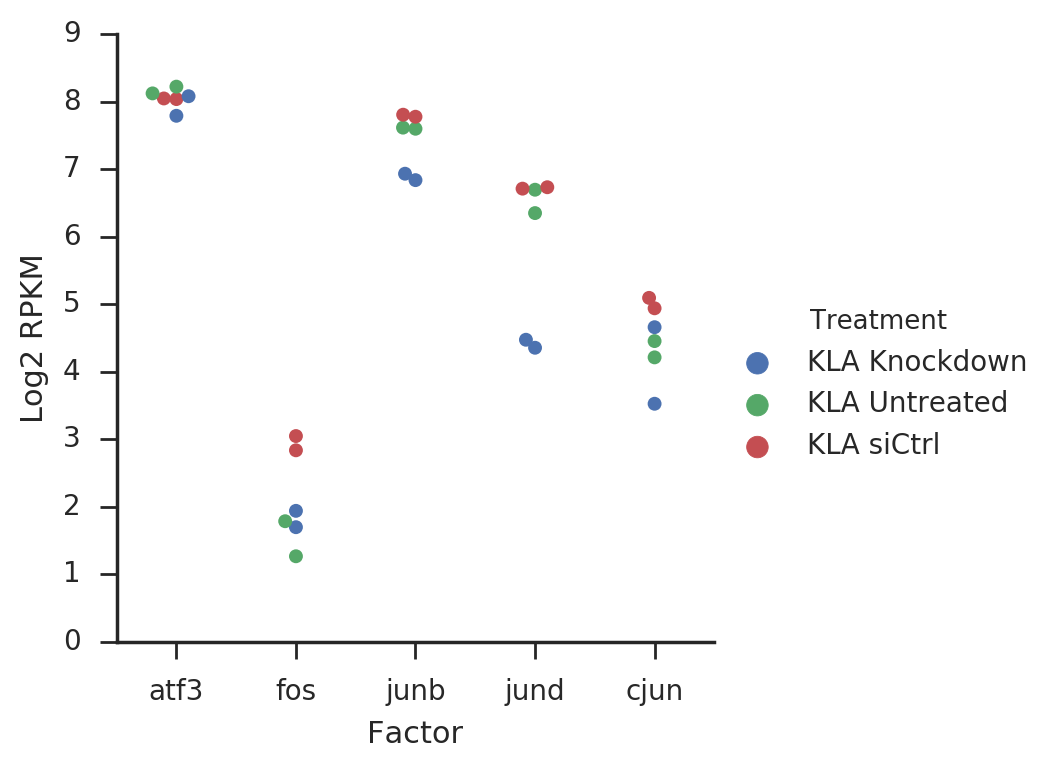

In [43]:
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame[plotting_frame['Treatment'].str.contains('KLA')],
               kind = 'swarm',
               x = 'Factor',
               y = 'Log2 RPKM',
               hue = 'Treatment')

In [59]:
samples = raw_frame.columns[9:].values

filteredTagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in samples])

conditions = ['_'.join(x.split('_')[3:5]) for x in samples]
conditions = [x[:-3] if 'Ctrl' in x else x for x in conditions]
conditions = ' '.join(conditions)
!getDiffExpression.pl raw.tsv -AvsA $conditions > homer_diffExpresion.tsv






	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats KLA-1h_UT vs. KLA-6h_UT:
		Total Genes: 24453
		Total Up-regulated in KLA-6h_UT vs. KLA-1h_UT: 945 (3.865%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-6h_UT vs. KLA-1h_UT: 666 (2.724%) [log2fold<-1, FDR<0.05]
	Output Stats KLA-1h_UT vs. Veh_UT:
		Total Genes: 24453
		Total Up-regulated in Veh_UT vs. KLA-1h_UT: 4 (0.016%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in Veh_UT vs. KLA-1h_UT: 183 (0.748%) [log2fold<-1, FDR<0.05]
	Output Stats KLA-1h_UT vs. KLA-6h_siATF3:
		Total Genes: 24453
		Total Up-regulated in KLA-6h_siATF3 vs. KLA-1h_UT: 113 (0.462%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-6h_siATF3 vs. KLA-1h_UT: 20 (0.082%) [log2fold<-1, FDR<0.05]
	Output Stats KLA-1h_UT vs. Veh_siATF3:
		Total Genes: 24453
		Total Up-regulated in Veh_siATF3 vs. KLA-1h_UT: 116 (0.474%) [log2

In [64]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_frame['Divergence']]
diffExpression_frame.index = diffExpression_frame.gene.values
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

In [122]:
fold_threshold = np.log2(2) # magnitude of cutoff to use for diff expressed genes
p_threshold = 0.05 # FDR adjusted p-value threshold

condition_genes_up_dict = {} # {treatment_target:set(genes)}
condition_genes_down_dict = {} # {treatment_target:set(genes)}


targets = [x for x in sorted(set(filtered_summary_frame_rna['target'])) if not 'UT' in x and not 'Ctrl' in x]
columns = diffExpression_frame.columns.values
for treatment in ['Veh', 'KLA-6h']:
    untreated_condition = treatment + '_UT'
    control_condition = treatment + '_siCtrl'
    for target in targets:
        print(treatment, target)
        # figure out which columns to use in EdgeR results
        target_condition = treatment + '_' + target
        if target_condition + ' vs. ' + untreated_condition + ' adj. p-value' in columns:
            untreated_comparison = target_condition + ' vs. ' + untreated_condition
            untreated_first = False
        elif untreated_condition + ' vs. ' + target_condition + ' adj. p-value' in columns:
            untreated_comparison = untreated_condition + ' vs. ' + target_condition
            untreated_first = True
            
        if target_condition + ' vs. ' + control_condition + ' adj. p-value' in columns:
            control_comparison = target_condition + ' vs. ' + control_condition
            control_first = False
        elif control_condition + ' vs. ' + target_condition + ' adj. p-value' in columns:
            control_comparison = control_condition + ' vs. ' + target_condition
            control_first = True
        
        # compute down and up-regulated genes
        if untreated_first:
            up_untreated_genes = diffExpression_frame[
                                 (diffExpression_frame[untreated_comparison + ' Log2 Fold Change'] >= fold_threshold) &
                                 (diffExpression_frame[untreated_comparison + ' adj. p-value']) <= p_threshold].index.values
            down_untreated_genes = diffExpression_frame[
                                 (diffExpression_frame[untreated_comparison + ' Log2 Fold Change'] <= -1*fold_threshold) &
                                 (diffExpression_frame[untreated_comparison + ' adj. p-value']) <= p_threshold].index.values
        else:
            down_untreated_genes = diffExpression_frame[
                                 (diffExpression_frame[untreated_comparison + ' Log2 Fold Change'] >= fold_threshold) &
                                 (diffExpression_frame[untreated_comparison + ' adj. p-value'] <= p_threshold)].index.values
            up_untreated_genes = diffExpression_frame[
                                 (diffExpression_frame[untreated_comparison + ' Log2 Fold Change'] <= -1*fold_threshold) &
                                 (diffExpression_frame[untreated_comparison + ' adj. p-value'] <= p_threshold)].index.values

        if control_first:
            up_control_genes = diffExpression_frame[
                                 (diffExpression_frame[control_comparison + ' Log2 Fold Change'] >= fold_threshold) &
                                 (diffExpression_frame[control_comparison + ' adj. p-value'] <= p_threshold)].index.values
            down_control_genes = diffExpression_frame[
                                 (diffExpression_frame[control_comparison + ' Log2 Fold Change'] <= -1*fold_threshold) &
                                 (diffExpression_frame[control_comparison + ' adj. p-value'] <= p_threshold)].index.values
        else:
            down_control_genes = diffExpression_frame[
                                 (diffExpression_frame[control_comparison + ' Log2 Fold Change'] >= fold_threshold) &
                                 (diffExpression_frame[control_comparison + ' adj. p-value'] <= p_threshold)].index.values
            up_control_genes = diffExpression_frame[
                                 (diffExpression_frame[control_comparison + ' Log2 Fold Change'] <= -1*fold_threshold) &
                                 (diffExpression_frame[control_comparison + ' adj. p-value'] <= p_threshold)].index.values

        
        # calculate intersection of genes
        
        down_genes = set(down_untreated_genes).intersection(set(down_control_genes))
        up_genes = set(up_untreated_genes).intersection(set(up_control_genes))
        
        # filter away genes 
        expressed_genes = set(idr_rpkm_mean_frame[idr_rpkm_mean_frame[[target_condition, 
                             untreated_condition, 
                             control_condition]].max(axis=1) >= 4].index.values)
        down_genes = down_genes.intersection(expressed_genes)
        up_genes = up_genes.intersection(expressed_genes)
        
        condition_genes_up_dict[target_condition] = up_genes
        condition_genes_down_dict[target_condition] = down_genes
        
        print(len(down_genes), len(up_genes))
        
        

Veh siATF3
7 35
Veh siFos
294 504
Veh siJunB
131 187
Veh siJunD
186 157
Veh sicJun
127 231
KLA-6h siATF3
1 31
KLA-6h siFos
131 169
KLA-6h siJunB
141 211
KLA-6h siJunD
134 172
KLA-6h sicJun
99 263


## Heatmap

In [173]:
veh_diff_genes = set()
kla_diff_genes = set()
for key in condition_genes_down_dict.keys():
    if 'Veh' in key:
        veh_diff_genes = veh_diff_genes.union(condition_genes_down_dict[key])
        veh_diff_genes = veh_diff_genes.union(condition_genes_up_dict[key])
    if 'KLA' in key:
        kla_diff_genes = kla_diff_genes.union(condition_genes_down_dict[key])
        kla_diff_genes = kla_diff_genes.union(condition_genes_up_dict[key])

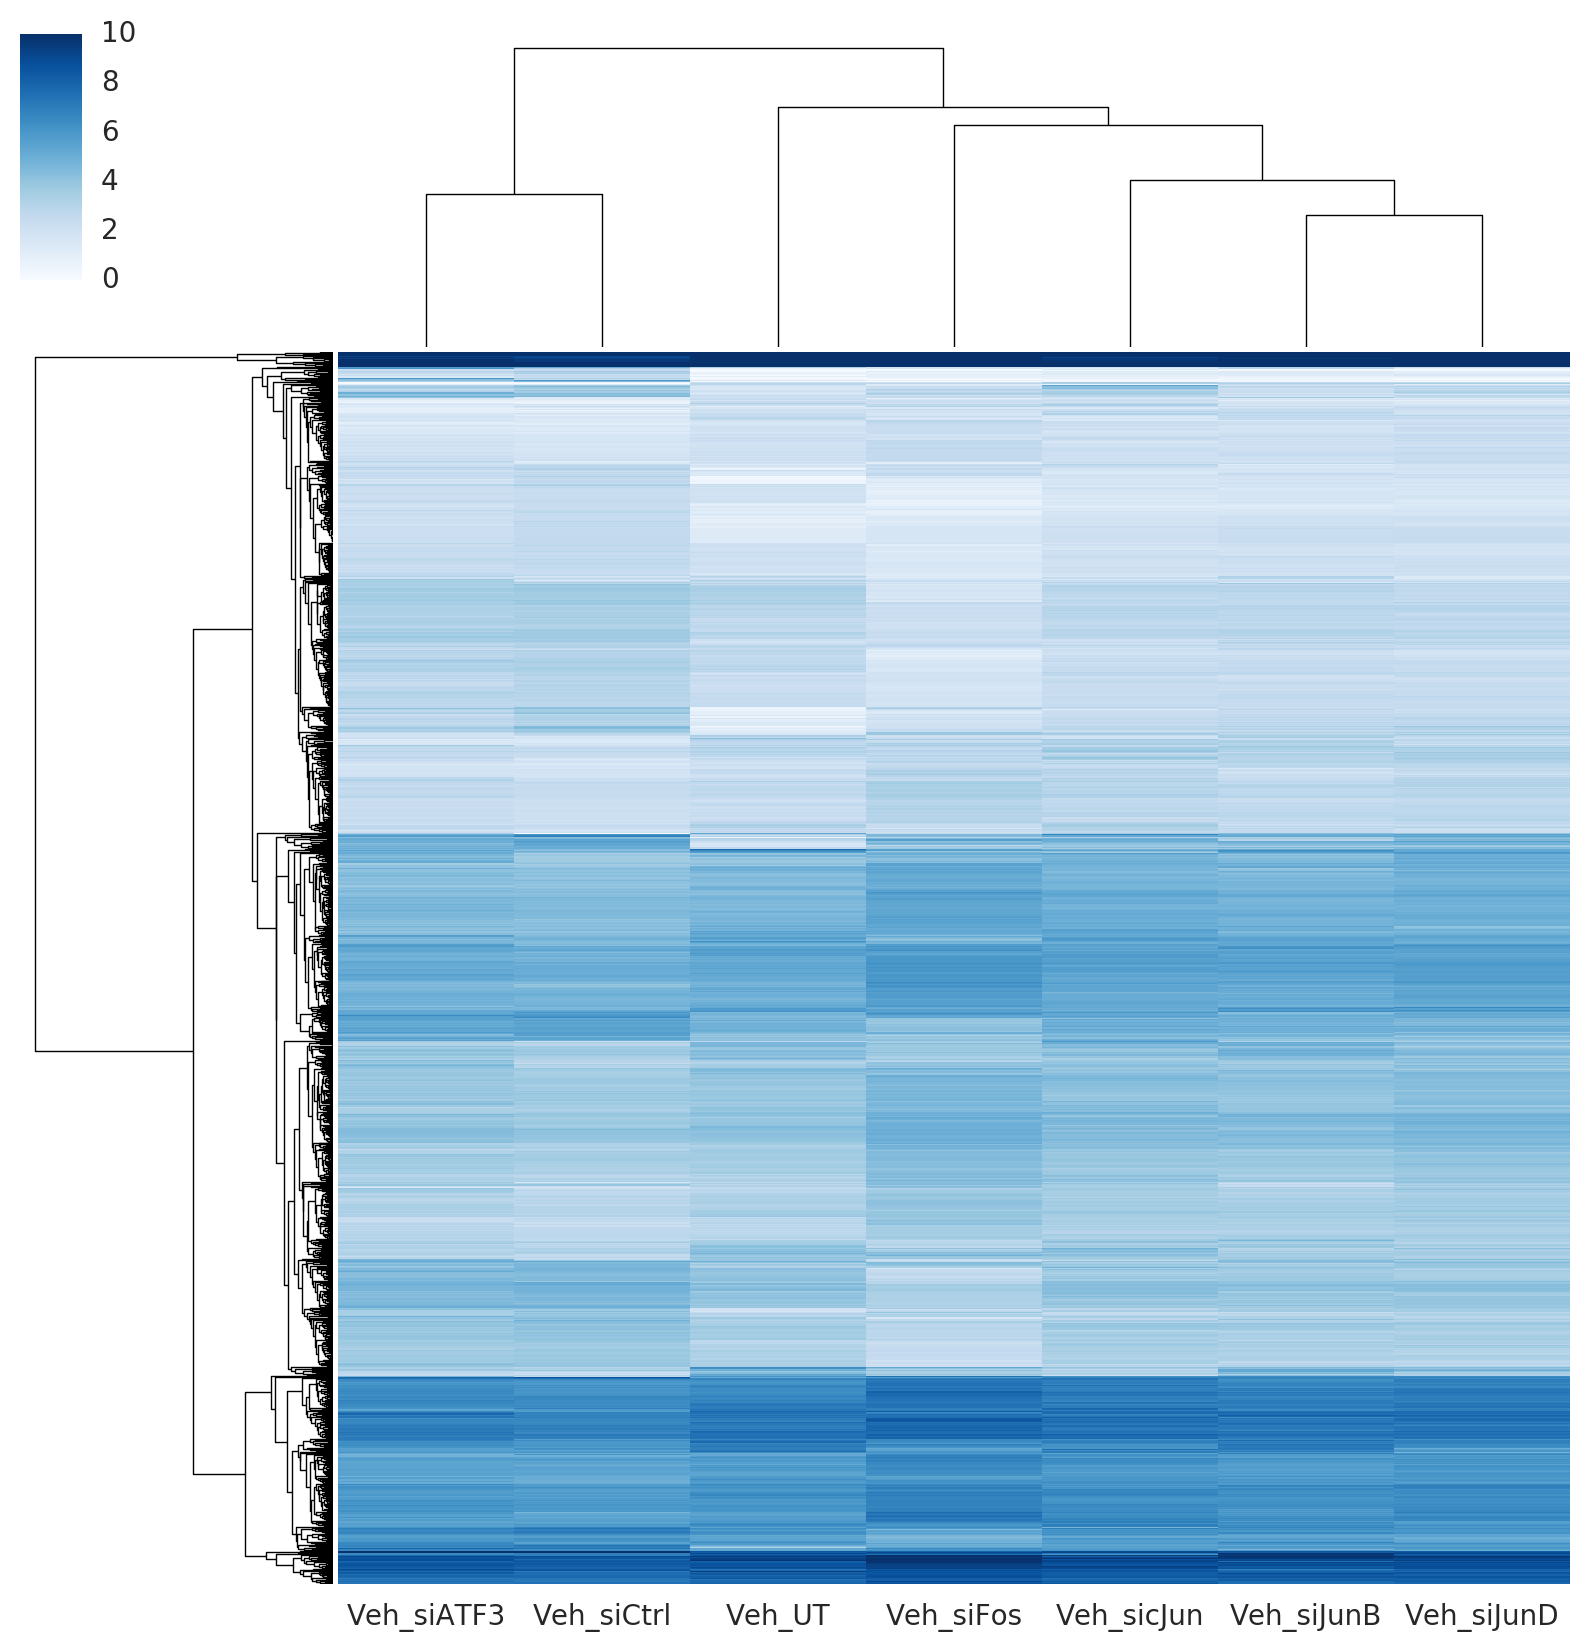

In [181]:
# vehicle genes
data = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(veh_diff_genes)][[x for x in idr_rpkm_mean_frame.columns if 'Veh' in x]]
sns.clustermap(np.log2(data + 1),
              yticklabels=False,
              vmax=10,
              cmap='Blues')

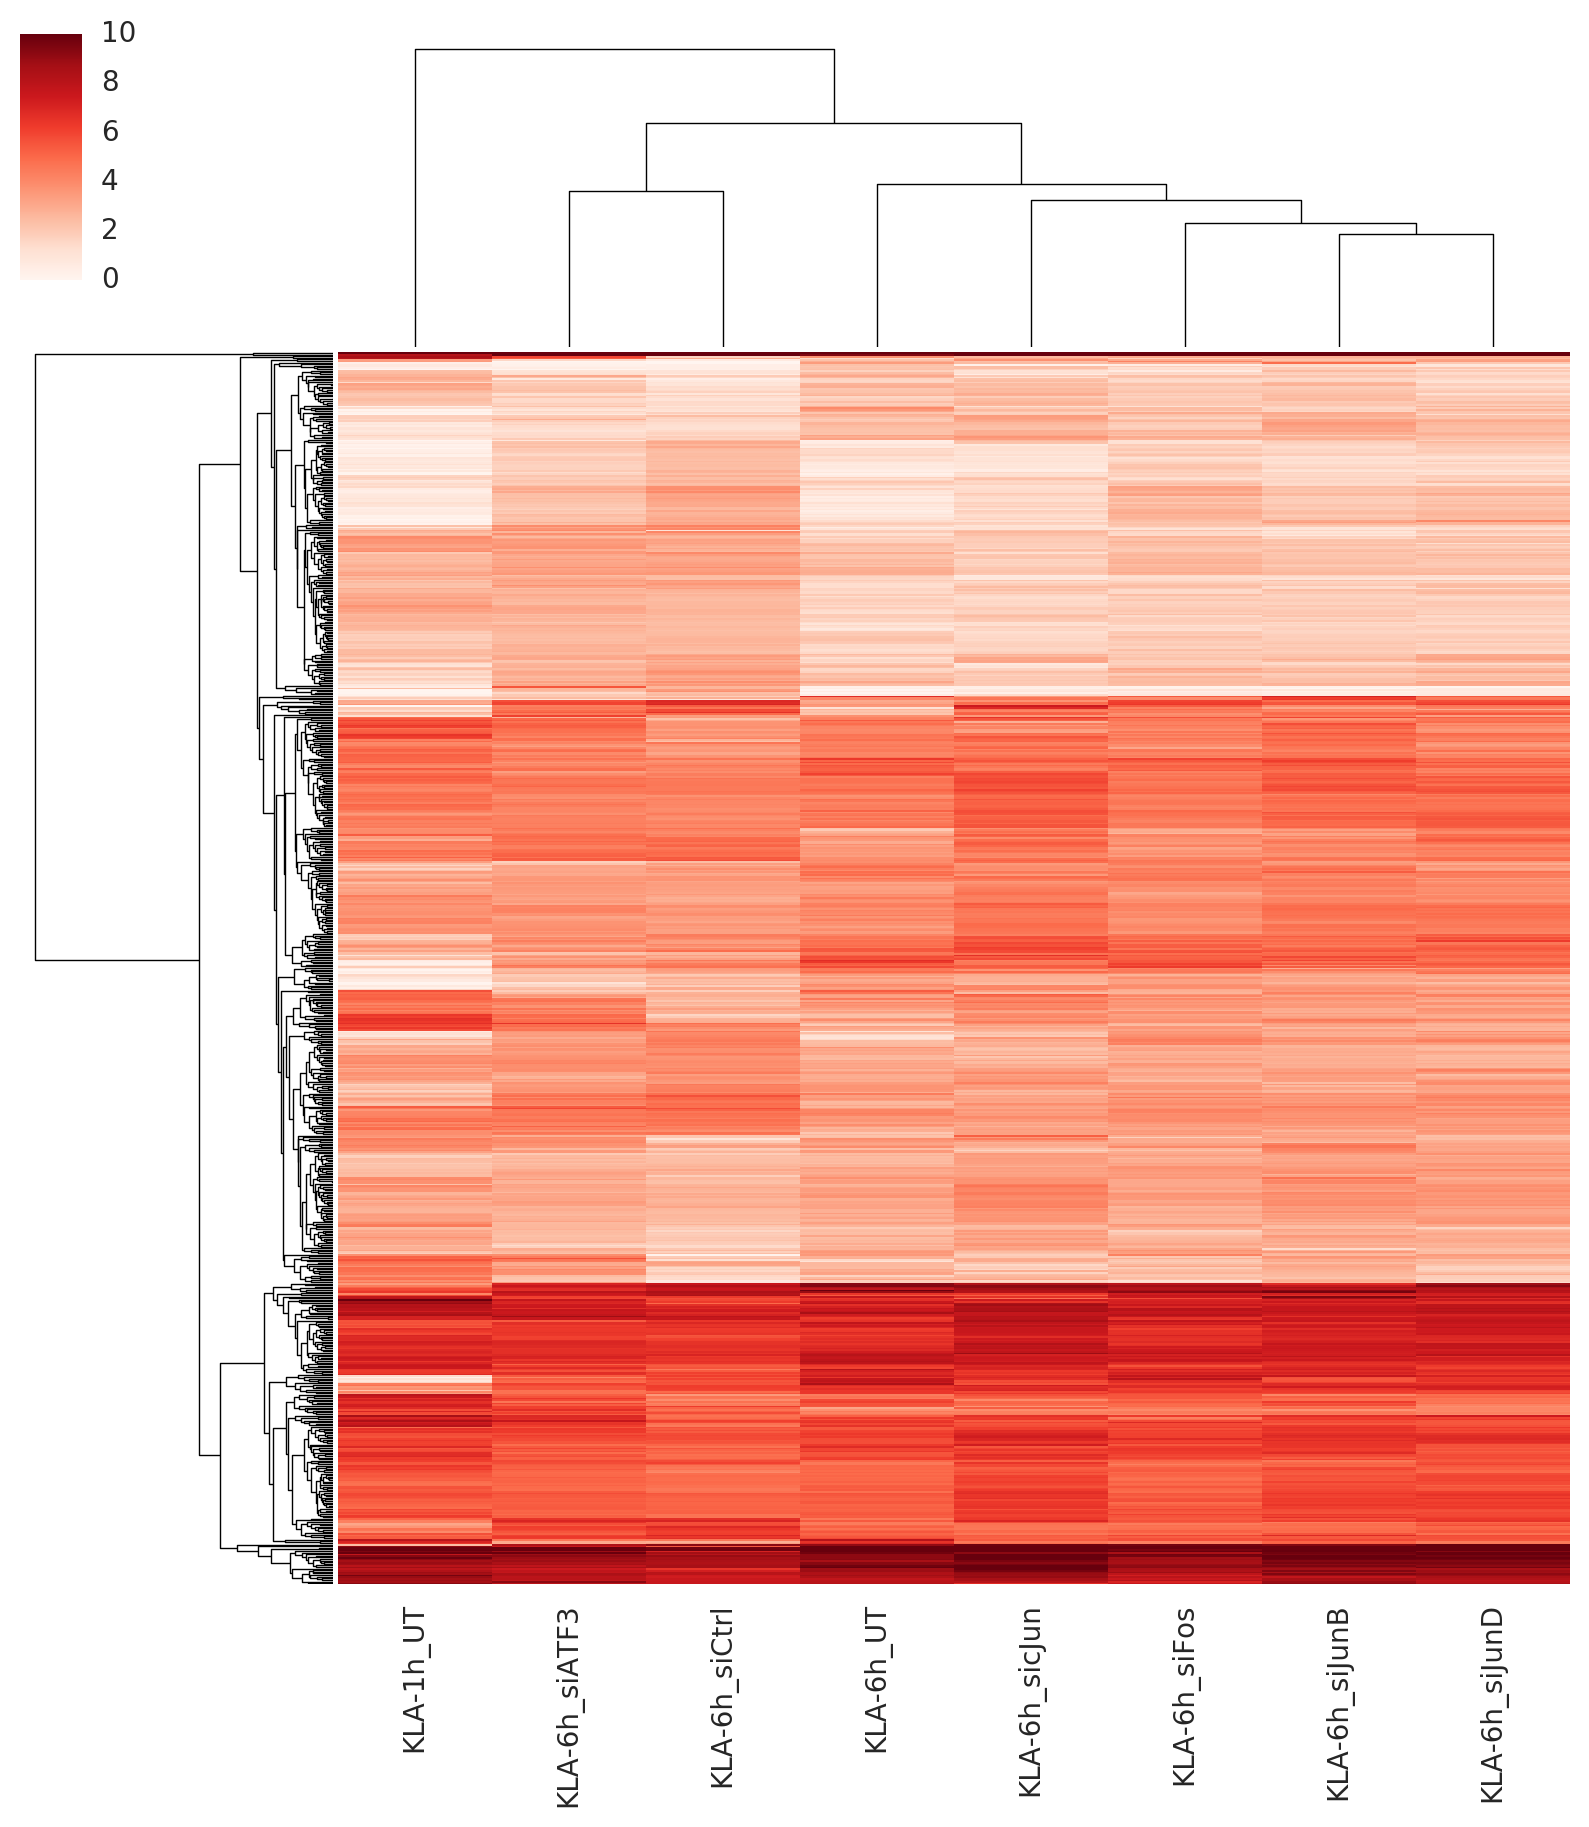

In [184]:
# kla genes
data = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(kla_diff_genes)][[x for x in idr_rpkm_mean_frame.columns if 'KLA' in x]]
sns.clustermap(np.log2(data + 1),
              yticklabels=False,
              vmax=10,
              cmap='Reds')

In [192]:
data = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(veh_diff_genes)]\
    [[x for x in idr_rpkm_mean_frame.columns if 'Veh' in x and not 'UT' in x and not 'Ctrl' in x]]

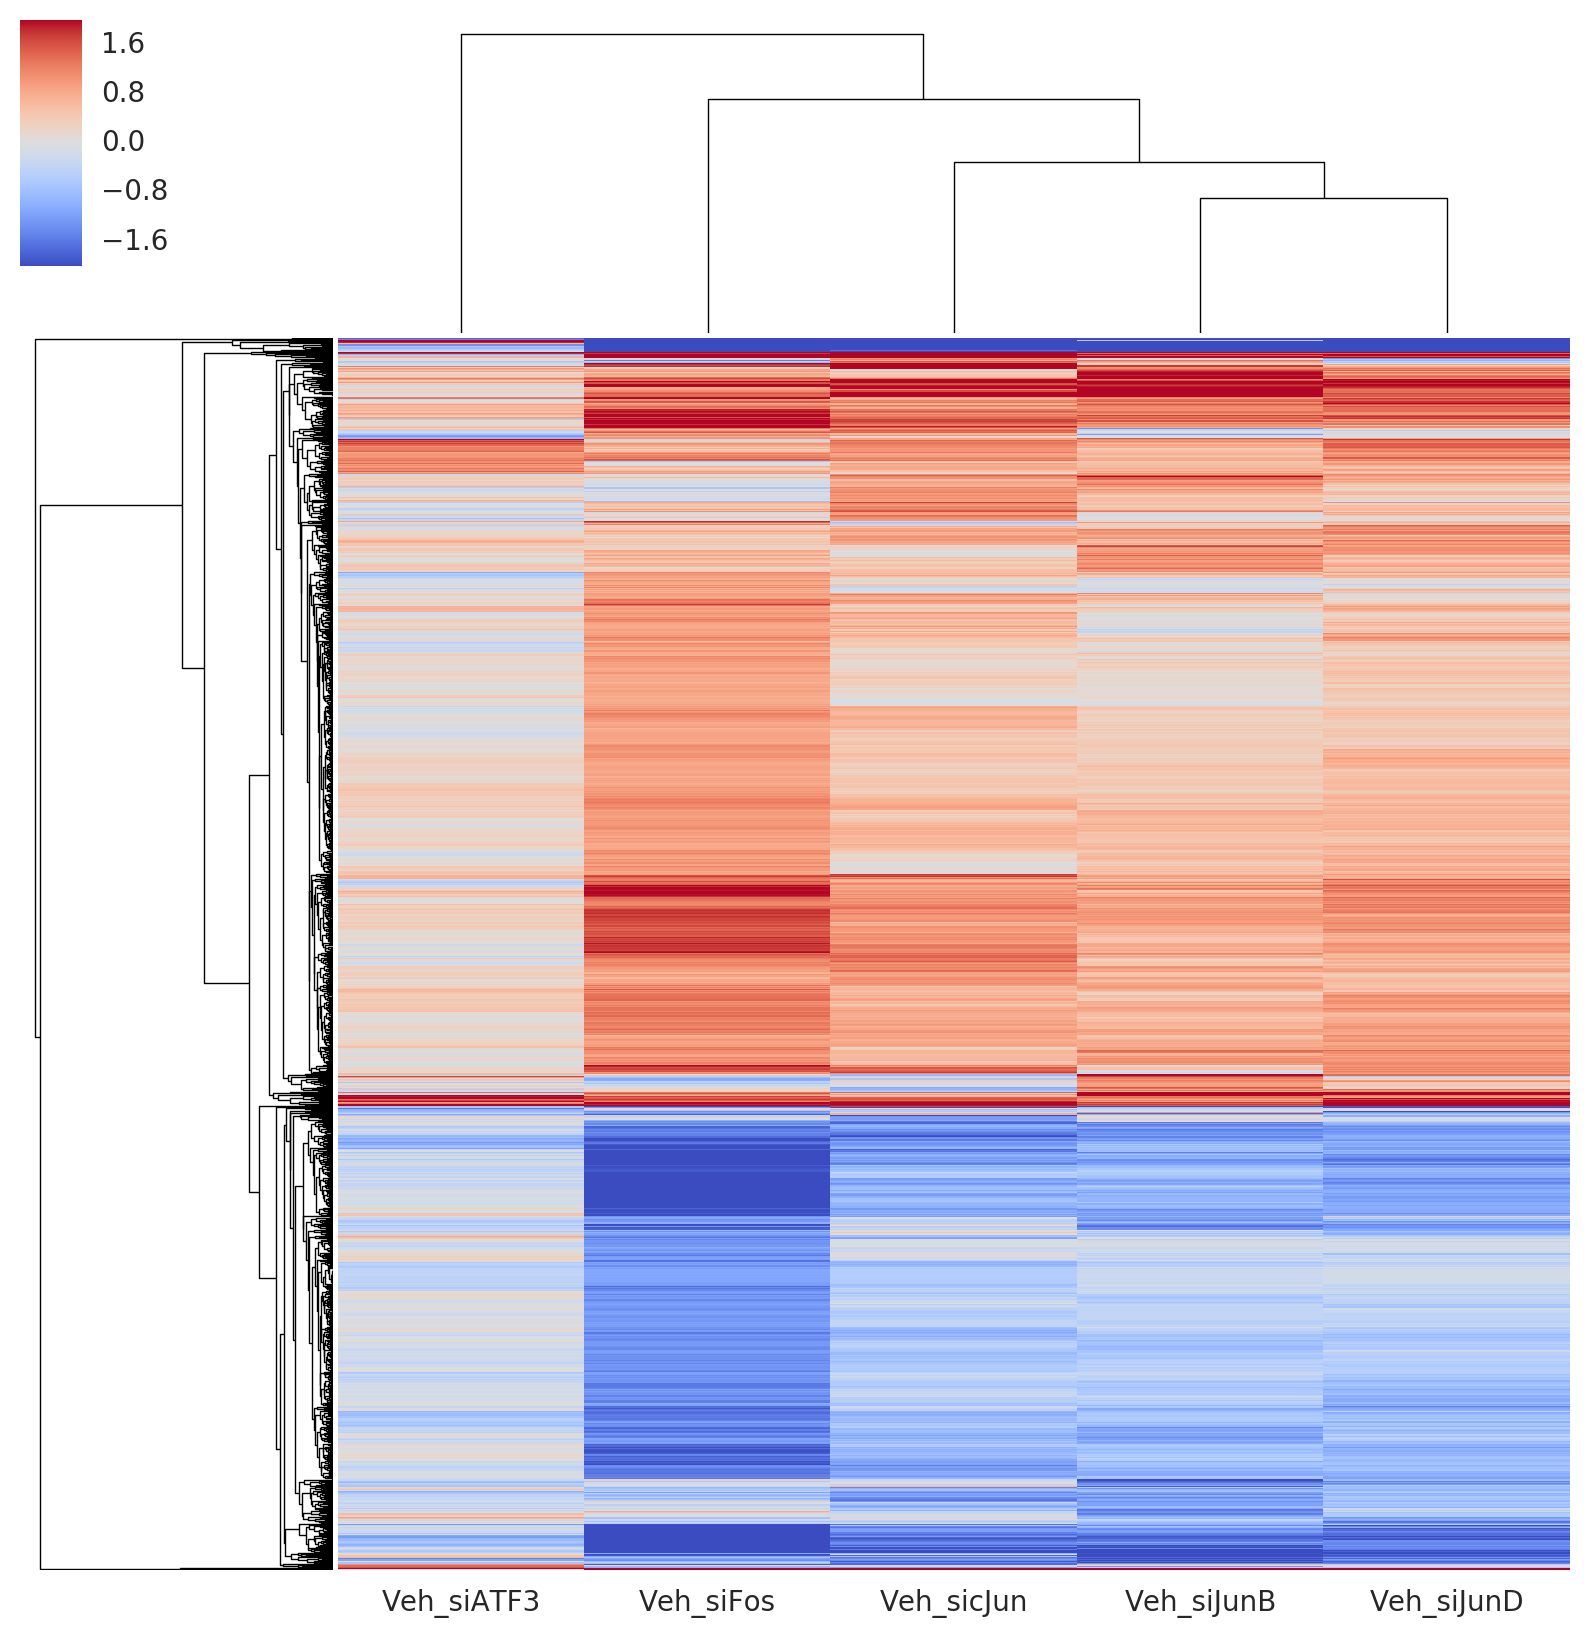

In [210]:
# vehicle fold change
data = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(veh_diff_genes)]\
    [[x for x in idr_rpkm_mean_frame.columns if 'Veh' in x]]
    
# normalize by control experiment
data = (data+0.1).div((data['Veh_siCtrl'].values+0.1), axis=0)

# drop control and UT columns
data = data[[x for x in data.columns if not 'UT' in x and not 'Ctrl' in x]]
sns.clustermap(np.log2(data),
              yticklabels=False,
              cmap='coolwarm',
              vmin = -2,
              vmax=2)

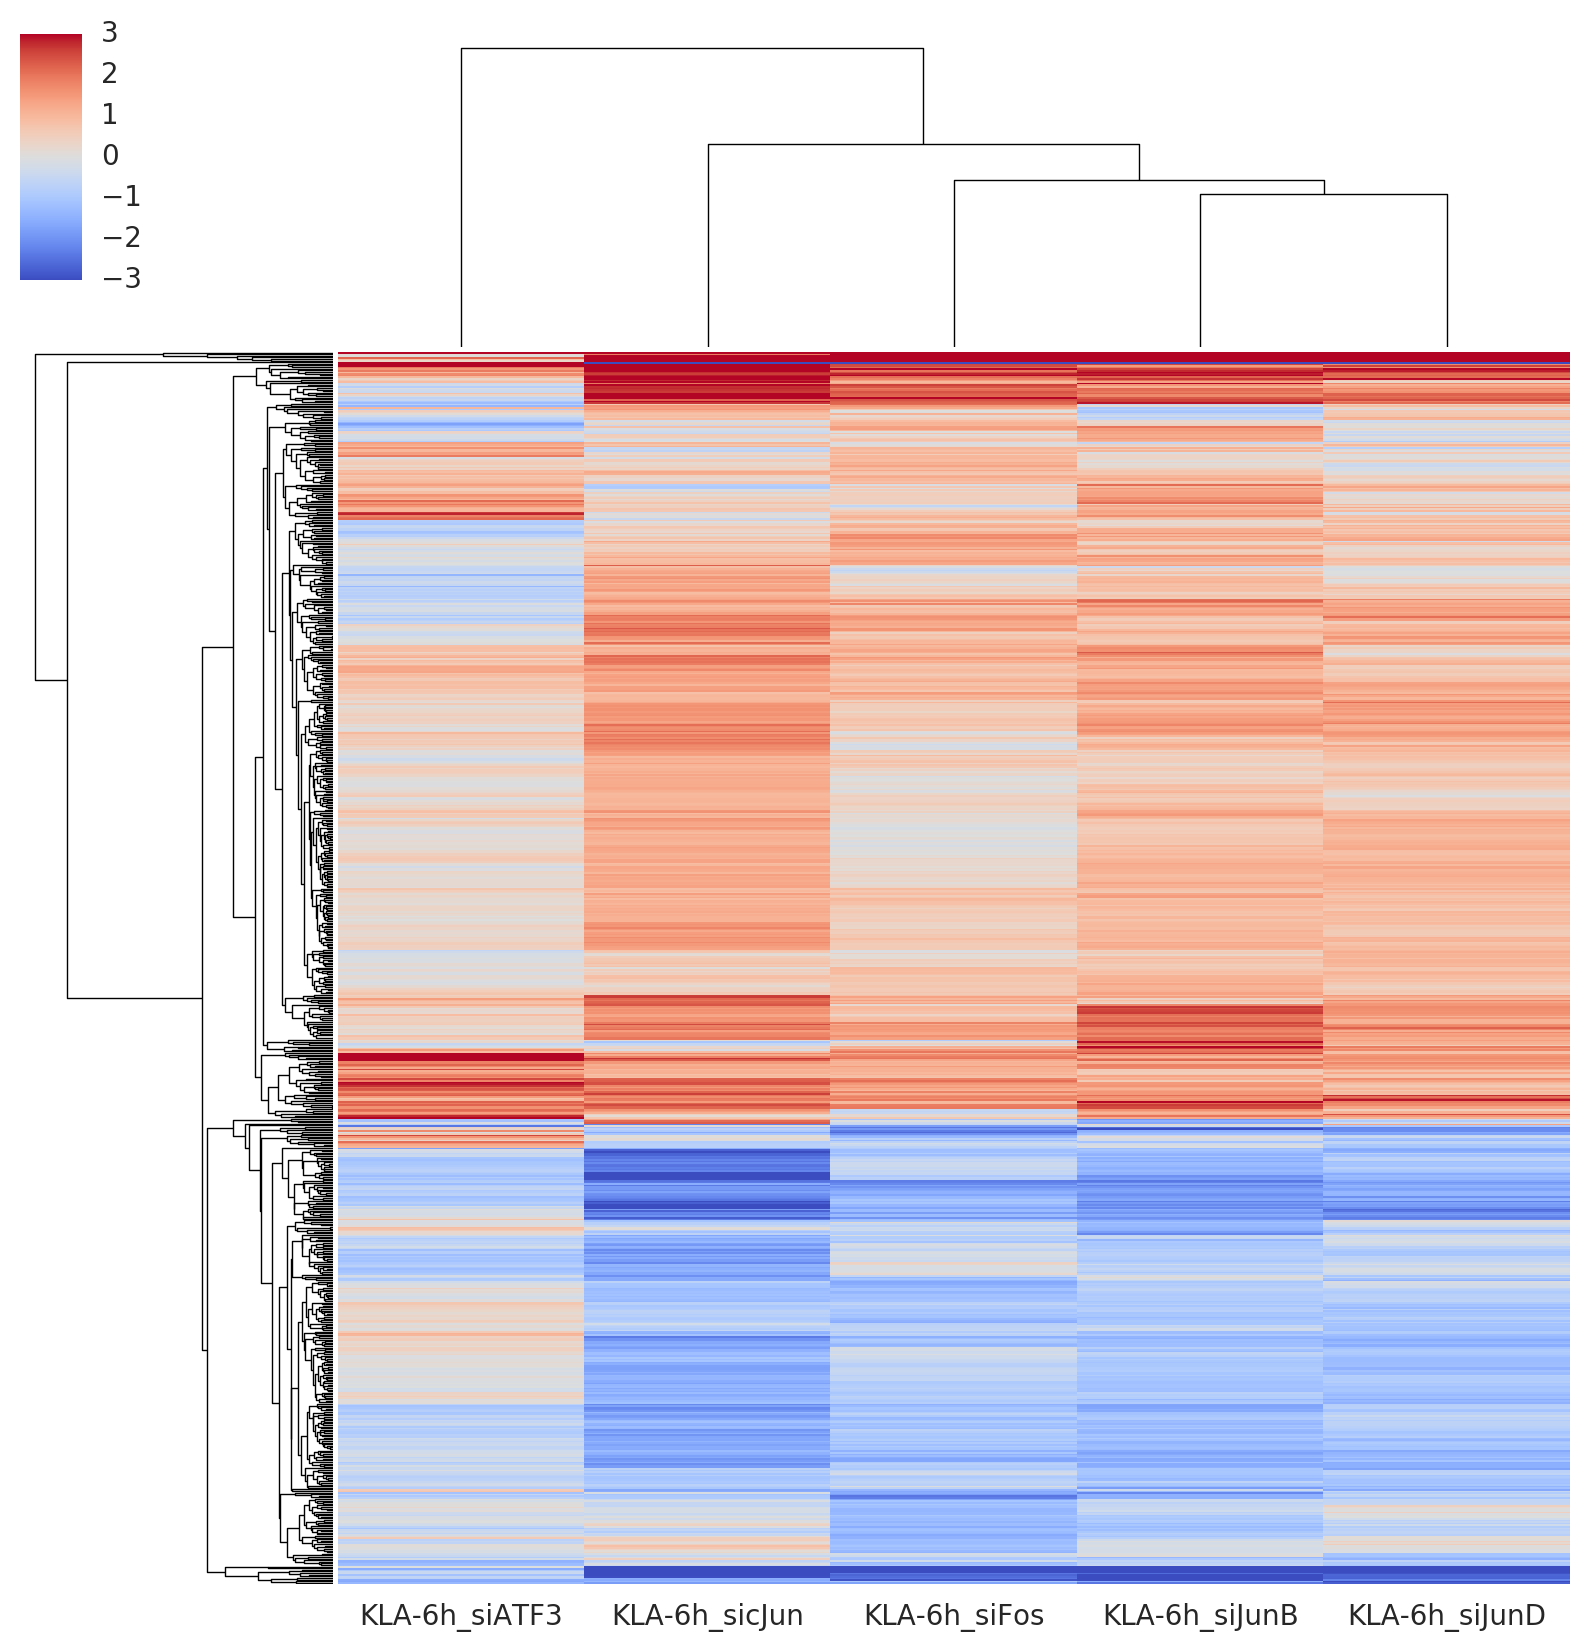

In [212]:
# KLA fold change
data = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(kla_diff_genes)]\
    [[x for x in idr_rpkm_mean_frame.columns if 'KLA' in x]]
    
# normalize by control experiment
data = (data+0.1).div((data['KLA-6h_siCtrl'].values+0.1), axis=0)

# drop control and UT columns
data = data[[x for x in data.columns if not 'UT' in x and not 'Ctrl' in x]]
sns.clustermap(np.log2(data),
              yticklabels=False,
              cmap='coolwarm',
              vmin = -3,
              vmax=3)

## Gene Ontology

In [126]:
! if [ ! -d ./gene_ontology ]; then mkdir ./gene_ontology/ ; else rm ./gene_ontology/* ;fi

In [132]:
# write genes for gene ontology
# back ground genes
background_file = open('./gene_ontology/background.txt','w')
expressed_genes = idr_rpkm_mean_frame[idr_rpkm_mean_frame.max(axis=1) >= 4].index.values
for gene in sorted(expressed_genes):
    background_file.write(gene.upper() + '\n')
background_file.close()
    
# down regulated genes
for condition in sorted(condition_genes_down_dict.keys()):
    down_file = open('./gene_ontology/' + condition + '_down.txt', 'w')
    
    down_genes = sorted(condition_genes_down_dict[condition])
    for g in down_genes:
        down_file.write(g.upper() + '\n')

    down_file.close()

# upregulated genes
for condition in sorted(condition_genes_up_dict.keys()):
    up_file = open('./gene_ontology/' + condition + '_up.txt', 'w')
    
    up_genes = sorted(condition_genes_up_dict[condition])
    for g in up_genes:
        up_file.write(g.upper() + '\n')

    up_file.close()

In [136]:
for f in os.listdir('./gene_ontology/'):
    if not 'background' in f and not 'result' in f and 'txt' in f:
        out_name = f.replace('.txt', '_result.txt')
#         os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/' 
#                   + f +' ./gene_ontology/background.txt /home/jtao/analysis/go_analysis/mouse_association --pval=0.05 > ./gene_ontology/' + out_name)
        print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/' 
                  + f +' ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/' + out_name + ' &')



/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/Veh_siFos_up.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/Veh_siFos_up_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/Veh_siATF3_down.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/Veh_siATF3_down_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/Veh_sicJun_down.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/Veh_sicJun_down_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/KLA-6h_siJunD_up.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/KLA-6h_siJunD_up_result.txt &
/bio

In [167]:
p_threshold = 0.01
correction = 'sidak'
term_tuples = []
terms = []
treatments = []

for f in sorted(os.listdir('./gene_ontology/')):
    if 'result' in f and 'up' in f and 'txt' in f :
        with open('./gene_ontology/' + f) as data:
            data = data.readlines()
        if len(data):
            results = pd.read_csv('./gene_ontology/' + f ,sep='\t', skiprows=2)
            treatment = '_'.join(f.split('_')[:-1])
            treatments.append(treatment)
            significant_results = results[results['p_' + correction] < p_threshold]

            # seperate enriched and purified results
            enriched_results = significant_results[significant_results['enrichment']=='e']

            purified_results= significant_results[significant_results['enrichment']=='p']
            terms = terms + list(enriched_results['description'].values)
            term_tuples = term_tuples +list(zip(enriched_results['id'].values,
                                                enriched_results['description'].values, 
                                                enriched_results['p_' + 'uncorrected'].values, 
                                                [treatment] * significant_results.shape[0]))
            print(treatment, enriched_results.shape)


terms = sorted(list(set(terms)))
treatments=sorted(treatments)
# treatments.remove('1um-Mepip')
term_id_dict = dict(zip([x[1] for x in term_tuples],
                       [x[0] for x in term_tuples]))
term_index_dict = dict(zip(terms, range(len(terms))))

treatment_index_dict = dict(zip(treatments, range(len(treatments))))
counter = 0
matrix = np.ones((len(terms), len(treatments)))
for t in term_tuples:
    matrix[term_index_dict[t[1]]][treatment_index_dict[t[3]]] = t[2]
up_frame = pd.DataFrame(matrix, columns=treatments, index=terms)
up_frame['id'] = [term_id_dict[x] for x in up_frame.index.values]


term_tuples = []
terms = []
treatments = []
for f in os.listdir('./gene_ontology/'):
    if 'result' in f and 'down' in f:
        with open('./gene_ontology/' + f) as data:
            data = data.readlines()
        if len(data):
            results = pd.read_csv('./gene_ontology/' + f ,sep='\t', skiprows=2)
            treatment = '_'.join(f.split('_')[:-1])
            treatments.append(treatment)
            significant_results = results[results['p_' + correction] < p_threshold]

            # seperate enriched and purified results
            enriched_results = significant_results[significant_results['enrichment']=='e']

            purified_results= significant_results[significant_results['enrichment']=='p']
            terms = terms + list(enriched_results['description'].values)
            term_tuples = term_tuples +list(zip(enriched_results['id'].values,
                                                enriched_results['description'].values, 
                                                enriched_results['p_' + 'uncorrected'].values,  
                                                [treatment] * significant_results.shape[0]))
            print(treatment, enriched_results.shape)


terms = sorted(list(set(terms)))
treatments=sorted(treatments)

term_id_dict = dict(zip([x[1] for x in term_tuples],
                       [x[0] for x in term_tuples]))
term_index_dict = dict(zip(terms, range(len(terms))))

treatment_index_dict = dict(zip(treatments, range(len(treatments))))

matrix = np.ones((len(terms), len(treatments)))
for t in term_tuples:
    matrix[term_index_dict[t[1]]][treatment_index_dict[t[3]]] = t[2]
down_frame = pd.DataFrame(matrix, columns=treatments, index=terms)
down_frame['id'] = [term_id_dict[x] for x in down_frame.index.values]

# save go terms
up_frame.to_csv('./gene_ontology/go_terms_up.tsv', sep='\t')
down_frame.to_csv('go_terms_down.tsv', sep='\t')
out_file = open('go_ids_up.txt', 'w')
for id in up_frame['id'].values:
    out_file.write(id.strip() + '\n')
out_file.close()

out_file = open('./gene_ontology/go_ids_down.txt', 'w')
for id in down_frame['id'].values:
    out_file.write(id.strip() + '\n')
out_file.close()

KLA-6h_siATF3_up (1, 10)
KLA-6h_siFos_up (85, 10)
KLA-6h_siJunB_up (12, 10)
KLA-6h_siJunD_up (19, 10)
KLA-6h_sicJun_up (7, 10)
Veh_siATF3_up (1, 10)
Veh_siFos_up (0, 10)
Veh_siJunB_up (0, 10)
Veh_siJunD_up (0, 10)
Veh_sicJun_up (3, 10)
Veh_siATF3_down (0, 10)
KLA-6h_siFos_down (0, 10)
KLA-6h_siJunB_down (4, 10)
KLA-6h_sicJun_down (17, 10)
KLA-6h_siATF3_down (0, 10)
Veh_siJunD_down (6, 10)
Veh_sicJun_down (10, 10)
KLA-6h_siJunD_down (1, 10)
Veh_siJunB_down (6, 10)
Veh_siFos_down (15, 10)


In [215]:
[x for x in down_frame.columns if not 'Id' in x and not 'KLA' in x]

['Veh_siATF3_down',
 'Veh_siFos_down',
 'Veh_siJunB_down',
 'Veh_siJunD_down',
 'Veh_sicJun_down',
 'id']

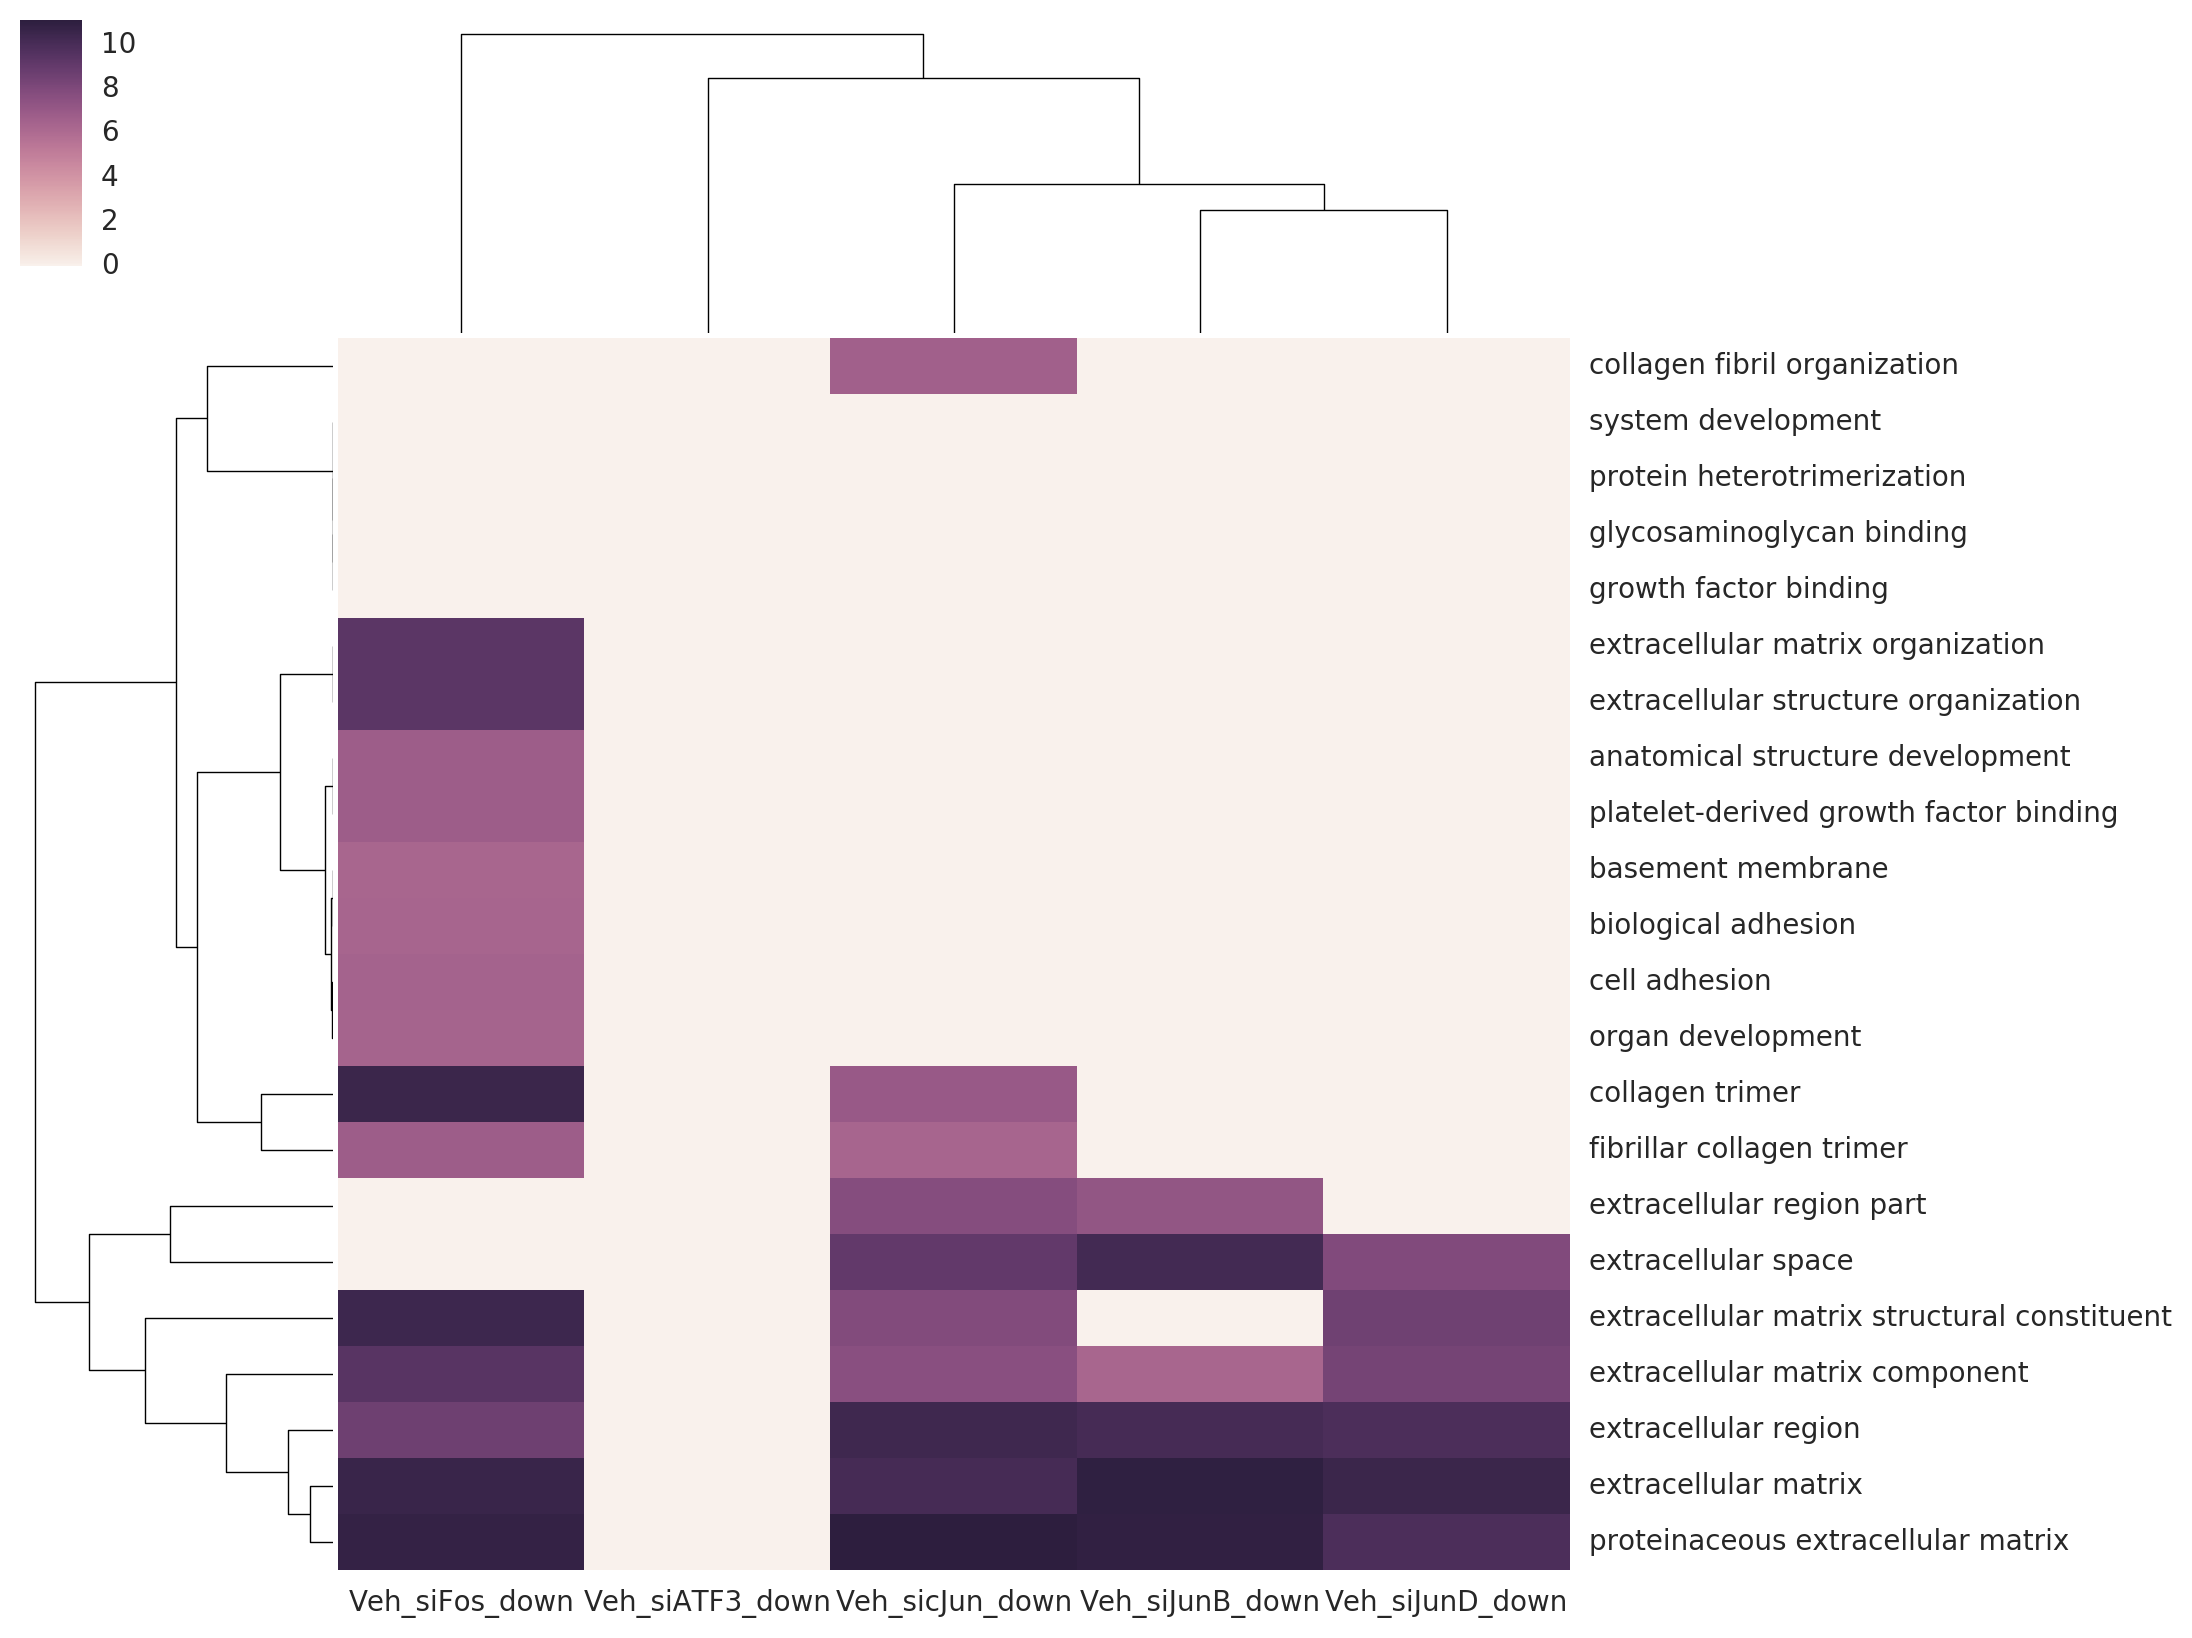

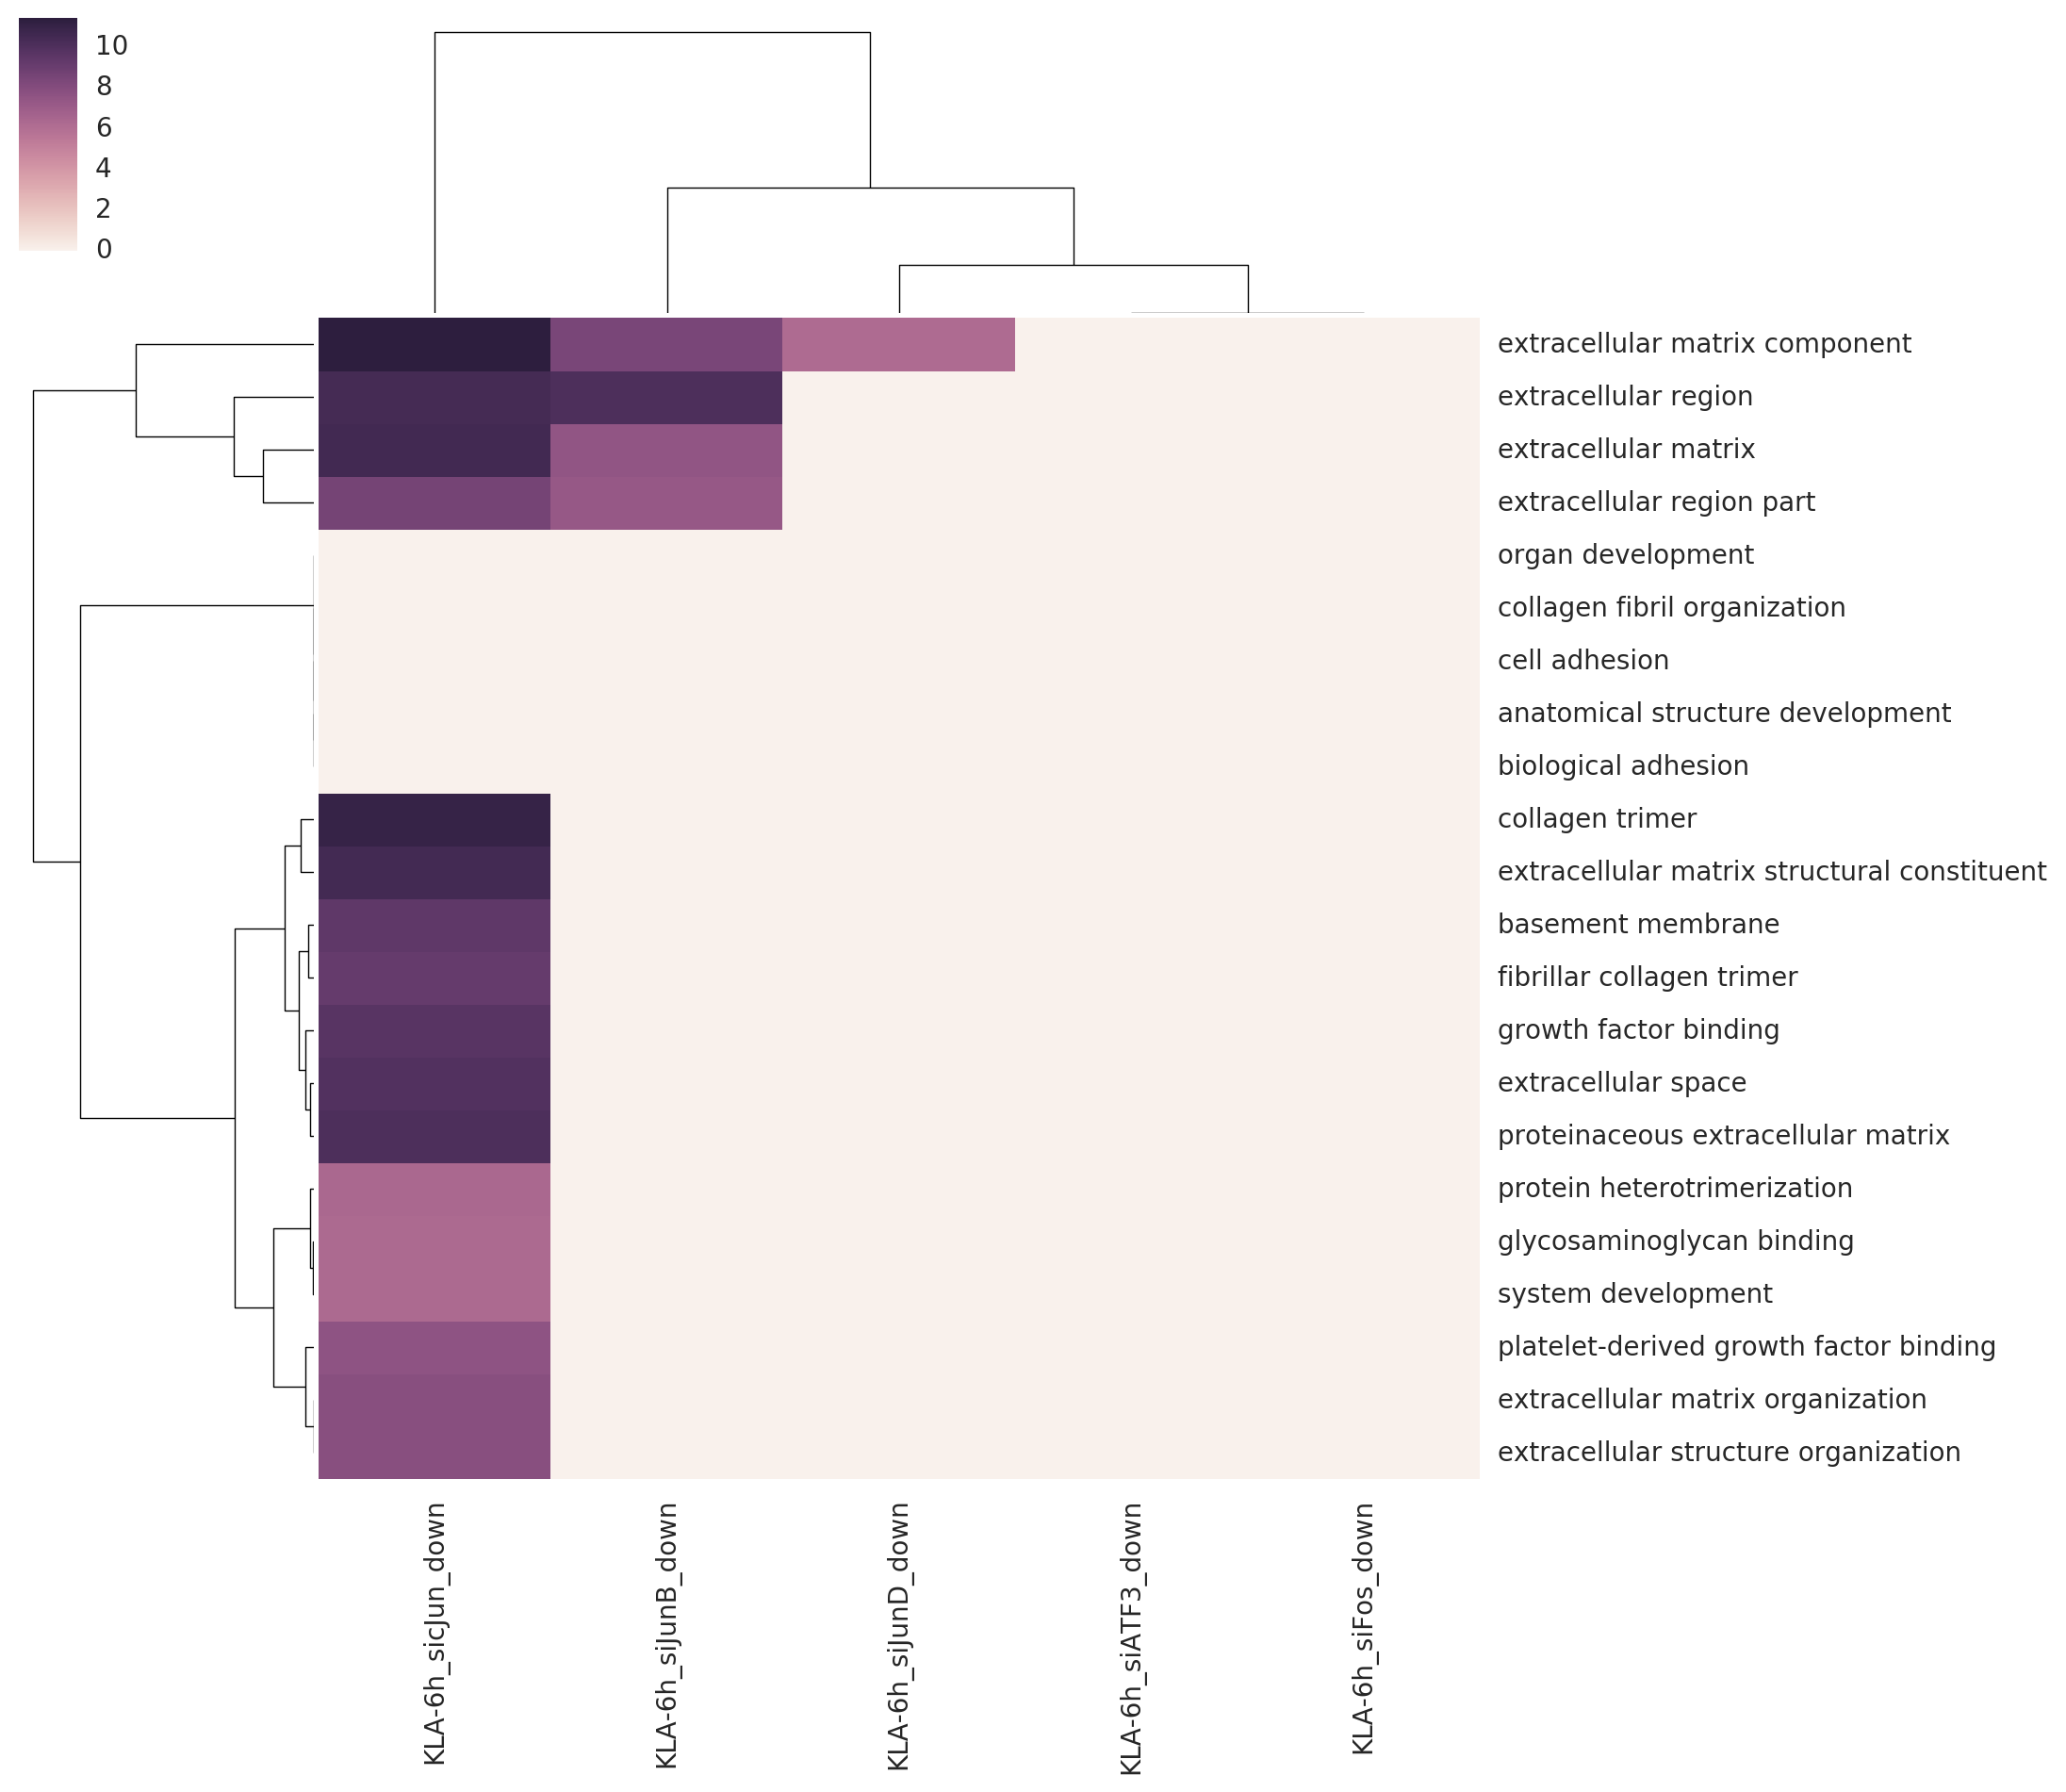

In [217]:
# down regulated genes
# vehicle

cg = sns.clustermap(-1*np.log10(down_frame.ix[:,
                                              [x for x in down_frame.columns if not 'id' in x and not 'KLA' in x]]))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

# KLA
cg = sns.clustermap(-1*np.log10(down_frame.ix[:,
                                              [x for x in down_frame.columns if not 'id' in x and not 'Veh' in x]]))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

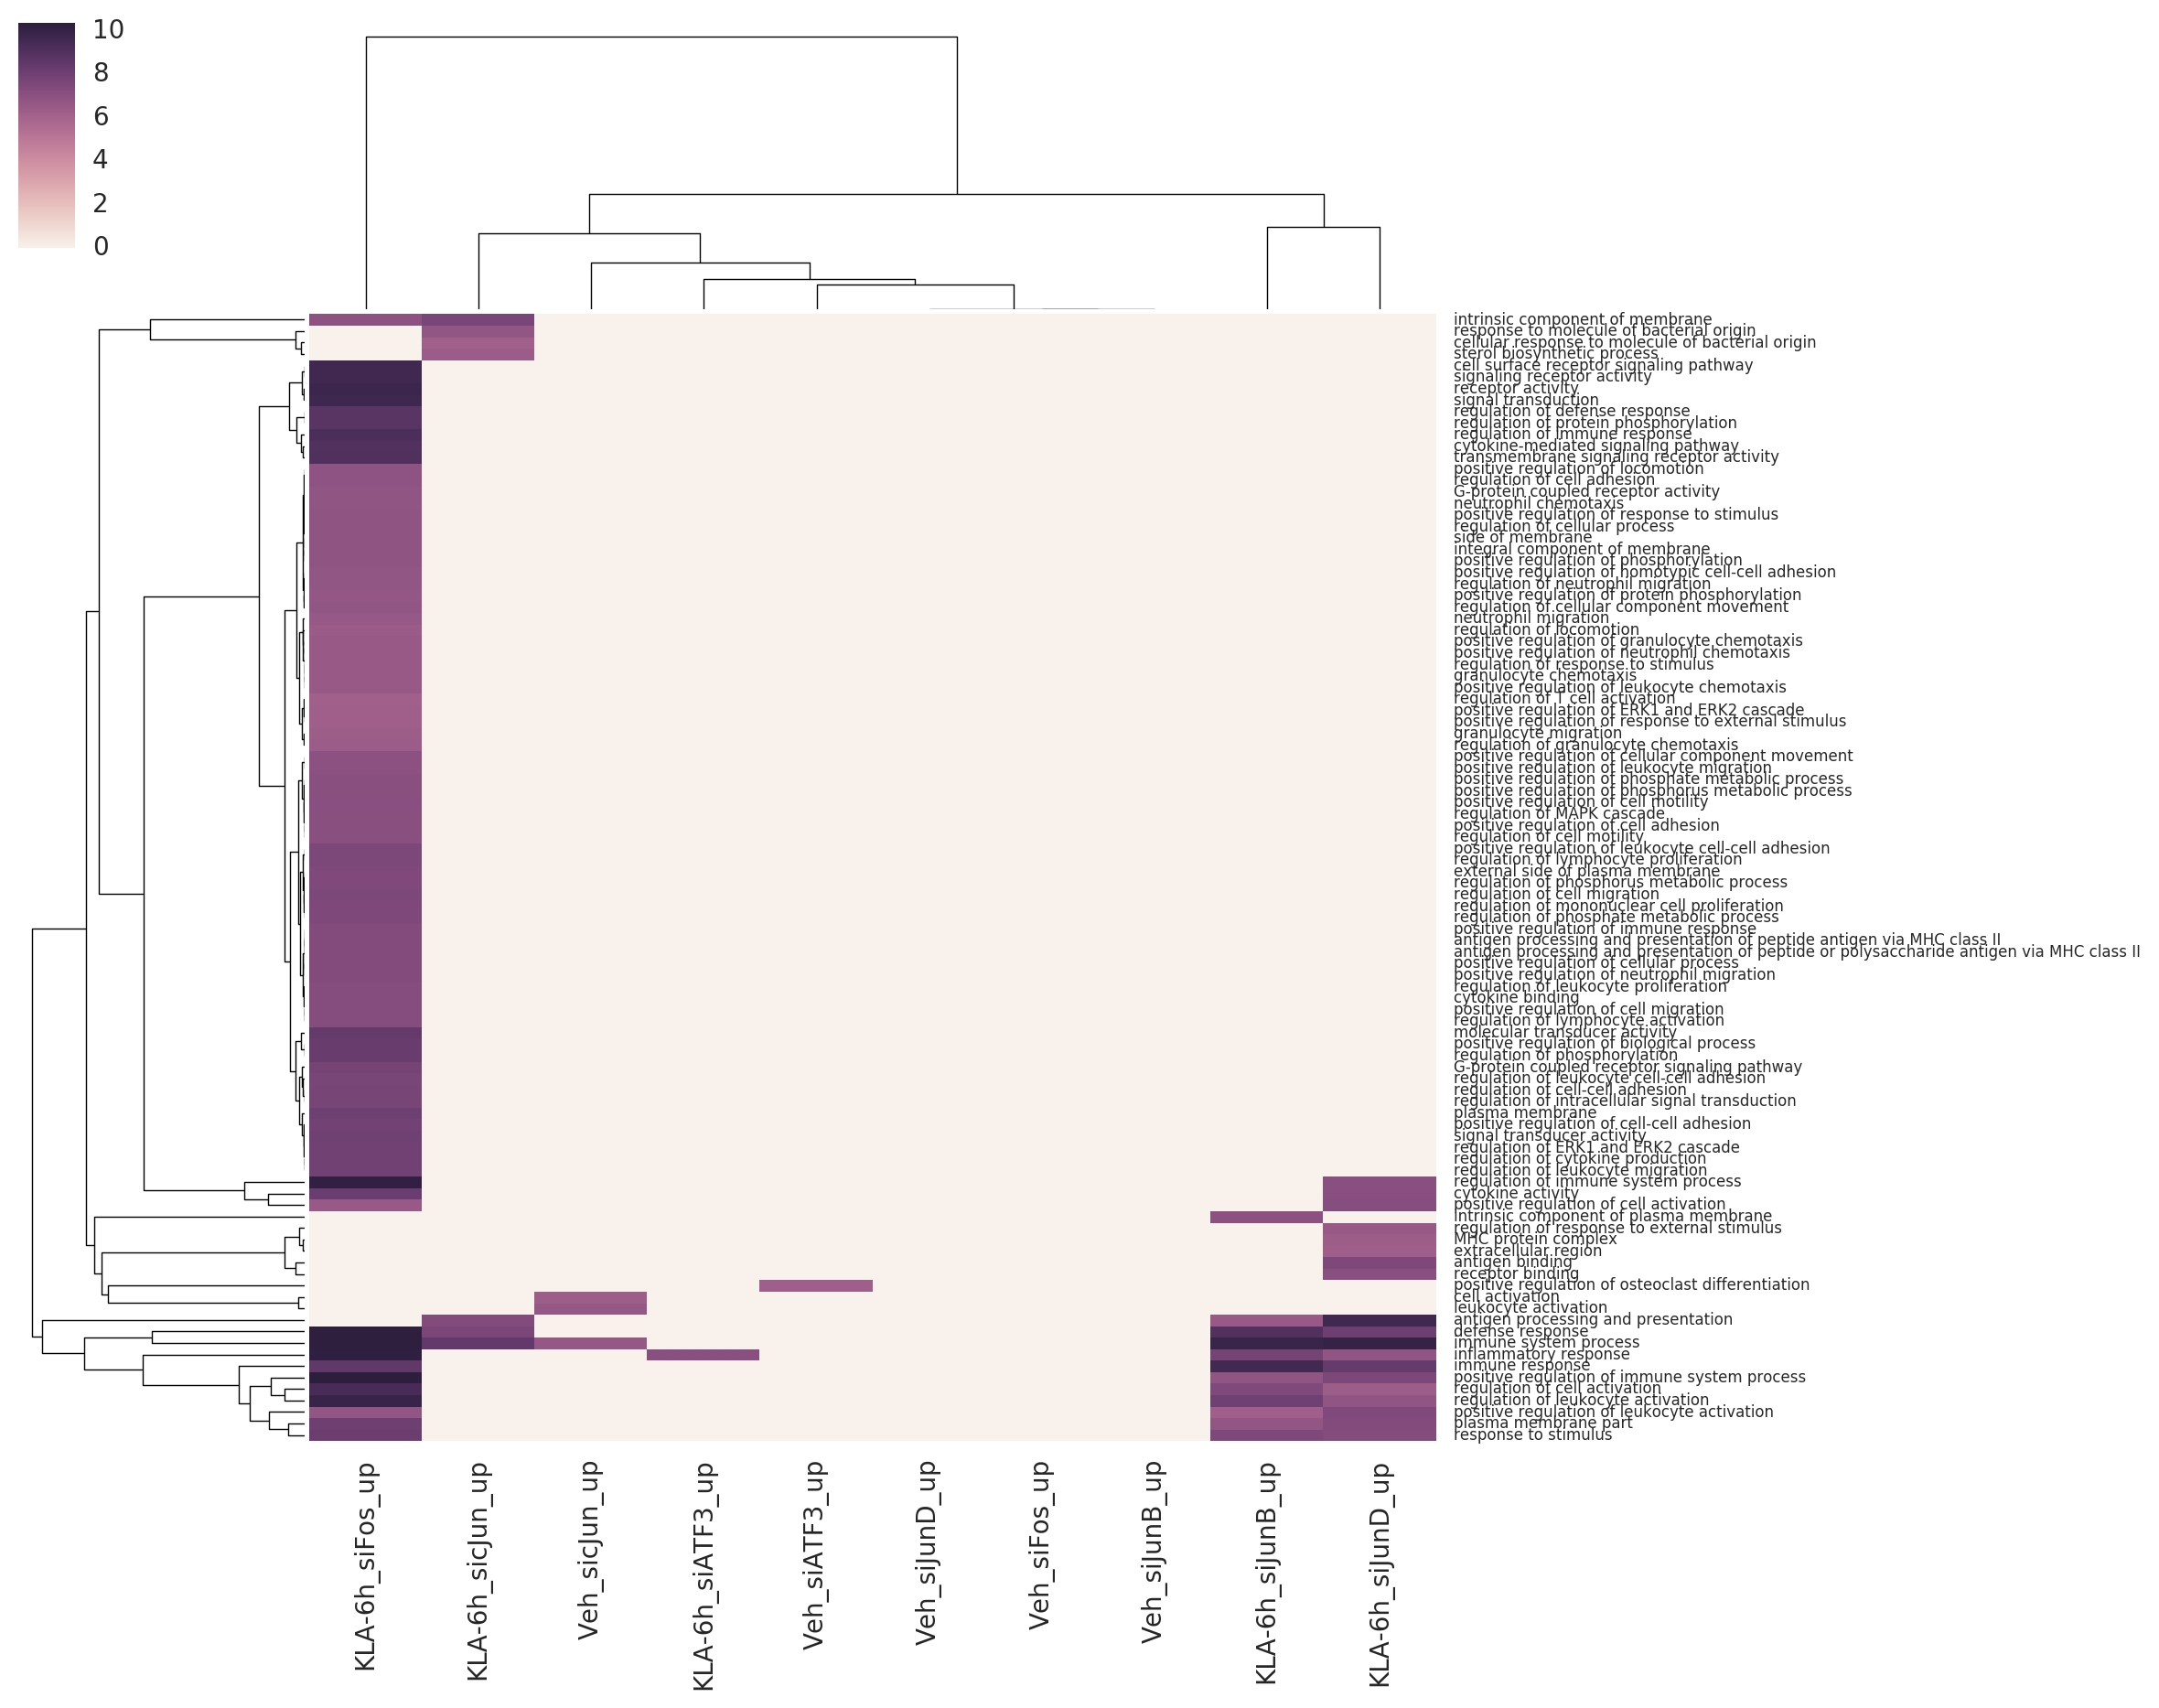

In [171]:
cg = sns.clustermap(-1*np.log10(up_frame.ix[:,:-1]))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, size=6);



## PCA

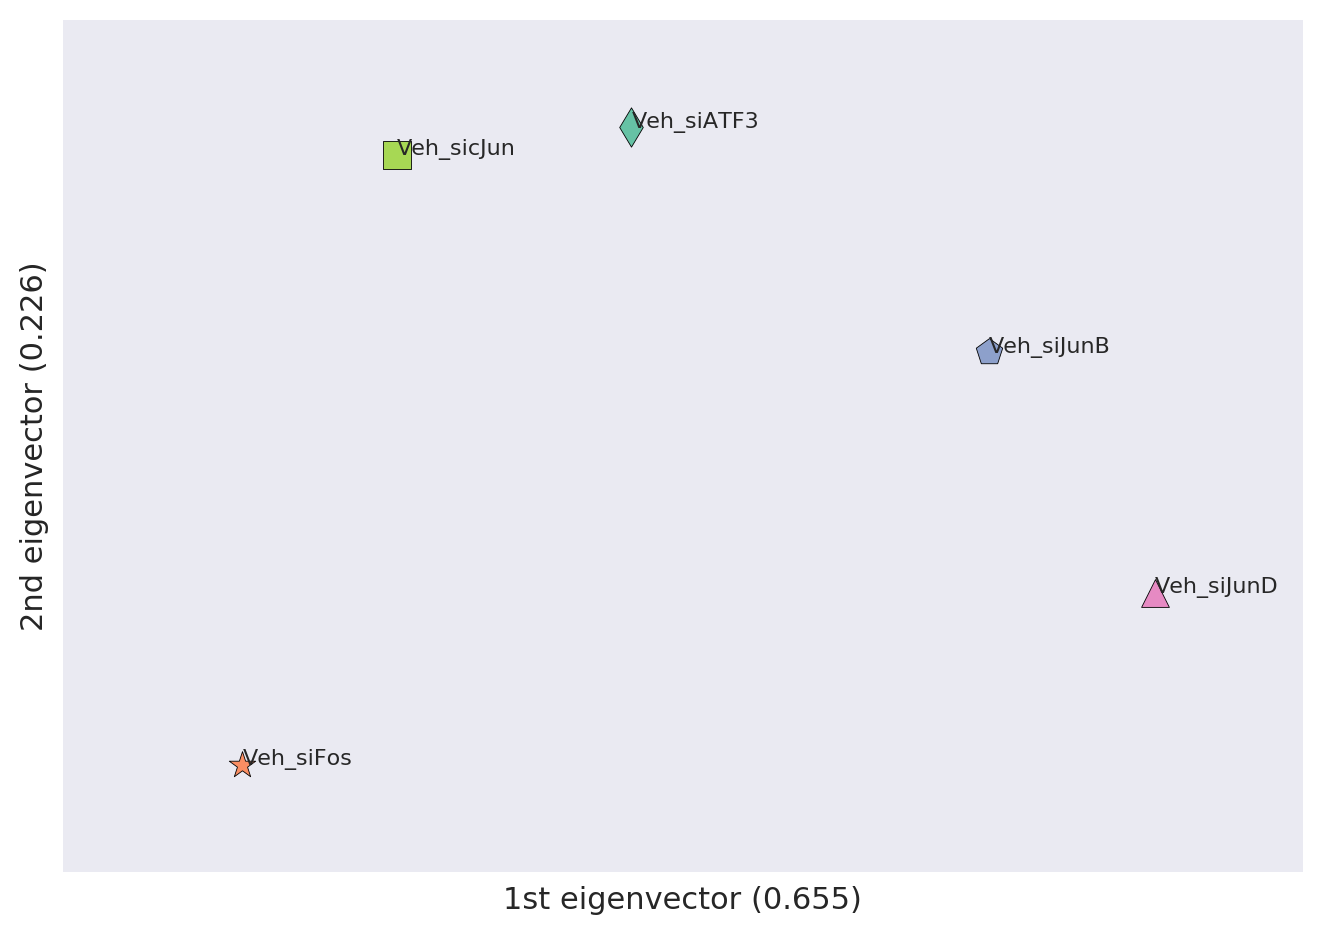

In [246]:
# vehicle genes

features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(veh_diff_genes)]\
    [[x for x in idr_rpkm_mean_frame.columns if 'Veh' in x and not 'UT' in x and not 'Ctrl' in x]]
classes = features.columns.values

markerDict = dict(zip(sorted(set(classes)), 
                 ['d','*','p','^','s','o']))
colorDict = dict(zip(sorted(set(classes)), 
                 sns.color_palette("Set2") + sns.color_palette("colorblind")))


model = sklearn.decomposition.PCA(n_components=2)
reduced_features = model.fit_transform(features.T)
explained_variance_ratios = down_model.explained_variance_ratio_

markers = [markerDict[x] for x in features.columns.values]
colors = [colorDict[x] for x in features.columns.values]

for i in range(len(classes)):
    plt.scatter(reduced_features[i, 0], reduced_features[i, 1], 
                marker=markers[i], 
                s=100, 
                c=colors[i],
                label=classes[i])
    plt.annotate(classes[i],xy=(reduced_features[i, 0], reduced_features[i, 1]), size=8)
plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])


# plt.legend()

ax = plt.gca()

# plt.xlim(0,1)
# x0,x1 = ax.get_xlim()
# y0,y1 = ax.get_ylim()
# ax.set_aspect(abs(x1-x0)/abs(y1-y0))   
plt.show()



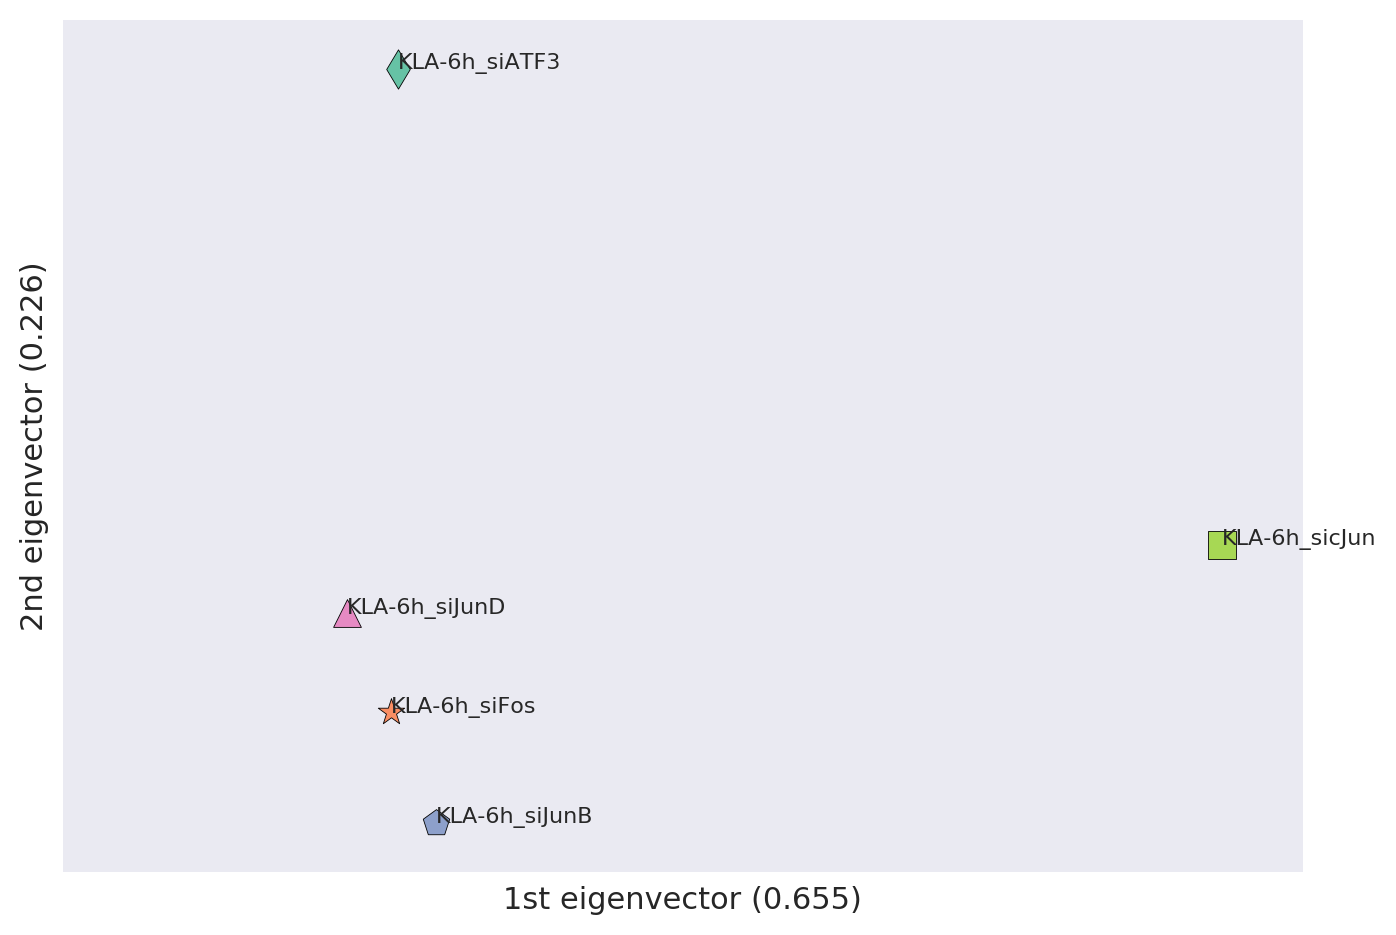

In [247]:
# KLA genes

features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(veh_diff_genes)]\
    [[x for x in idr_rpkm_mean_frame.columns if 'KLA' in x and not 'UT' in x and not 'Ctrl' in x]]
classes = features.columns.values

markerDict = dict(zip(sorted(set(classes)), 
                 ['d','*','p','^','s','o']))
colorDict = dict(zip(sorted(set(classes)), 
                 sns.color_palette("Set2") + sns.color_palette("colorblind")))


model = sklearn.decomposition.PCA(n_components=2)
reduced_features = model.fit_transform(features.T)
explained_variance_ratios = down_model.explained_variance_ratio_

markers = [markerDict[x] for x in features.columns.values]
colors = [colorDict[x] for x in features.columns.values]

for i in range(len(classes)):
    plt.scatter(reduced_features[i, 0], reduced_features[i, 1], 
                marker=markers[i], 
                s=100, 
                c=colors[i], label=classes[i])
    plt.annotate(classes[i],xy=(reduced_features[i, 0], reduced_features[i, 1]), size=8)


plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

# plt.legend()
ax = plt.gca()

# x0,x1 = ax.get_xlim()
# y0,y1 = ax.get_ylim()
# ax.set_aspect(abs(x1-x0)/abs(y1-y0))   
plt.show()




## Scatter Plots

In [257]:
idr_rpkm_mean_frame.head()

KLA-1h_UT  KLA-6h_UT  KLA-6h_siATF3  KLA-6h_siCtrl  \
0610005C13RIK     0.0155     0.0000         0.0775        0.04300   
0610007P14RIK    12.8025     9.7665        10.5175        9.23875   
0610009B22RIK    17.5125     5.2890        15.7375        8.44725   
0610009L18RIK     2.5660     1.2730         1.0510        0.73625   
0610009O20RIK     6.9425     5.4380         7.1375        7.36100   

               KLA-6h_siFos  KLA-6h_siJunB  KLA-6h_siJunD  KLA-6h_sicJun  \
0610005C13RIK        0.0000         0.0165         0.0000         0.0000   
0610007P14RIK       11.2295        20.3060        19.2235        24.2180   
0610009B22RIK        6.3845        13.0715        12.5065        19.5930   
0610009L18RIK        1.4525         1.1790         0.8535         1.8415   
0610009O20RIK        7.0735         7.1035         8.5720         6.3805   

                Veh_UT  Veh_siATF3  Veh_siCtrl  Veh_siFos  Veh_siJunB  \
0610005C13RIK   0.0950      0.0370     0.09575     0.0000      0.0565   
0610007P14RIK  16.1765     14.0135    13.21900    27.7585     22.0320   
0610009B22RIK  20.8050     21.7690    21.75125    42.0580     24.7090   
0610009L18RIK   2.7995      1.5670     3.02525     7.2850      3.3905   
0610009O20RIK  11.5835     12.8790    11.61350     7.9635     11.2775   

               Veh_siJunD  Veh_sicJun  
0610005C13RIK      0.0510      0.2410  
0610007P14RIK     26.9085     23.0695  
0610009B22RIK     27.9465     33.8060  
0610009L18RIK      2.9740      3.3780  
0610009O20RIK     12.4020     11.6465

In [271]:
tokens

['Veh_siCtrl', 'vs.', 'Veh_sicJun', 'adj.', 'p-value']

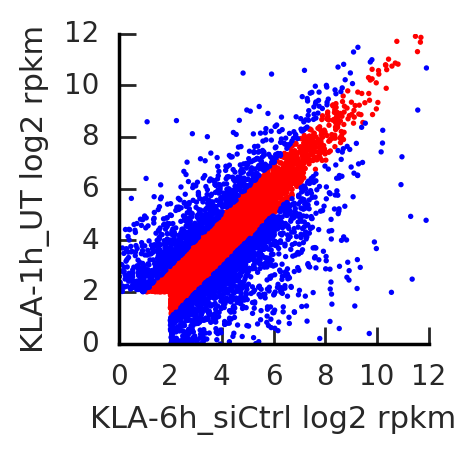

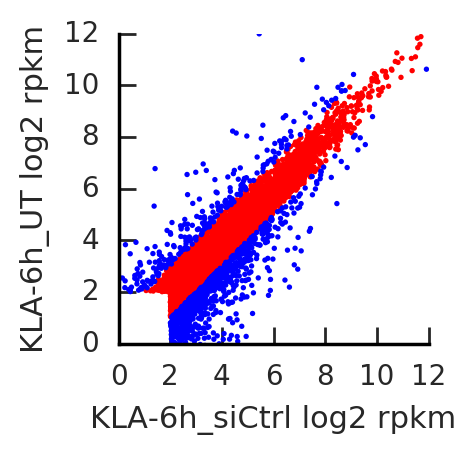

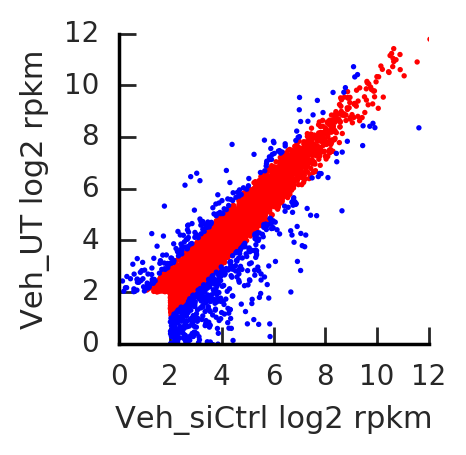

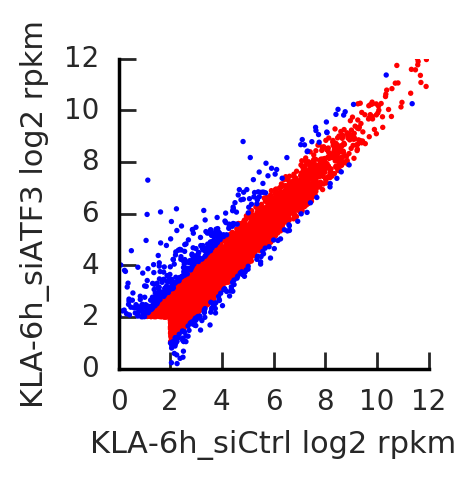

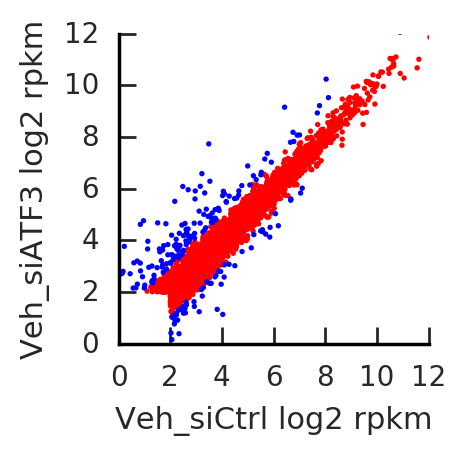

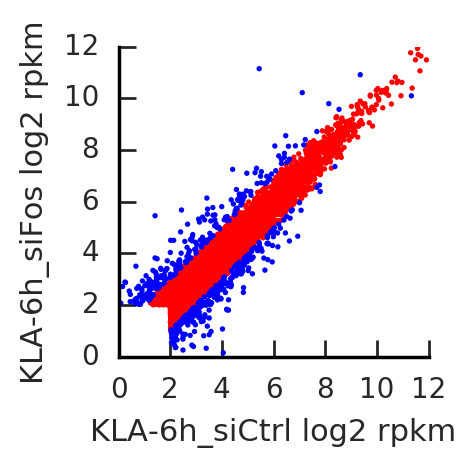

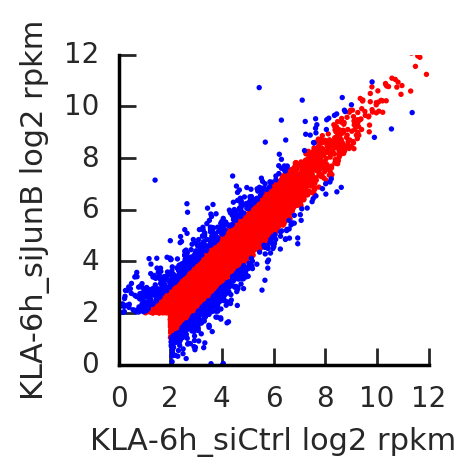

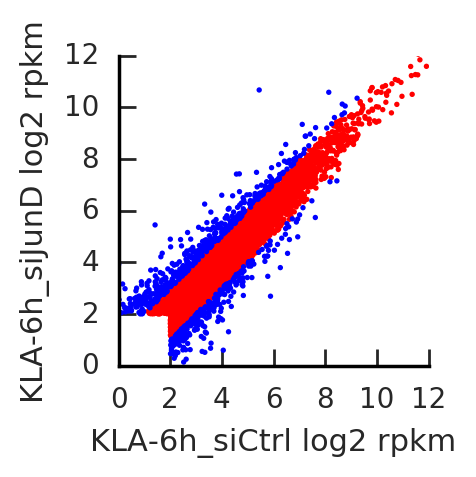

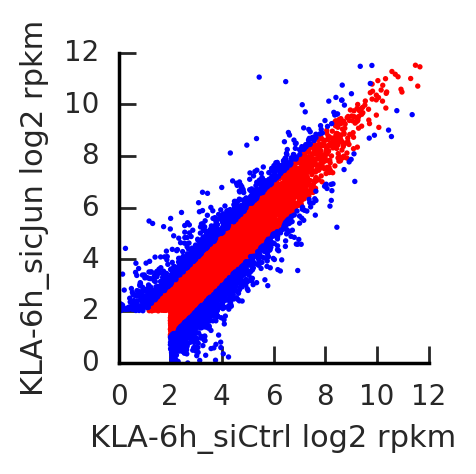

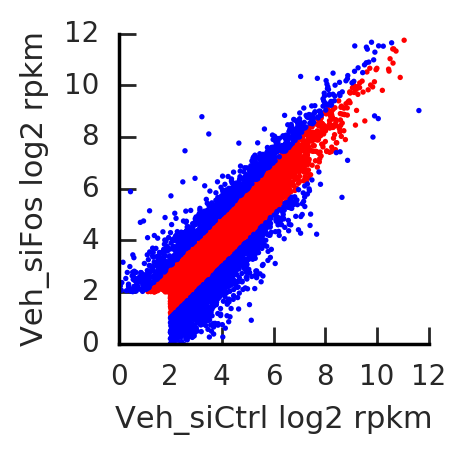

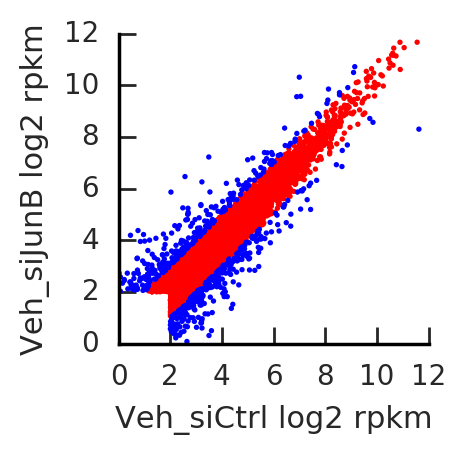

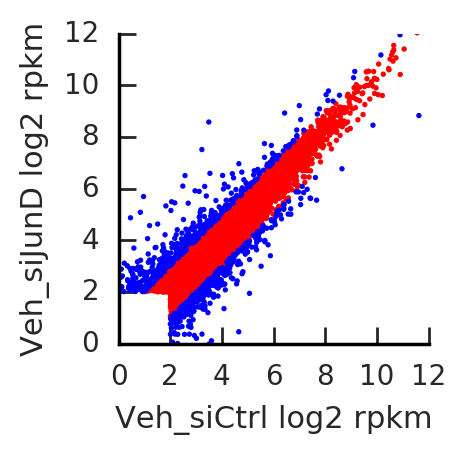

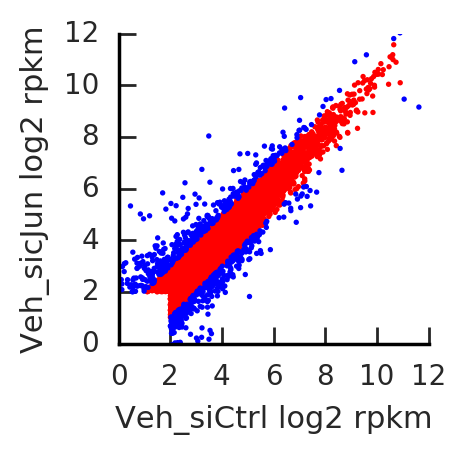

In [275]:
fdr_threshold = 0.05
fold_threshold = 2
rpkm_cutoff = 4.0
label_fold_threshold = 6
# specific genes to annotate no matter what
target_genes = []
target_genes = [x.upper() for x in target_genes]

sns.set_style('ticks',{'axes.edgecolor': 'black',
                       'xtick.direction': 'in',
                       'ytick.direction': 'in', 
                         })

! rm ./scatter_plots/*



if not os.path.isdir('./scatter_plots'):
    os.mkdir('./scatter_plots/')
treatment_up_dict = {}
treatment_down_dict = {}
   

   
fdrColumns = [x for x in diffExpression_frame.columns if 'adj.' in x and 'Ctrl' in x]


for c in fdrColumns:
        tokens = c.split()
        if ('veh' in tokens[0].lower() and 'veh' in tokens[2].lower()) or ('kla' in tokens[0].lower() and 'kla' in tokens[2].lower()):
            if 'ctrl' in tokens[0].lower():
                treatment1 = tokens[0]
                treatment2 = tokens[2]
            else:
                treatment1 = tokens[2]
                treatment2 = tokens[0]

            fc_column = c.replace('adj. p-value', 'Log2 Fold Change')

            diff_genes = diffExpression_frame[diffExpression_frame[c] < fdr_threshold]['gene'].values

            reads1 = idr_rpkm_mean_frame[treatment1]
            reads2 = idr_rpkm_mean_frame[treatment2]
            all_genes = idr_rpkm_frame.index.values
            read_tuple_list = tuple(zip(all_genes, reads1, reads2))
            filtered_read_tuple_list = [x for x in read_tuple_list if x[1] >= rpkm_cutoff or x[2]>= rpkm_cutoff ]

            filtered_genes = [x[0] for x in filtered_read_tuple_list]
            reads1 = np.array([x[1] for x in filtered_read_tuple_list])
            reads2 = np.array([x[2] for x in filtered_read_tuple_list])
             # log values
            logged_reads1 = np.log2(reads1 + 0.01)
            logged_reads2 = np.log2(reads2 + 0.01)

            label_x = []
            label_y = []
            fold_genes = []
            colors = []
            for i in range(len(filtered_genes)): 
                fold = (reads1[i]+0.000001)/(reads2[i]+0.0000001)

                if fold >=fold_threshold or fold <=1/fold_threshold:
                    fold_genes.append(filtered_genes[i])
                    label_x.append(logged_reads1[i])
                    label_y.append(logged_reads2[i])
                    colors.append('blue')
                elif filtered_genes[i].upper() in target_genes:
                    fold_genes.append(filtered_genes[i])
                    label_x.append(logged_reads1[i])
                    label_y.append(logged_reads2[i])
                    colors.append('red')
                else:
                    colors.append('red')

            # ensure diff diff expressed genes are on top
            val_tuples = tuple(zip(logged_reads1,logged_reads2,colors))
            sorted_tuples = sorted(val_tuples,key=lambda x: x[2], reverse=True)
            logged_reads1 = [x[0] for x in sorted_tuples] 
            logged_reads2 = [x[1] for x in sorted_tuples]
            colors = [x[2] for x in sorted_tuples]
            plt.figure(figsize=(2,2))
            plt.scatter(logged_reads1, logged_reads2, edgecolors='none', c=colors, marker = '.', s=15)
            ### annotate differentially expressed genes

#             for label, x, y in zip(fold_genes, label_x, label_y):
#                 fold = (x+0.000001)/(y+0.0000001)
#                 if fold >=label_fold_threshold or fold <=1/label_fold_threshold:
#                     plt.annotate(
#                         label, 
#                         xy = (x, y),
#                         size=4)

            sns.despine()
            # fix aspect ratio
            ax = plt.gca()
            ax.set_xlim((0,12))
            ax.set_ylim((0,12))
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect(abs(x1-x0)/abs(y1-y0))        
            plt.xlabel(treatment1 + ' log2 rpkm')
            plt.ylabel(treatment2 + ' log2 rpkm')
            plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter.png', bbox_inches='tight')
            plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter.pdf', bbox_inches='tight')
            plt.show()
            
        